### Import Function and Libraries

#### Retrieving the high,low, close and open data from Yahoofinance. We will be performing cointegration with existing library.

In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
from yahoofinancials import YahooFinancials
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from Data_Retrieval import DataRetrieval
from CC_test import CCstudy
import itertools
from pandas_datareader import data as pdr
from yahooquery import Ticker

In [2]:
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from Spread import Spread

In [5]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings('ignore')

### Use of yahooquery to retrieve the industry and sector according to ticker

### Industry and Sector dictionary

In [15]:
def classification(tickers):
    tickers = Ticker(tickers, asynchronous=True)
    
    datasi = tickers.get_modules("summaryProfile quoteType")
    dfsi = pd.DataFrame.from_dict(datasi).T
    dataframes = [pd.json_normalize([x for x in dfsi[module] if isinstance(x, dict)]) for
    module in ['summaryProfile', 'quoteType']]
    
    dfsi = pd.concat(dataframes, axis=1)
    
    dfsi = pd.DataFrame(dfsi.set_index('symbol'))
    dfsi=dfsi[['industry', 'sector']].reset_index()
    dfsi['symbol'].str.upper()
    return dfsi


### Import TW exchange counters

Our main focus in on Taiwan exchange counters hence we will import taiwan exchange ticker code and retrieve the adjusted closing price from yahoo finance API. Next, we will categorize it

In [277]:
counter_code = pd.read_csv('taiwan_stocks.csv')

In [278]:
tickers = list(counter_code.iloc[:,2])

In [280]:
tickers = list(counter_code.iloc[:,2].apply(lambda x: str(x)+".TW"))

In [281]:
tickers.append('0057.TW')

In [283]:
#tickers = ['2330.tw','0052.TW']
start_date = "2017-01-01"
end_date = "2023-01-12"

if tickers is not None:
    merged_df = DataRetrieval.retrieve_and_merge_data(tickers, start_date, end_date)
else:
    print("Error: tickers is None")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [285]:
merged_df = merged_df.dropna(axis=1, how='any')

In [287]:
merged_df

1303.TW    2002.TW    2303.TW     2330.TW    2881.TW    1301.TW  \
Date                                                                            
2017-01-03  47.744907  18.155310   7.756602  146.720337  28.995785  62.056210   
2017-01-04  48.080189  18.340948   7.722581  146.720337  28.826542  62.193958   
2017-01-05  49.220169  18.452328   7.756602  147.121185  28.995785  62.262844   
2017-01-06  49.220169  18.340948   7.892683  147.522064  29.108604  62.331711   
2017-01-09  49.488400  18.229563   7.892683  147.522064  29.165020  62.125084   
...               ...        ...        ...         ...        ...        ...   
2023-01-05  68.266273  28.539743  36.435490  441.562042  50.391552  82.118309   
2023-01-06  68.929047  28.682442  37.451271  441.562042  50.391552  82.587555   
2023-01-09  70.822708  29.443502  39.306168  463.230865  51.339085  83.432198   
2023-01-10  70.538651  29.348370  39.747810  468.046173  50.994526  83.432198   
2023-01-11  70.065247  29.205671  39.880302  466.601593  50.046997  82.493706   

              2324.TW    2409.TW    2880.TW    2882.TW  ...     1795.TW  \
Date                                                    ...               
2017-01-03  11.817384   9.065211   9.712663  33.428658  ...   56.543301   
2017-01-04  11.817384   9.027439   9.682777  33.359020  ...   57.592167   
2017-01-05  11.912430   9.254068   9.772431  33.707237  ...   58.164276   
2017-01-06  11.880749   9.480700   9.802317  33.950989  ...   57.306110   
2017-01-09  11.817384   9.707331   9.832201  34.125092  ...   55.780491   
...               ...        ...        ...        ...  ...         ...   
2023-01-05  21.237062  14.182665  20.850069  38.092911  ...  232.478775   
2023-01-06  21.283230  14.547492  20.988150  38.566116  ...  233.449463   
2023-01-09  21.514069  14.638699  21.540468  39.749123  ...  241.700272   
2023-01-10  21.467901  14.593096  21.632523  39.465202  ...  236.846863   
2023-01-11  21.144728  14.684303  21.356363  39.181278  ...  233.449463   

              1905.TW    1513.TW    3005.TW    8112.TW    1503.TW    6139.TW  \
Date                                                                           
2017-01-03   7.900723  14.171649  24.109892  12.488033  32.763046  25.612843   
2017-01-04   7.866372  14.171649  24.263857  12.657774  32.763046  26.067717   
2017-01-05   8.433164  14.756048  24.633350  12.827515  32.803543  25.717812   
2017-01-06   8.544805  15.011720  24.356228  12.851763  32.803543  25.647837   
2017-01-09   8.355873  14.938669  25.341562  12.997255  32.398563  25.053001   
...               ...        ...        ...        ...        ...        ...   
2023-01-05  16.316326  68.779243  40.041321  31.008217  67.351639  35.138721   
2023-01-06  16.316326  69.544510  40.041321  31.134436  66.276360  36.656490   
2023-01-09  16.415215  70.022812  40.131401  31.260654  63.343781  37.714333   
2023-01-10  16.415215  69.257538  40.221485  31.218588  60.899956  37.806316   
2023-01-11  16.415215  68.874901  40.041321  31.050293  60.411190  38.082279   

              5876.TW    6505.TW    0057.TW  
Date                                         
2017-01-03  18.710472  83.657341  41.990002  
2017-01-04  18.842136  83.657341  42.220001  
2017-01-05  18.814419  84.803322  42.610001  
2017-01-06  18.897577  83.275345  42.639999  
2017-01-09  18.918365  83.275345  42.580002  
...               ...        ...        ...  
2023-01-05  41.976517  76.310081  79.050003  
2023-01-06  41.745872  77.746284  79.599998  
2023-01-09  42.668438  78.608009  81.699997  
2023-01-10  42.576180  79.086739  82.500000  
2023-01-11  42.668438  77.746284  82.449997  

[1472 rows x 189 columns]

### Correlation and Cointegration Study 


Cointegration Test Results:


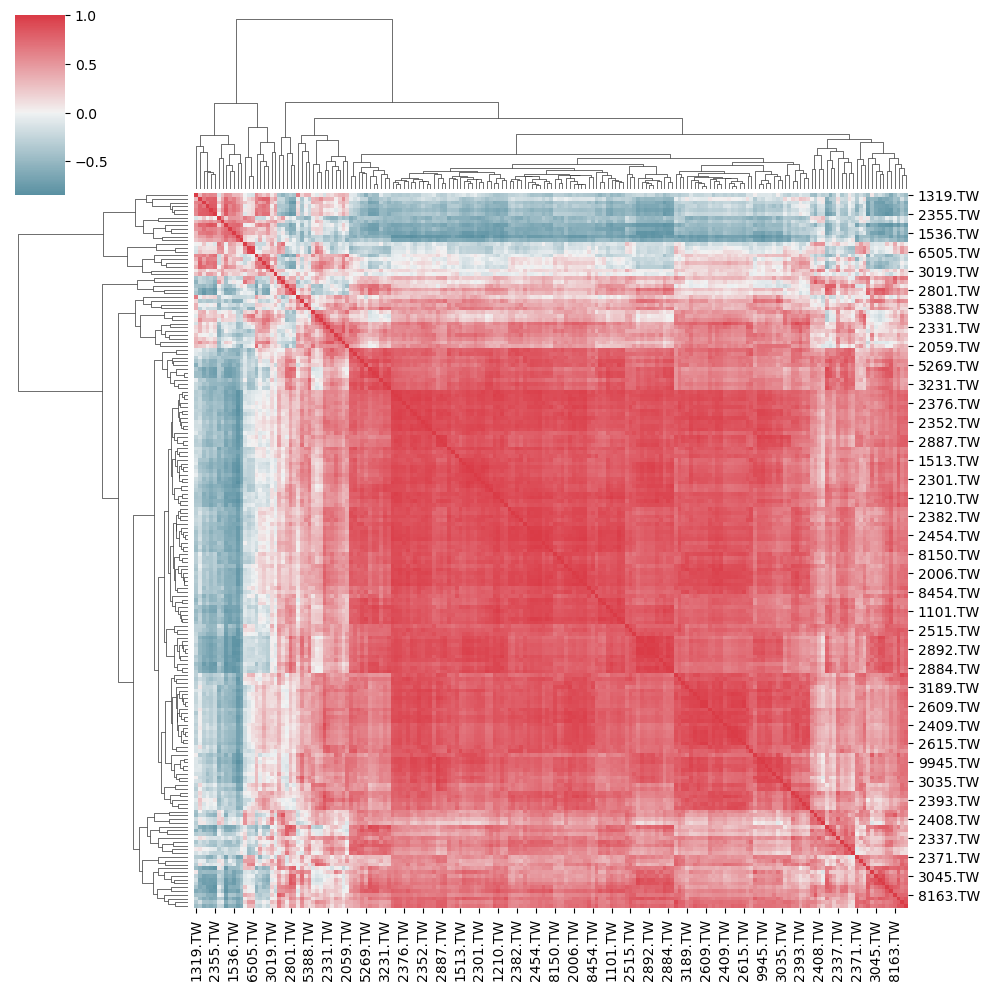

In [292]:
cc_study = CCstudy(merged_df)
table = cc_study.main()

In [293]:
table.sort_values(by=['Cointegration result','correlation'],ascending =[True,False])

ticker1  ticker2  Cointegration result  correlation
901   2881.TW  2606.TW              0.000007     0.931725
5089  2337.TW  2393.TW              0.000009     0.682413
4886  2317.TW  2337.TW              0.000011     0.619049
6830  3231.TW  3406.TW              0.000015     0.700820
5088  2337.TW  2392.TW              0.000031     0.720911
...       ...      ...                   ...          ...
9206  2201.TW  2355.TW              0.985736     0.014561
2715  1605.TW  2323.TW              0.985818     0.241505
9214  2201.TW  6414.TW              0.987862    -0.008420
9210  2201.TW  9938.TW              0.991218     0.178918
2783  1605.TW  2492.TW              0.992131    -0.029211

[17766 rows x 4 columns]

In [150]:
table =table[(table['Cointegration result'] < 0.05) & (table['correlation'] > 0.5)].sort_values(by=['correlation','Cointegration result'],ascending =[False,True])

In [151]:
def categorize(classlist,column,counter):
    if column == 'industry':
        a=pd.DataFrame(dict(classlist.iloc[:,0:2]))
        return table[counter].map(a.set_index('symbol')[column])
    elif column == 'sector':
        b= pd.DataFrame(dict(classlist.iloc[:,[0,2]]))
        return table[counter].map(b.set_index('symbol')[column])
    else:
        return 'Error'

In [152]:
table['ticker1_industry'] = categorize(classlist,'sector','ticker1')
table['ticker2_industry'] = categorize(classlist,'sector','ticker2')


In [154]:
table

ticker1  ticker2  Cointegration result  correlation  \
1215   2324.TW  3702.TW              0.000379     0.969729   
901    2881.TW  2606.TW              0.000006     0.932118   
7726   1440.TW  2606.TW              0.000569     0.931760   
15258  6271.TW  8150.TW              0.000110     0.903438   
6803   3231.TW  3380.TW              0.000777     0.892609   
9537   2312.TW  2542.TW              0.000453     0.848095   
9631   2312.TW  3005.TW              0.000964     0.830770   
12952  2605.TW  2328.TW              0.000646     0.795494   
14138  3376.TW  3406.TW              0.000079     0.794829   
3410   2408.TW  2337.TW              0.000189     0.791165   
16113  3406.TW  6269.TW              0.000744     0.781899   
15497  8039.TW  3406.TW              0.000456     0.780289   
15997  3044.TW  3406.TW              0.000144     0.735469   
5137   2337.TW  8039.TW              0.000246     0.733860   
5181   2337.TW  2441.TW              0.000068     0.726348   
5088   2337.TW  2392.TW              0.000031     0.720911   
5092   2337.TW  2449.TW              0.000036     0.704348   
15152  6239.TW  3406.TW              0.000043     0.702929   
6830   3231.TW  3406.TW              0.000015     0.700820   
5166   2337.TW  6116.TW              0.000169     0.700642   
16119  3406.TW  4958.TW              0.000225     0.697772   
5204   2337.TW  0050.TW              0.000118     0.687513   
5120   2337.TW  3380.TW              0.000035     0.686409   
5089   2337.TW  2393.TW              0.000009     0.682413   
10922  2385.TW  3406.TW              0.000070     0.666471   
16140  3406.TW  3706.TW              0.000666     0.659055   
1135   2324.TW  2337.TW              0.000203     0.649922   
5182   2337.TW  8150.TW              0.000047     0.646772   
5133   2337.TW  6271.TW              0.000118     0.643242   
5148   2337.TW  6269.TW              0.000259     0.640779   
5126   2337.TW  4938.TW              0.000066     0.632297   
5175   2337.TW  3706.TW              0.000262     0.631385   
4886   2317.TW  2337.TW              0.000011     0.619049   
5082   2337.TW  2347.TW              0.000320     0.615105   
16114  3406.TW  9914.TW              0.000293     0.604149   
16163  3406.TW  3005.TW              0.000919     0.603261   
11038  2392.TW  3406.TW              0.000301     0.598404   
5078   2337.TW  2331.TW              0.000058     0.593473   
5135   2337.TW  6282.TW              0.000050     0.592896   
5056   2337.TW  3231.TW              0.000123     0.592532   
5144   2337.TW  2328.TW              0.000068     0.583318   
5143   2337.TW  1802.TW              0.000938     0.582466   
5052   2337.TW  3481.TW              0.000043     0.581231   
5062   2337.TW  1440.TW              0.000172     0.574257   
28     1303.TW  2337.TW              0.000539     0.560693   
5140   2337.TW  9939.TW              0.000114     0.558004   
7838   1504.TW  3406.TW              0.000140     0.556636   
16144  3406.TW  1717.TW              0.000594     0.556336   
16169  3406.TW  0050.TW              0.000879     0.556139   
5075   2337.TW  2308.TW              0.000287     0.554833   
1675   2882.TW  2337.TW              0.000217     0.548282   
5149   2337.TW  9914.TW              0.000557     0.547517   
5152   2337.TW  2883.TW              0.000500     0.546458   
4240   2888.TW  2337.TW              0.000984     0.541982   
5079   2337.TW  2332.TW              0.000233     0.534929   
4178   2801.TW  3406.TW              0.000312     0.518489   
5074   2337.TW  2301.TW              0.000194     0.511829   
5109   2337.TW  2913.TW              0.000431     0.505475   

         ticker1_industry    ticker2_industry  
1215           Technology          Technology  
901    Financial Services         Industrials  
7726    Consumer Cyclical         Industrials  
15258          Technology          Technology  
6803           Technology          Technology  
9537           Technology         Real Estate  
9631        

### Selection of pair trading

In order to remove any industry specific systematic risk, the first criteria should be that the pair of stocks should belong to the same industry. Next, we shall run the time series spread graph.

In [157]:
Pair = []
for index, row in table.iterrows():
    Pair.append([row['ticker1'],row['ticker2']])

In [ ]:
selected ='

In [161]:
Pair

[['2324.TW', '3702.TW'],
 ['2881.TW', '2606.TW'],
 ['1440.TW', '2606.TW'],
 ['6271.TW', '8150.TW'],
 ['3231.TW', '3380.TW'],
 ['2312.TW', '2542.TW'],
 ['2312.TW', '3005.TW'],
 ['2605.TW', '2328.TW'],
 ['3376.TW', '3406.TW'],
 ['2408.TW', '2337.TW'],
 ['3406.TW', '6269.TW'],
 ['8039.TW', '3406.TW'],
 ['3044.TW', '3406.TW'],
 ['2337.TW', '8039.TW'],
 ['2337.TW', '2441.TW'],
 ['2337.TW', '2392.TW'],
 ['2337.TW', '2449.TW'],
 ['6239.TW', '3406.TW'],
 ['3231.TW', '3406.TW'],
 ['2337.TW', '6116.TW'],
 ['3406.TW', '4958.TW'],
 ['2337.TW', '0050.TW'],
 ['2337.TW', '3380.TW'],
 ['2337.TW', '2393.TW'],
 ['2385.TW', '3406.TW'],
 ['3406.TW', '3706.TW'],
 ['2324.TW', '2337.TW'],
 ['2337.TW', '8150.TW'],
 ['2337.TW', '6271.TW'],
 ['2337.TW', '6269.TW'],
 ['2337.TW', '4938.TW'],
 ['2337.TW', '3706.TW'],
 ['2317.TW', '2337.TW'],
 ['2337.TW', '2347.TW'],
 ['3406.TW', '9914.TW'],
 ['3406.TW', '3005.TW'],
 ['2392.TW', '3406.TW'],
 ['2337.TW', '2331.TW'],
 ['2337.TW', '6282.TW'],
 ['2337.TW', '3231.TW'],


Statistics for the spread between 2324.TW and 3702.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW     0.23196 -4.516901         -4.11097        -4.922831   

   Revert Time  
0    79.357143  


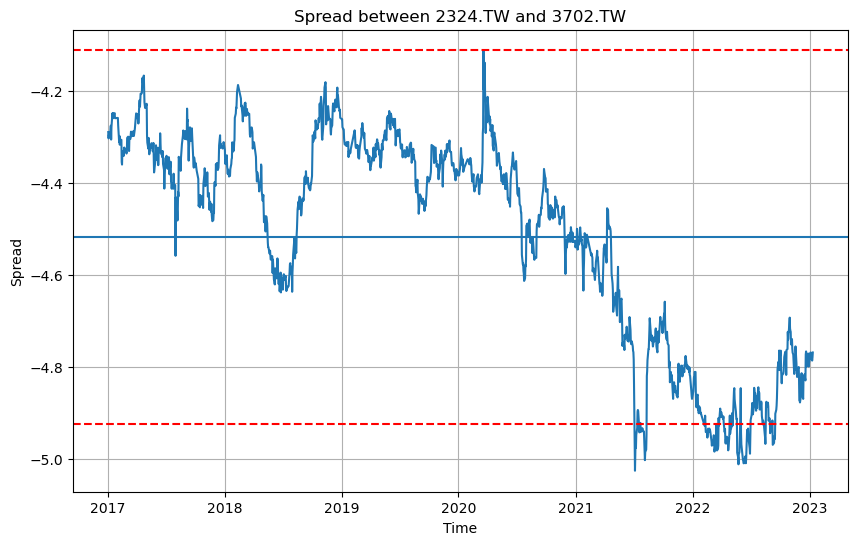

Statistics for the spread between 2881.TW and 2606.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW     0.23196 -4.516901        -4.110970        -4.922831   
1  2881.TW  2606.TW     0.10218  0.285722         0.464537         0.106908   

   Revert Time  
0    79.357143  
1    49.214286  


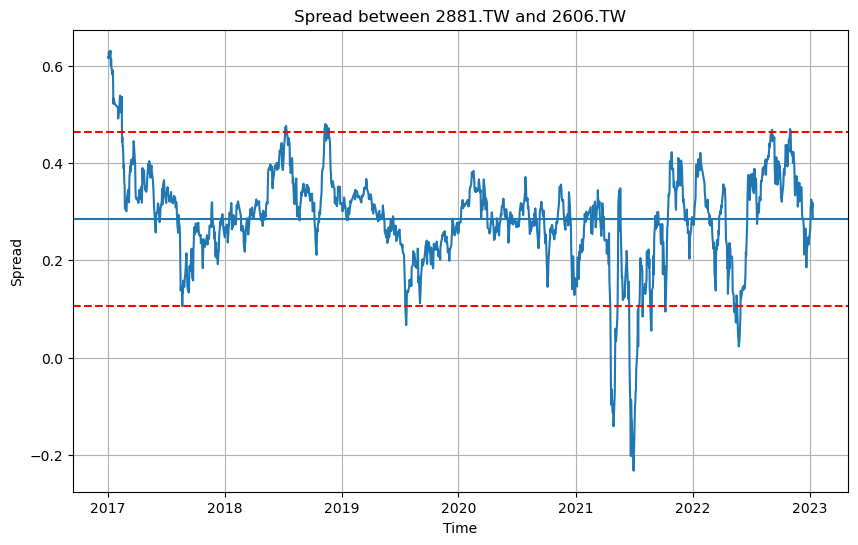

Statistics for the spread between 1440.TW and 2606.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.231960 -4.516901        -4.110970        -4.922831   
1  2881.TW  2606.TW    0.102180  0.285722         0.464537         0.106908   
2  1440.TW  2606.TW    0.443129 -4.972227        -4.196752        -5.747702   

   Revert Time  
0    79.357143  
1    49.214286  
2    78.344828  


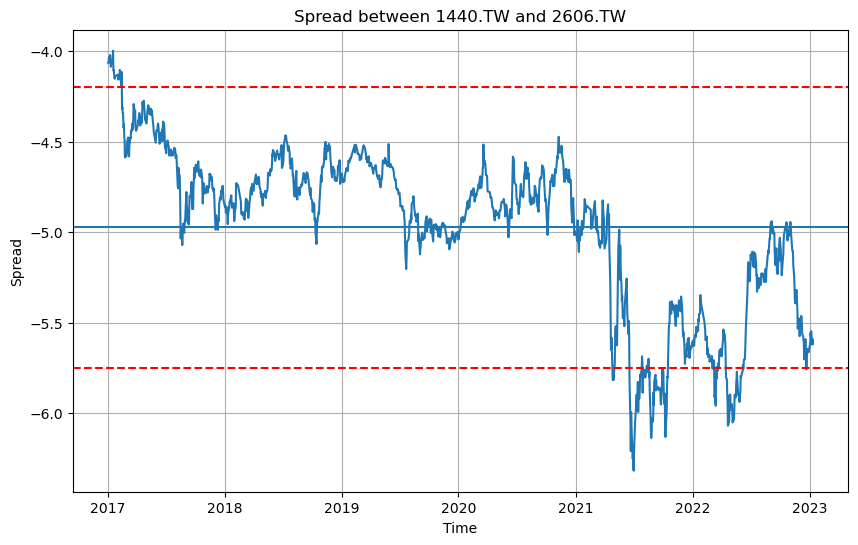

Statistics for the spread between 6271.TW and 8150.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.231960 -4.516901        -4.110970        -4.922831   
1  2881.TW  2606.TW    0.102180  0.285722         0.464537         0.106908   
2  1440.TW  2606.TW    0.443129 -4.972227        -4.196752        -5.747702   
3  6271.TW  8150.TW    0.218731  4.221345         4.604123         3.838566   

   Revert Time  
0    79.357143  
1    49.214286  
2    78.344828  
3    47.574468  


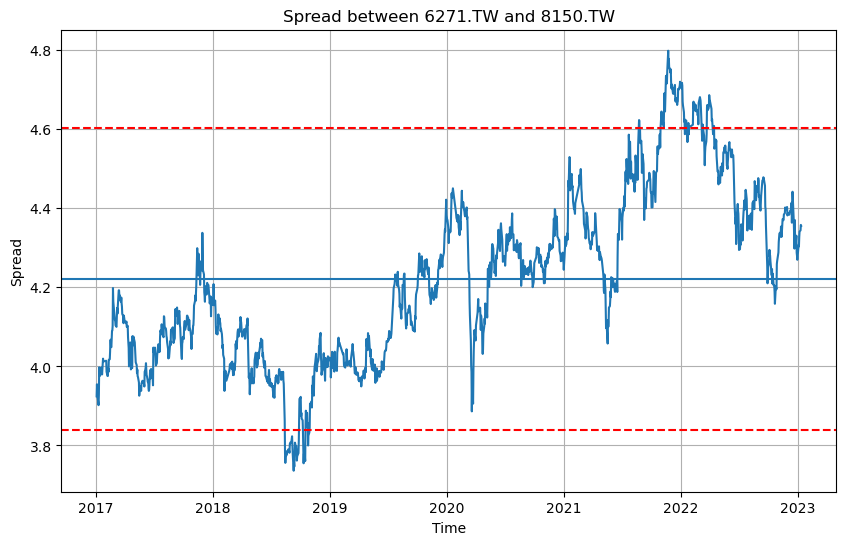

Statistics for the spread between 3231.TW and 3380.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.231960 -4.516901        -4.110970        -4.922831   
1  2881.TW  2606.TW    0.102180  0.285722         0.464537         0.106908   
2  1440.TW  2606.TW    0.443129 -4.972227        -4.196752        -5.747702   
3  6271.TW  8150.TW    0.218731  4.221345         4.604123         3.838566   
4  3231.TW  3380.TW    0.116567 -0.165654         0.038338        -0.369646   

   Revert Time  
0    79.357143  
1    49.214286  
2    78.344828  
3    47.574468  
4    42.309091  


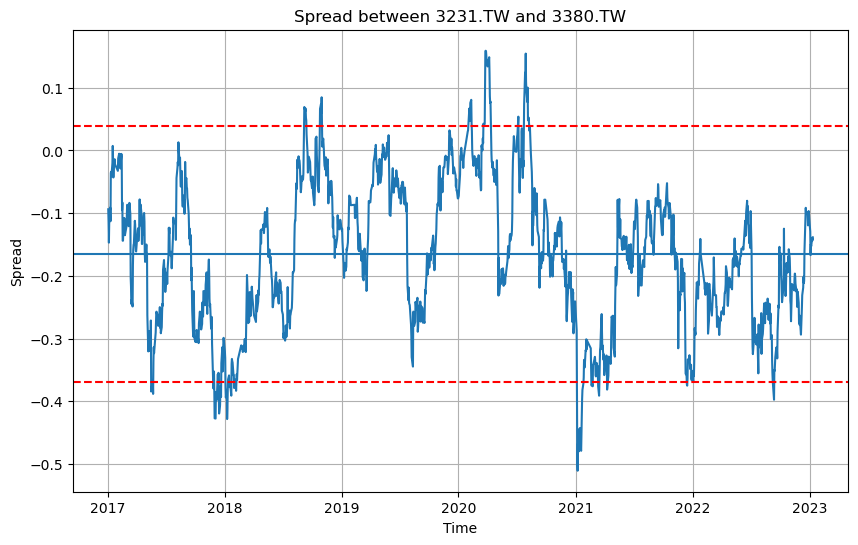

Statistics for the spread between 2312.TW and 2542.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.231960 -4.516901        -4.110970        -4.922831   
1  2881.TW  2606.TW    0.102180  0.285722         0.464537         0.106908   
2  1440.TW  2606.TW    0.443129 -4.972227        -4.196752        -5.747702   
3  6271.TW  8150.TW    0.218731  4.221345         4.604123         3.838566   
4  3231.TW  3380.TW    0.116567 -0.165654         0.038338        -0.369646   
5  2312.TW  2542.TW    0.202891 -3.794896        -3.439838        -4.149954   

   Revert Time  
0    79.357143  
1    49.214286  
2    78.344828  
3    47.574468  
4    42.309091  
5    69.062500  


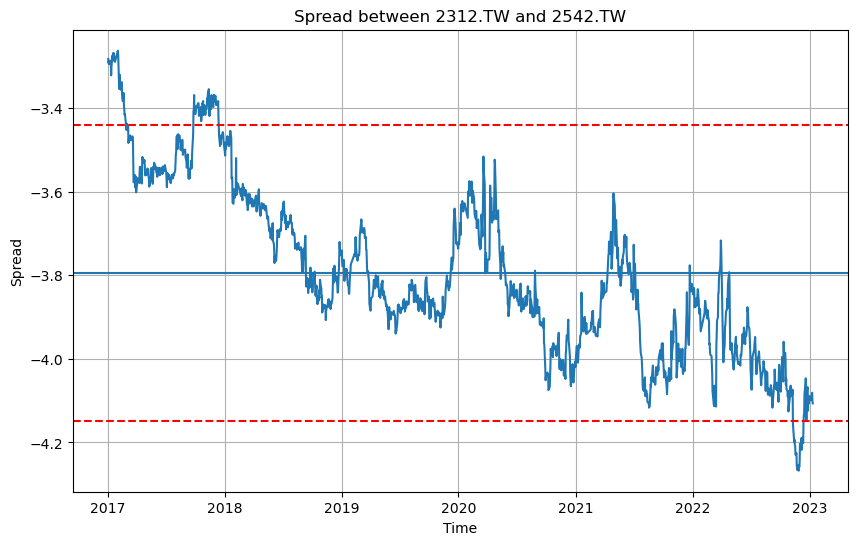

Statistics for the spread between 2312.TW and 3005.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.231960 -4.516901        -4.110970        -4.922831   
1  2881.TW  2606.TW    0.102180  0.285722         0.464537         0.106908   
2  1440.TW  2606.TW    0.443129 -4.972227        -4.196752        -5.747702   
3  6271.TW  8150.TW    0.218731  4.221345         4.604123         3.838566   
4  3231.TW  3380.TW    0.116567 -0.165654         0.038338        -0.369646   
5  2312.TW  2542.TW    0.202891 -3.794896        -3.439838        -4.149954   
6  2312.TW  3005.TW    0.451604 -8.202356        -7.412049        -8.992663   

   Revert Time  
0    79.357143  
1    49.214286  
2    78.344828  
3    47.574468  
4    42.309091  
5    69.062500  
6    71.538462  


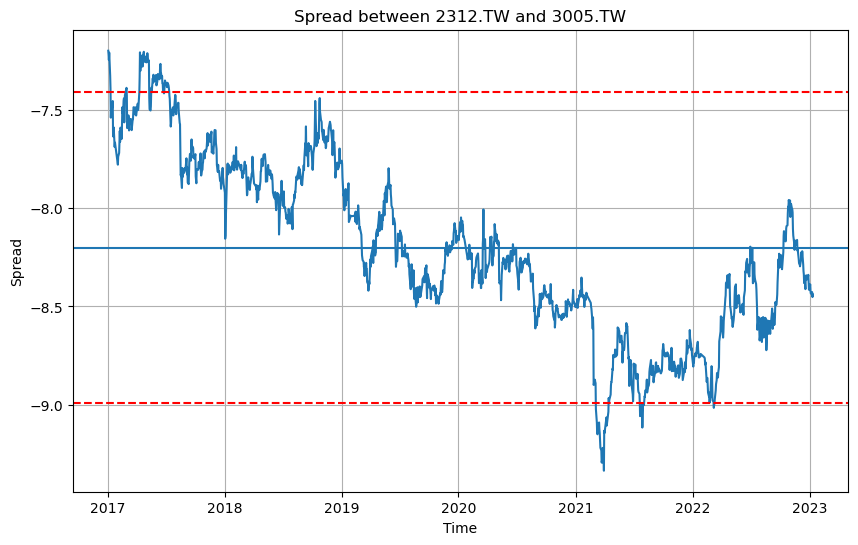

Statistics for the spread between 2605.TW and 2328.TW: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.231960 -4.516901        -4.110970        -4.922831   
1  2881.TW  2606.TW    0.102180  0.285722         0.464537         0.106908   
2  1440.TW  2606.TW    0.443129 -4.972227        -4.196752        -5.747702   
3  6271.TW  8150.TW    0.218731  4.221345         4.604123         3.838566   
4  3231.TW  3380.TW    0.116567 -0.165654         0.038338        -0.369646   
5  2312.TW  2542.TW    0.202891 -3.794896        -3.439838        -4.149954   
6  2312.TW  3005.TW    0.451604 -8.202356        -7.412049        -8.992663   
7  2605.TW  2328.TW    0.173945 -0.321805        -0.017400        -0.626209   

   Revert Time  
0    79.357143  
1    49.214286  
2    78.344828  
3    47.574468  
4    42.309091  
5    69.062500  
6    71.538462  
7    67.184211  


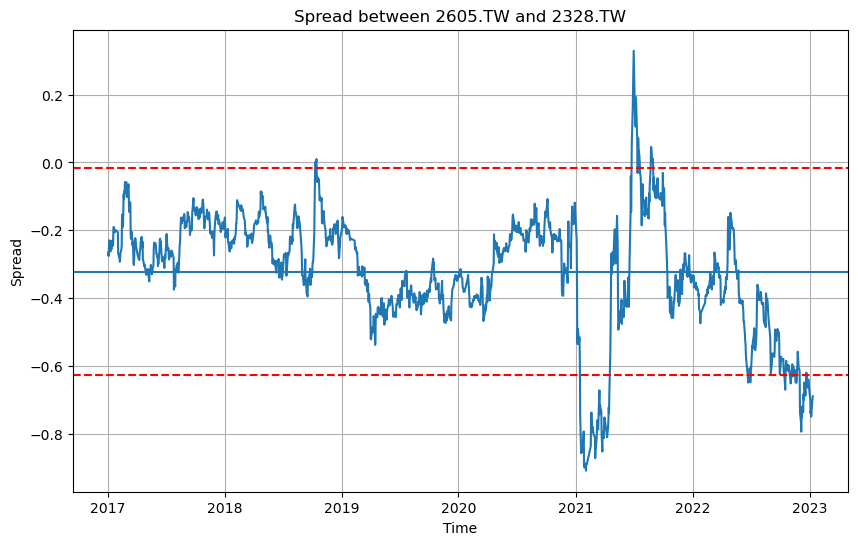

Statistics for the spread between 3376.TW and 3406.TW: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1  2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2  1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3  6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4  3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5  2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6  2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7  2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8  3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   

   Revert Time  
0    79.357143  
1    49.214286  
2    78.344828  
3    47.574468  
4    42.309091  
5    69.062500  
6    71.538462  
7    67

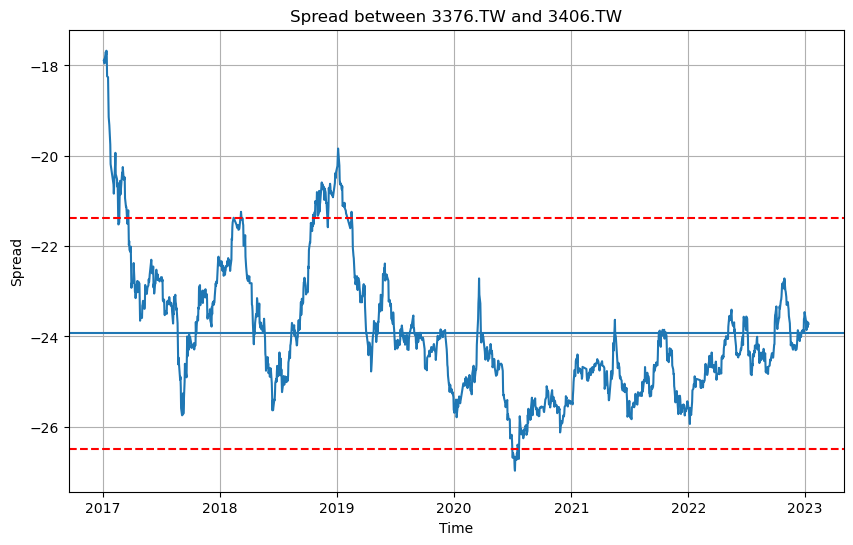

Statistics for the spread between 2408.TW and 2337.TW: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0  2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1  2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2  1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3  6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4  3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5  2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6  2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7  2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8  3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9  2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   

   Revert Time  
0    79.357143  
1    49.214286  
2    78.3448

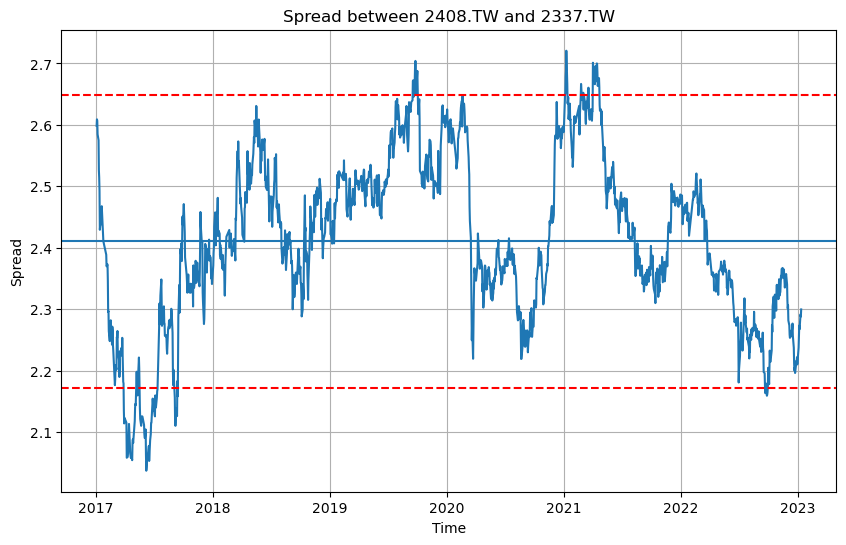

Statistics for the spread between 3406.TW and 6269.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

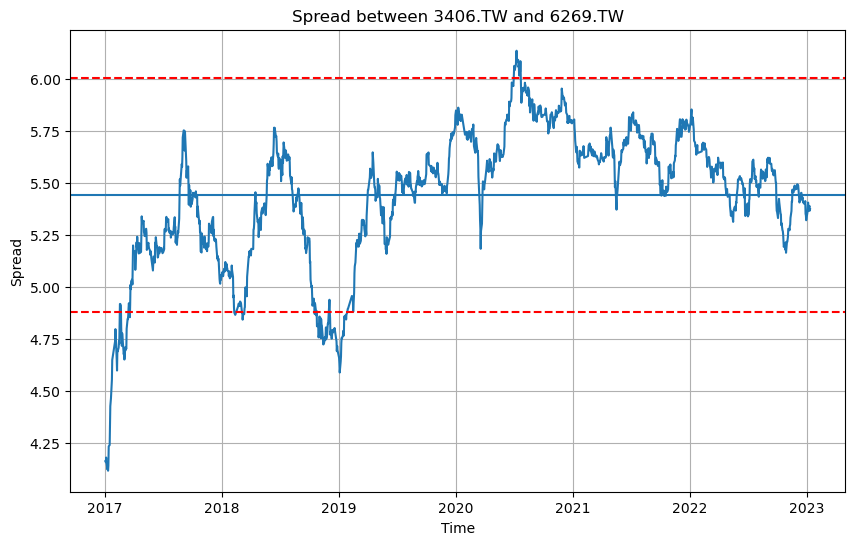

Statistics for the spread between 8039.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

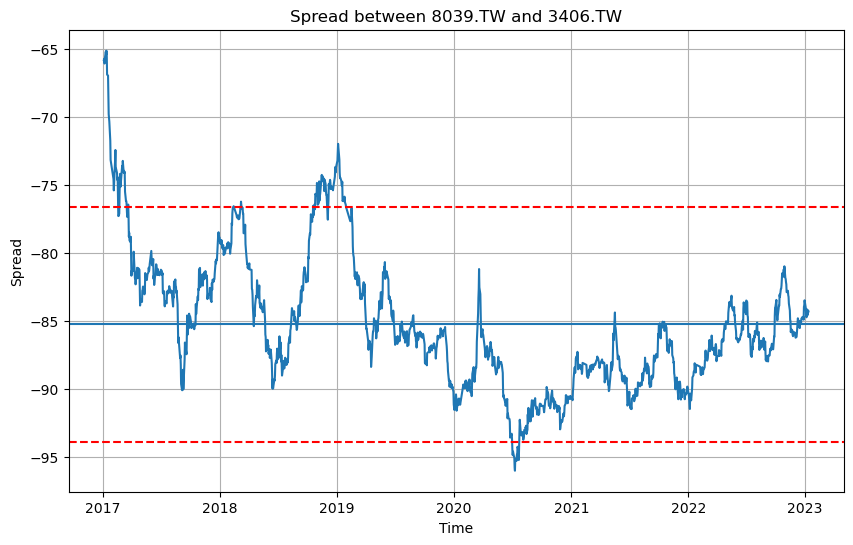

Statistics for the spread between 3044.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

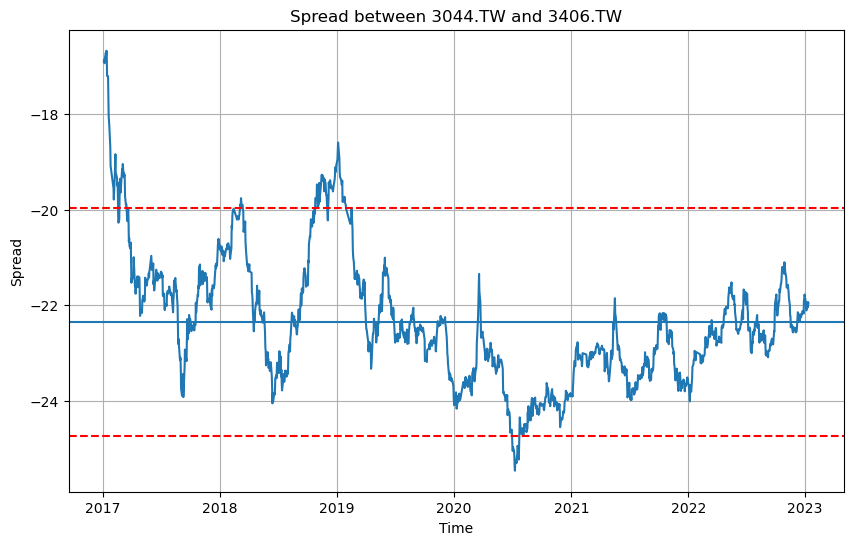

Statistics for the spread between 2337.TW and 8039.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

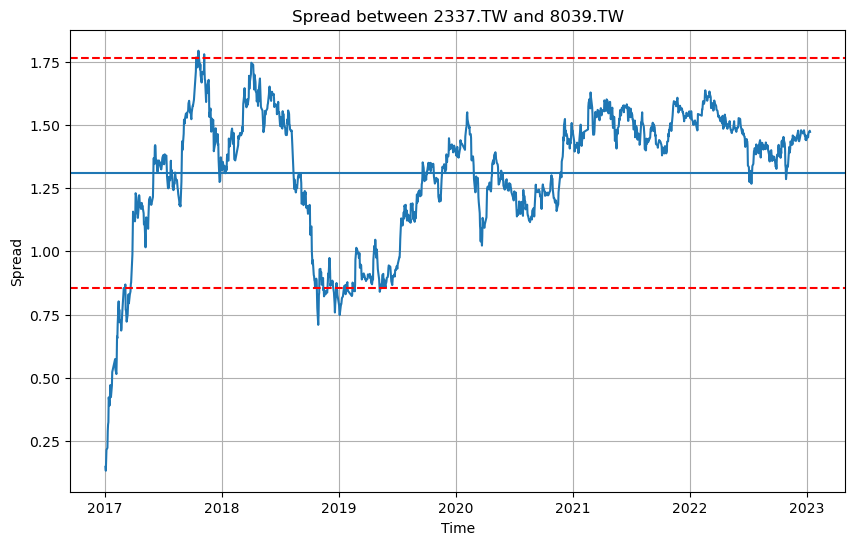

Statistics for the spread between 2337.TW and 2441.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

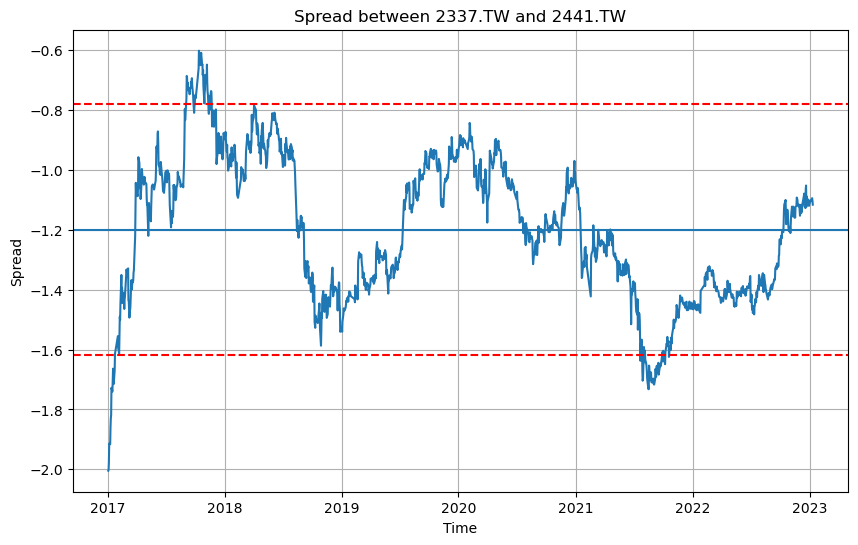

Statistics for the spread between 2337.TW and 2392.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

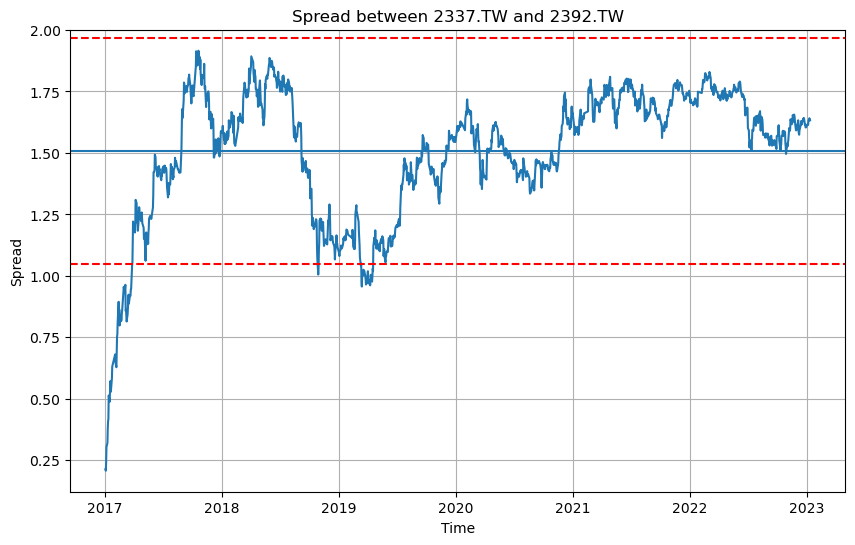

Statistics for the spread between 2337.TW and 2449.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

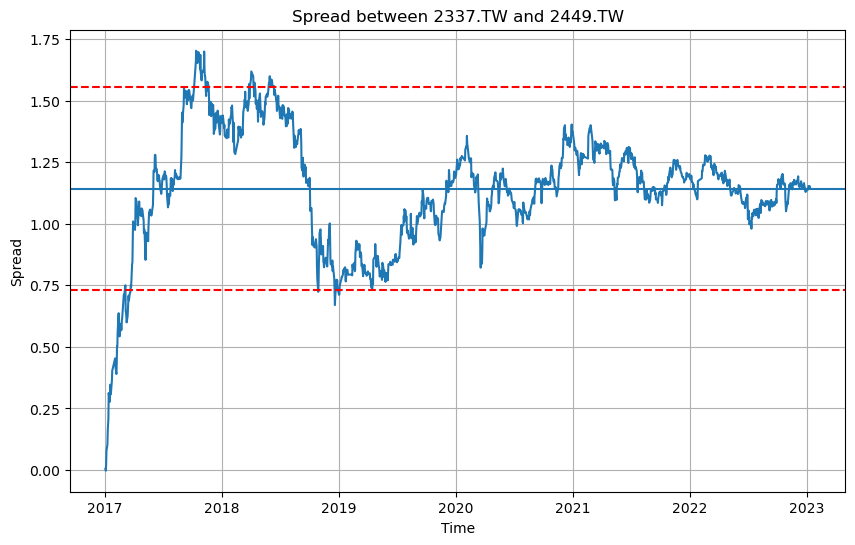

Statistics for the spread between 6239.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

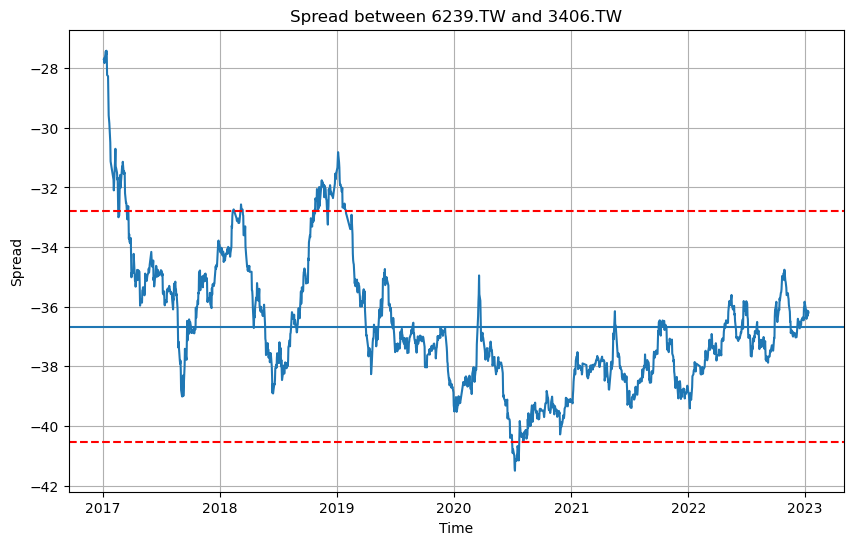

Statistics for the spread between 3231.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

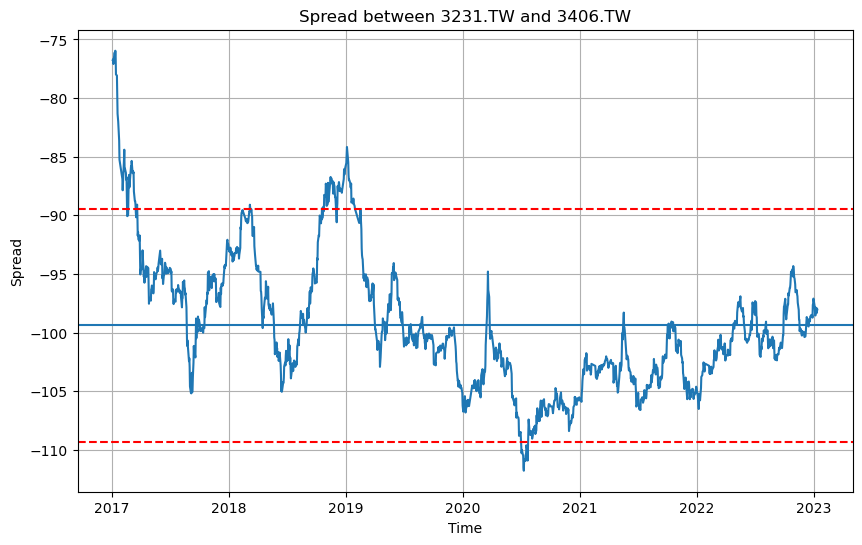

Statistics for the spread between 2337.TW and 6116.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

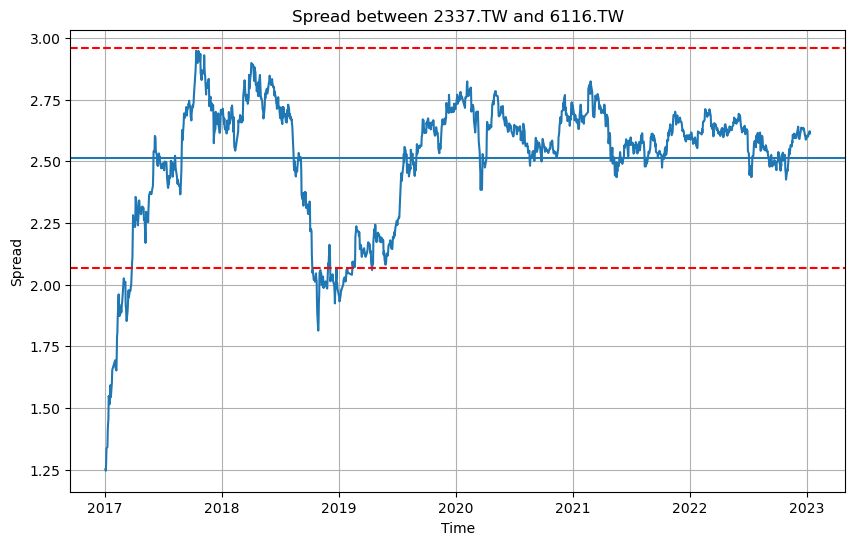

Statistics for the spread between 3406.TW and 4958.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

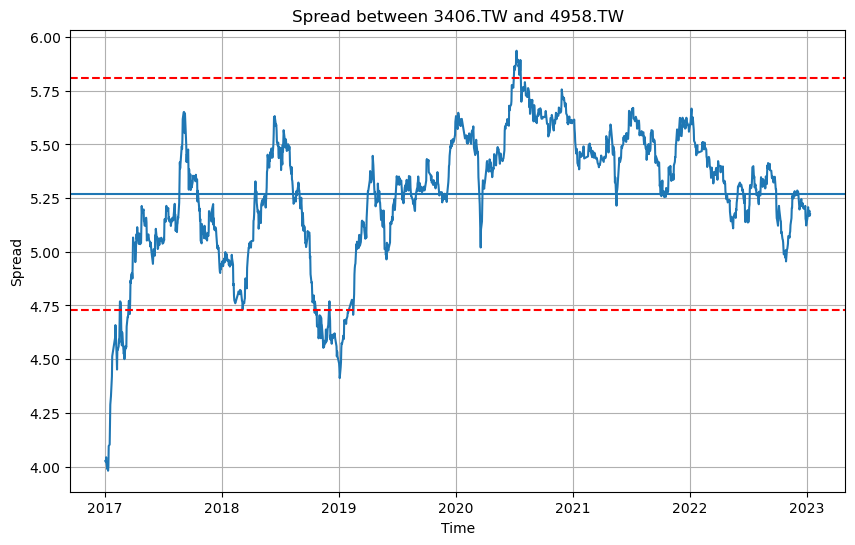

Statistics for the spread between 2337.TW and 0050.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

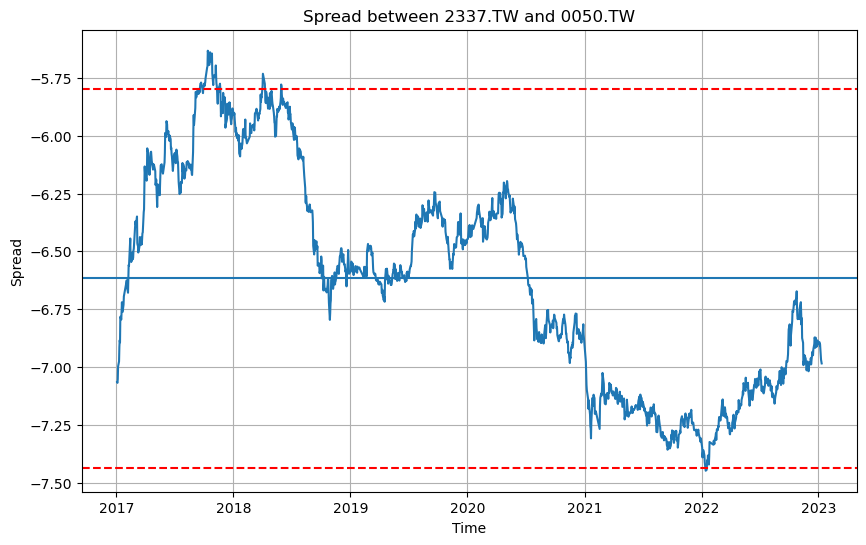

Statistics for the spread between 2337.TW and 3380.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

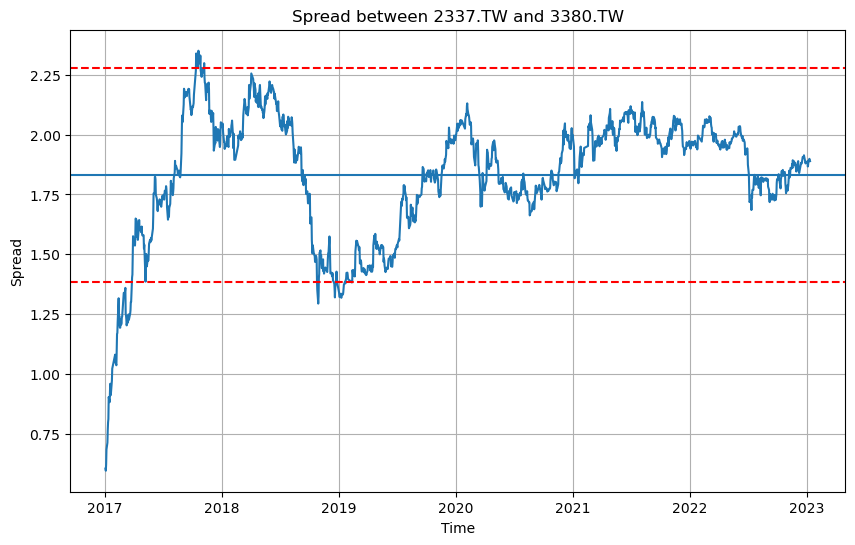

Statistics for the spread between 2337.TW and 2393.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

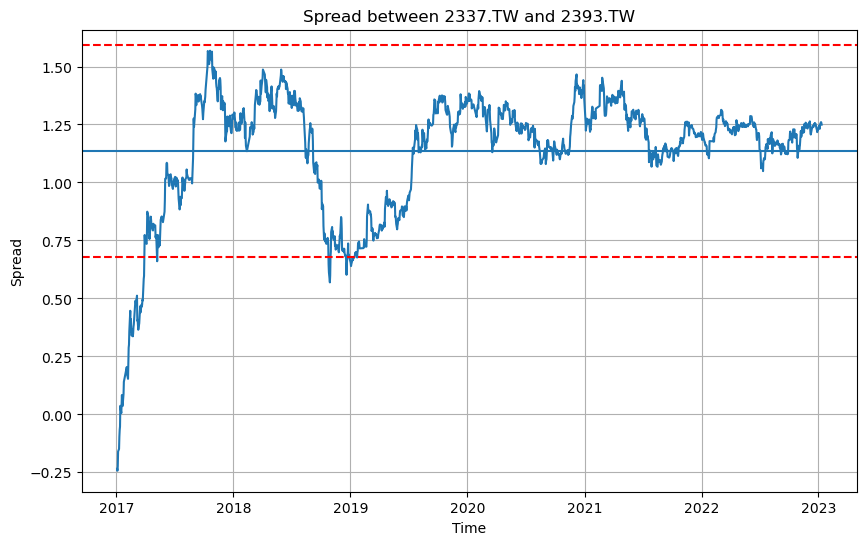

Statistics for the spread between 2385.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

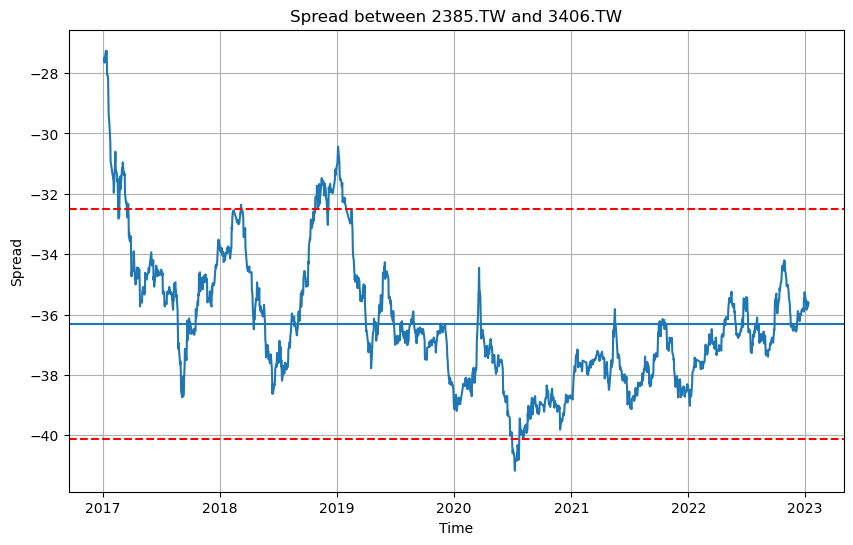

Statistics for the spread between 3406.TW and 3706.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

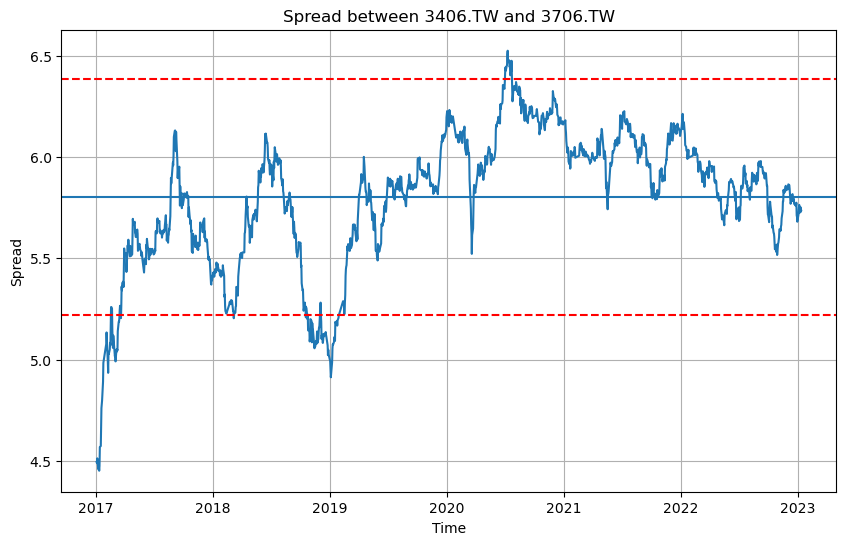

Statistics for the spread between 2324.TW and 2337.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

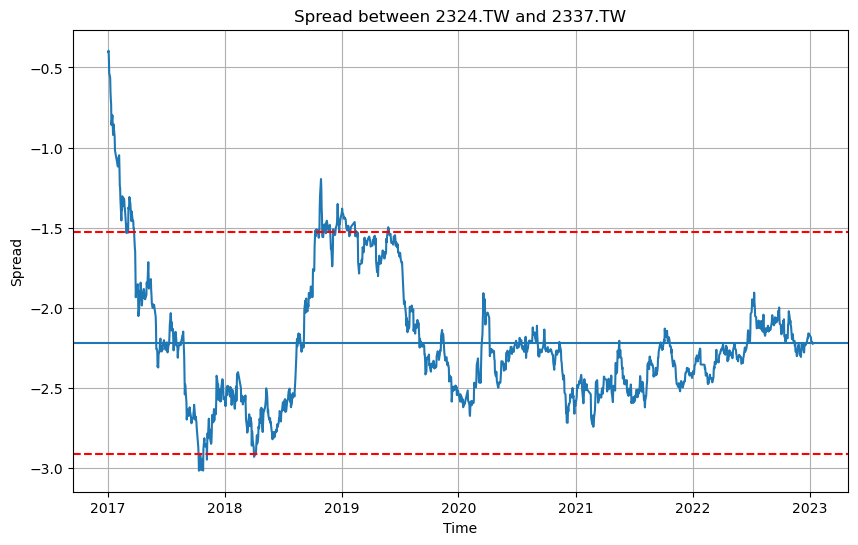

Statistics for the spread between 2337.TW and 8150.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

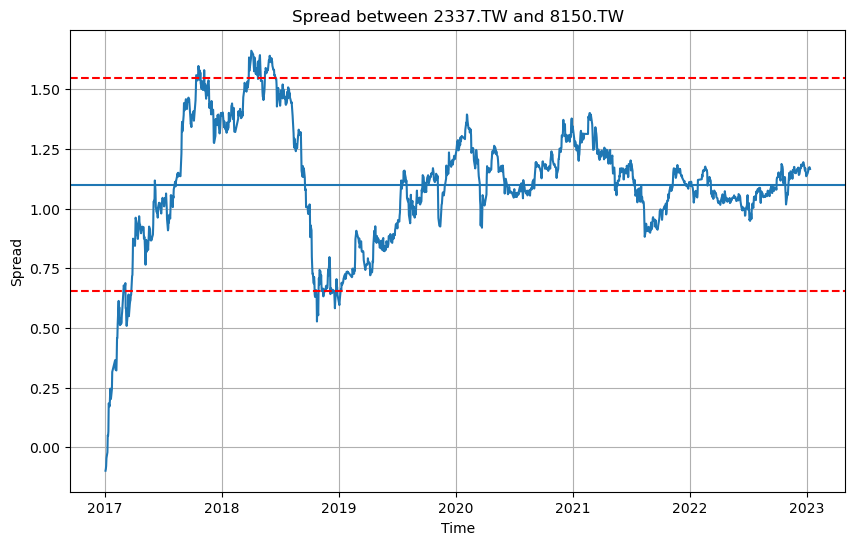

Statistics for the spread between 2337.TW and 6271.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

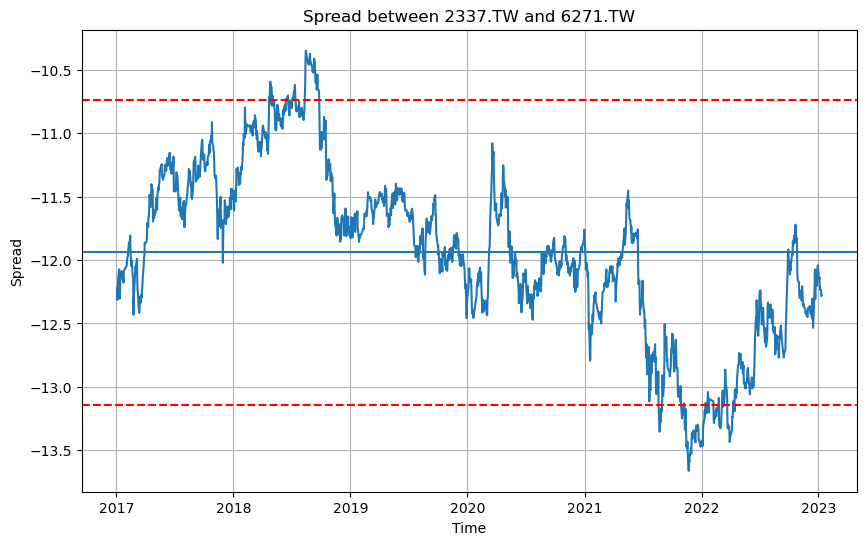

Statistics for the spread between 2337.TW and 6269.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

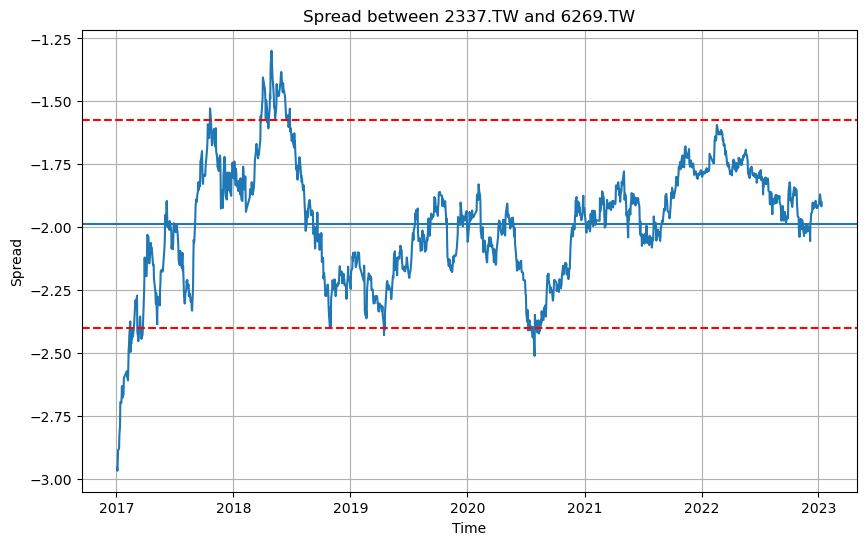

Statistics for the spread between 2337.TW and 4938.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

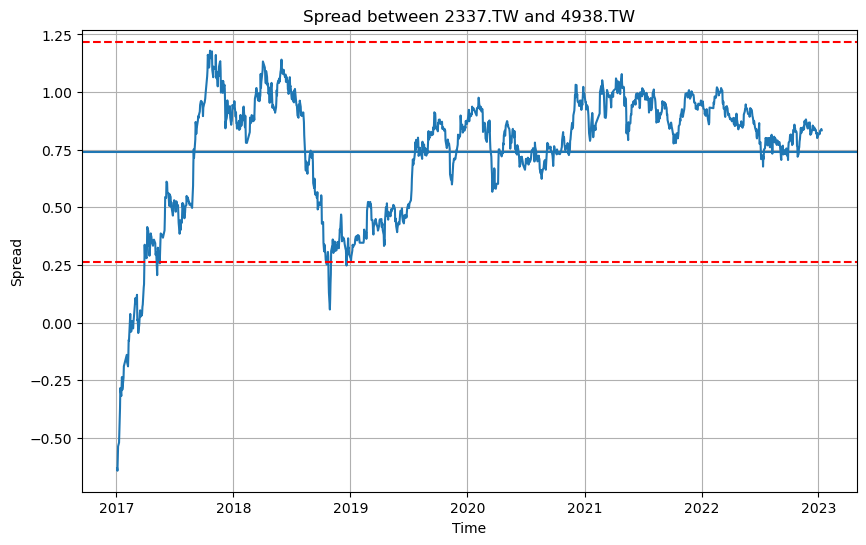

Statistics for the spread between 2337.TW and 3706.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

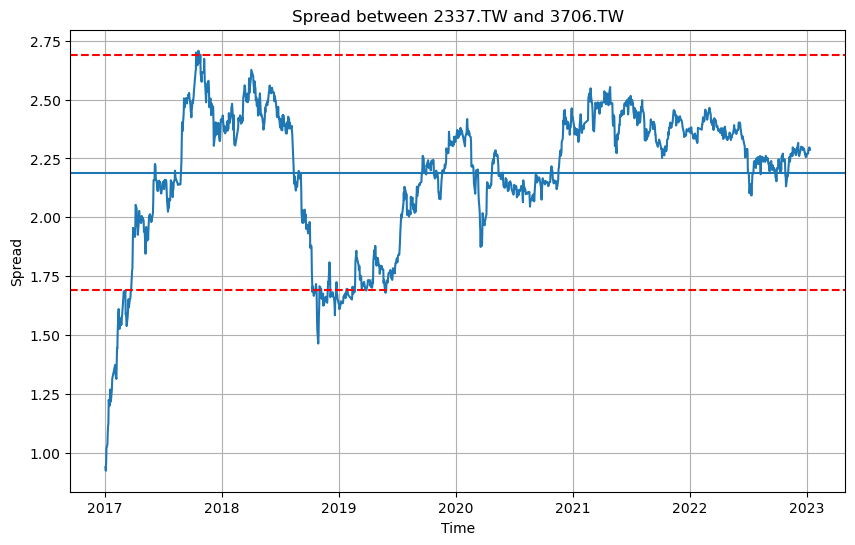

Statistics for the spread between 2317.TW and 2337.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

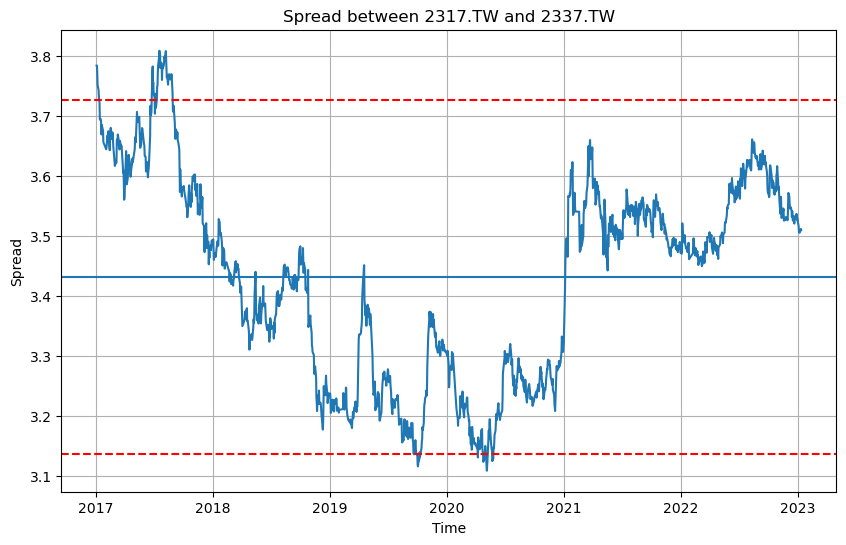

Statistics for the spread between 2337.TW and 2347.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

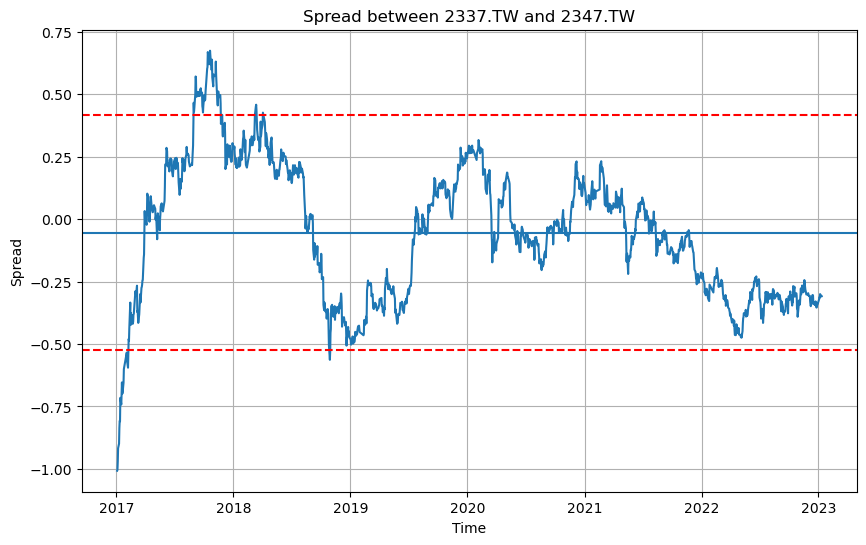

Statistics for the spread between 3406.TW and 9914.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

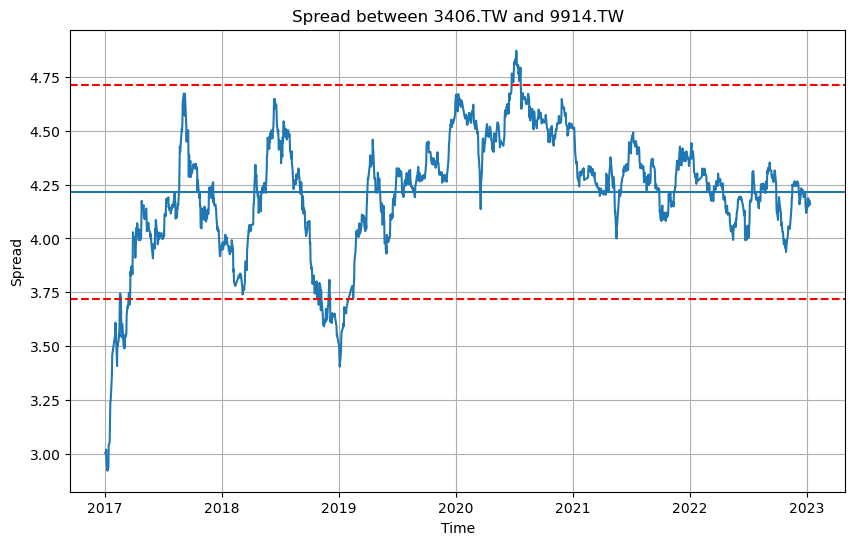

Statistics for the spread between 3406.TW and 3005.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

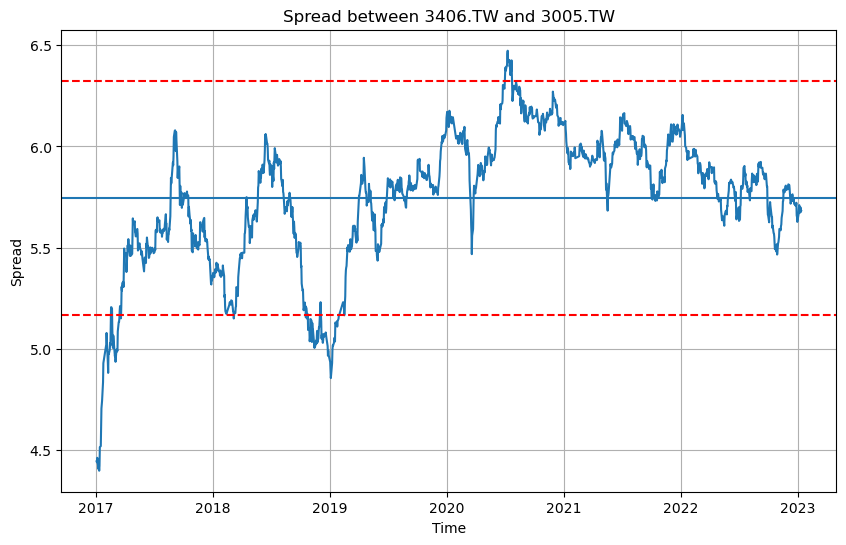

Statistics for the spread between 2392.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

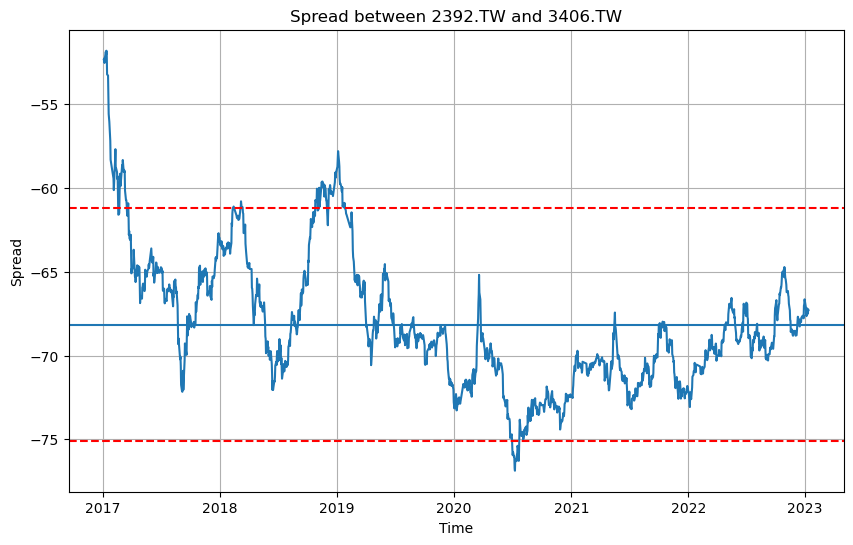

Statistics for the spread between 2337.TW and 2331.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

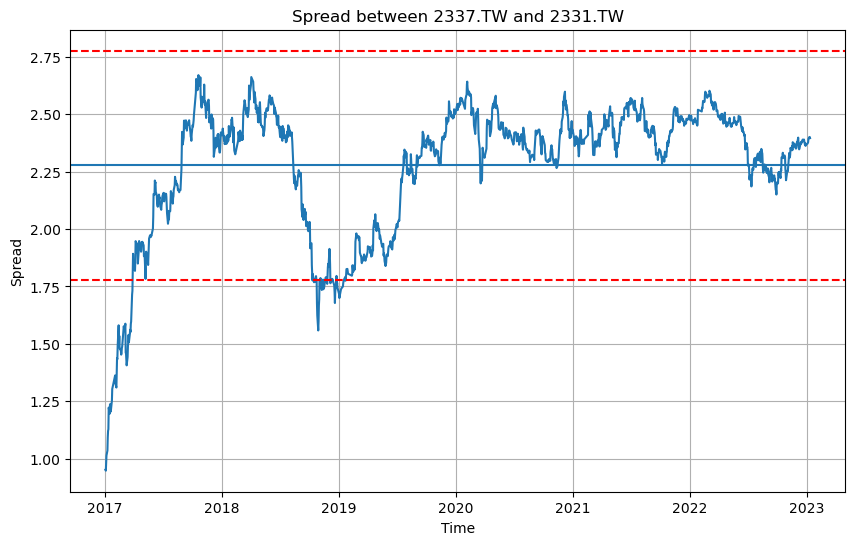

Statistics for the spread between 2337.TW and 6282.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

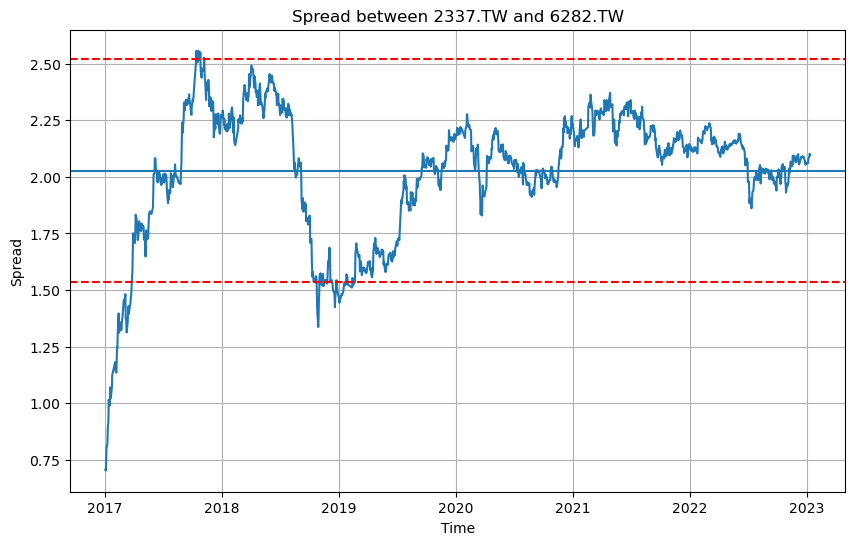

Statistics for the spread between 2337.TW and 3231.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

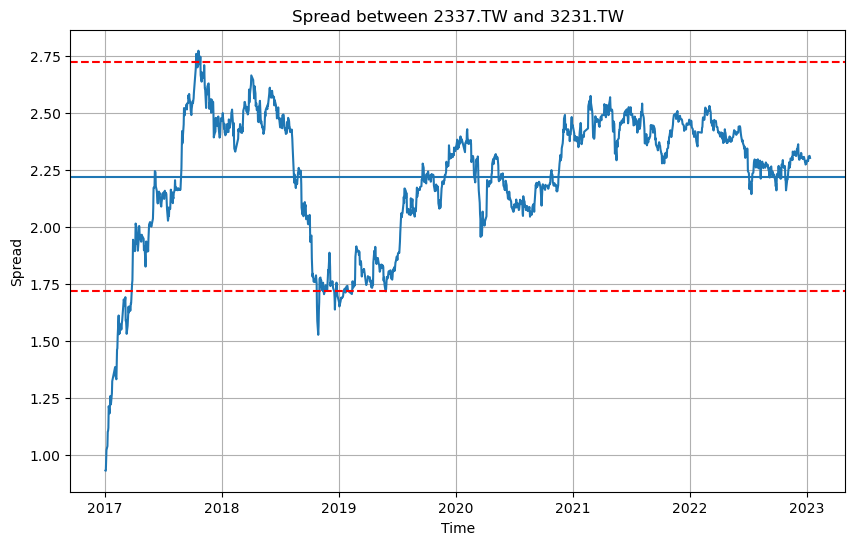

Statistics for the spread between 2337.TW and 2328.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

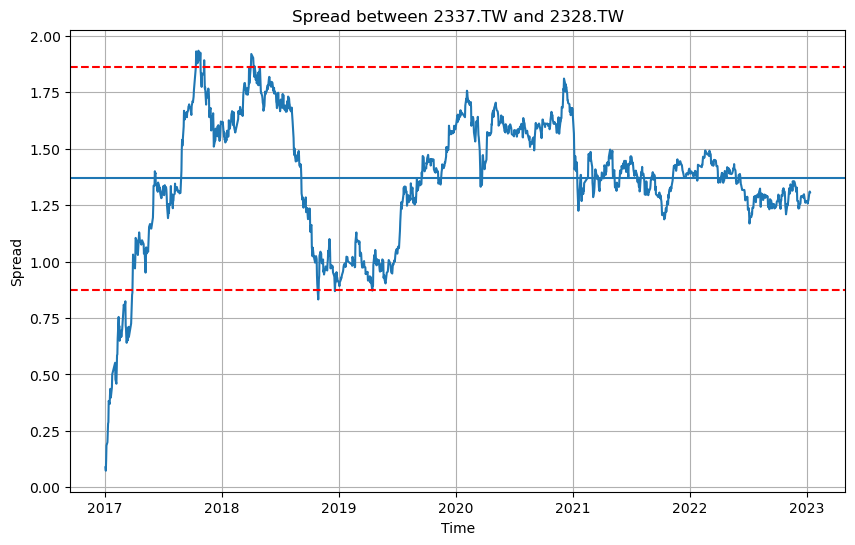

Statistics for the spread between 2337.TW and 1802.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

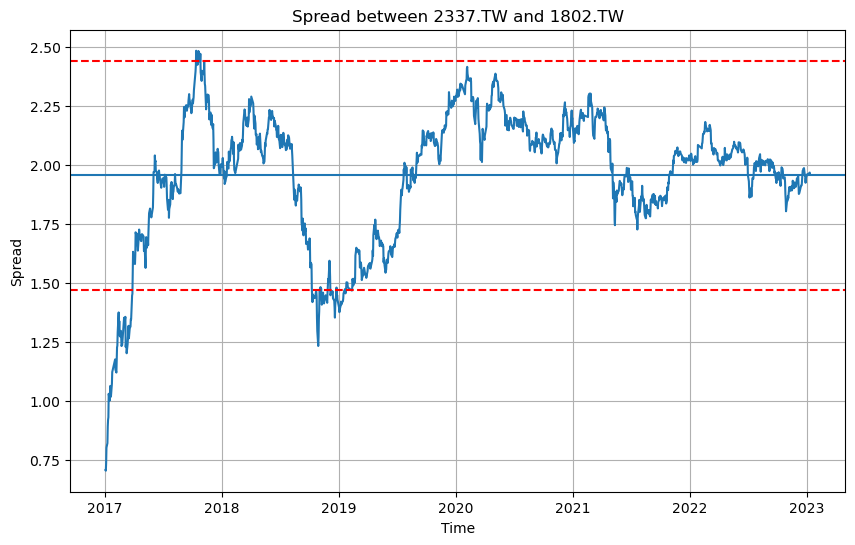

Statistics for the spread between 2337.TW and 3481.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

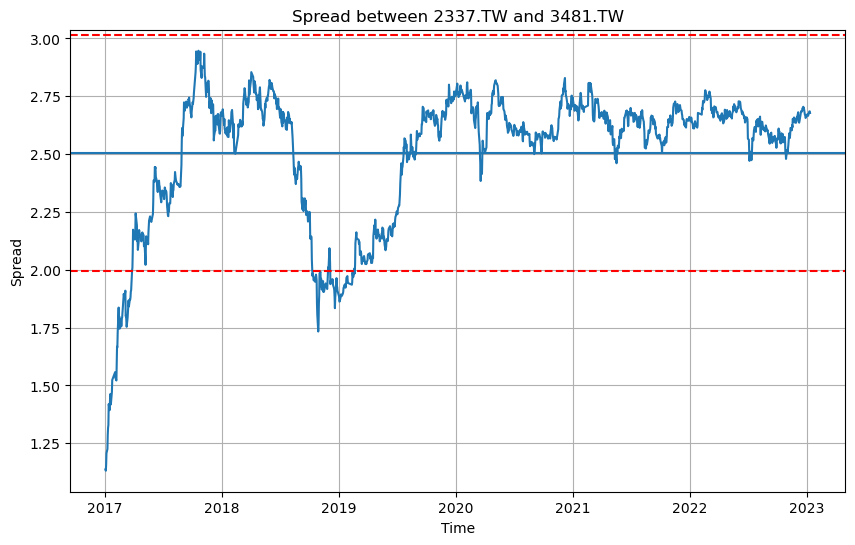

Statistics for the spread between 2337.TW and 1440.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

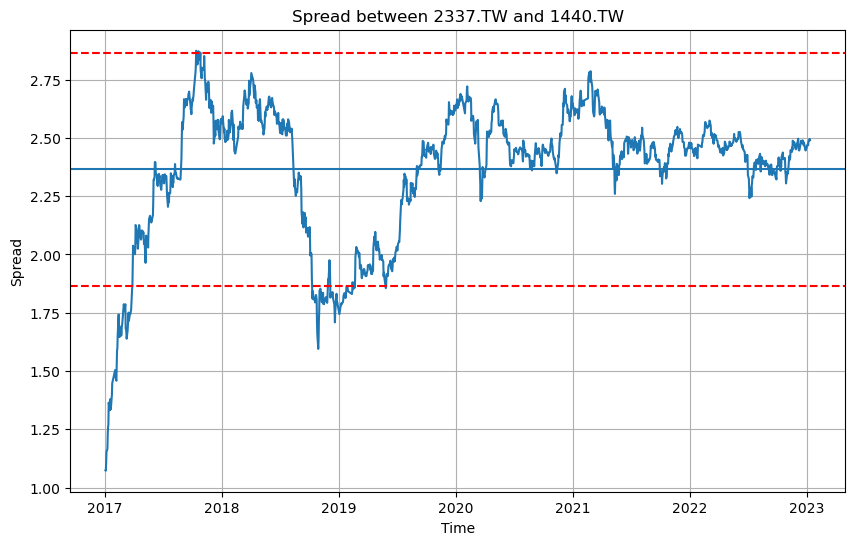

Statistics for the spread between 1303.TW and 2337.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

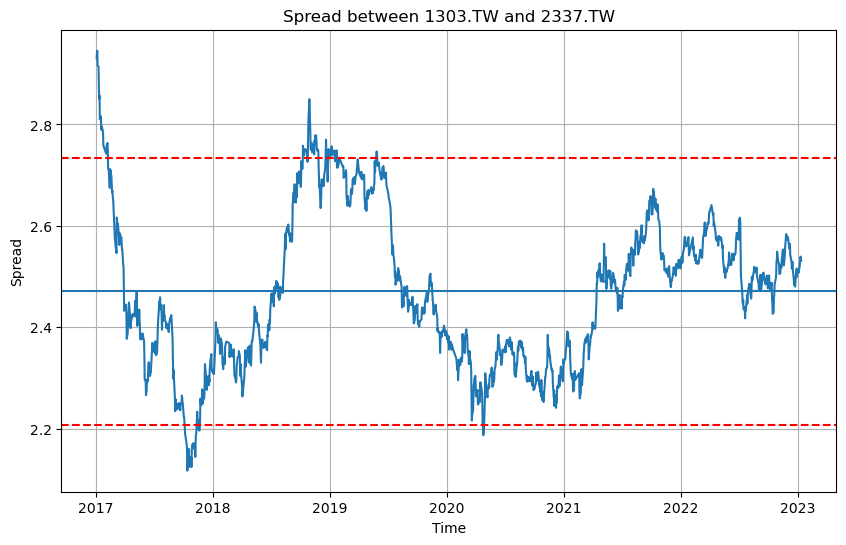

Statistics for the spread between 2337.TW and 9939.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

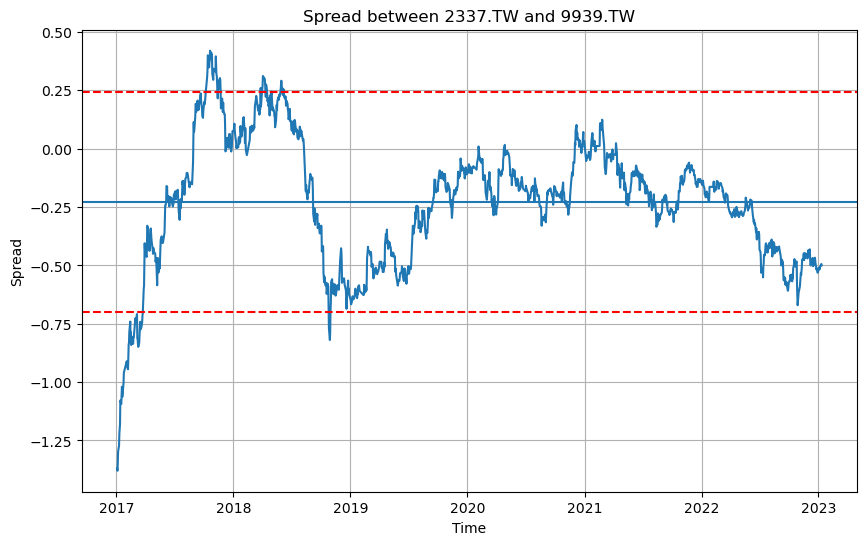

Statistics for the spread between 1504.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

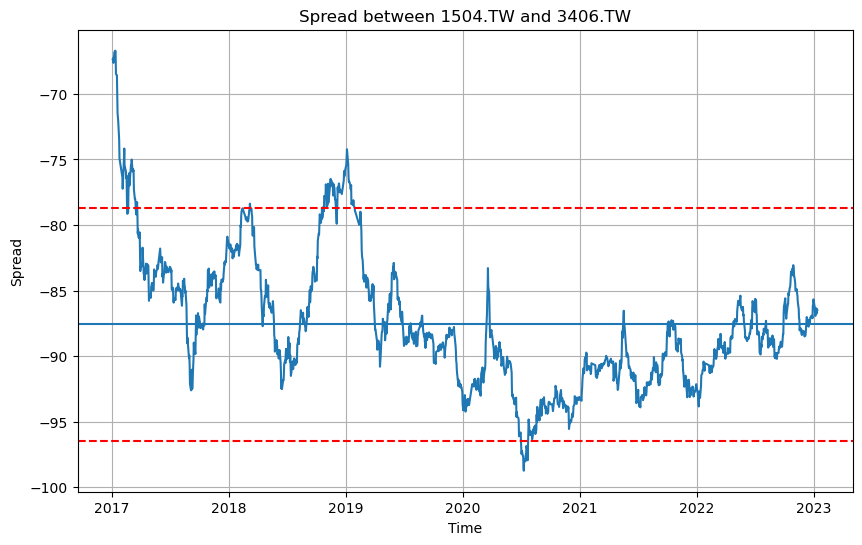

Statistics for the spread between 3406.TW and 1717.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

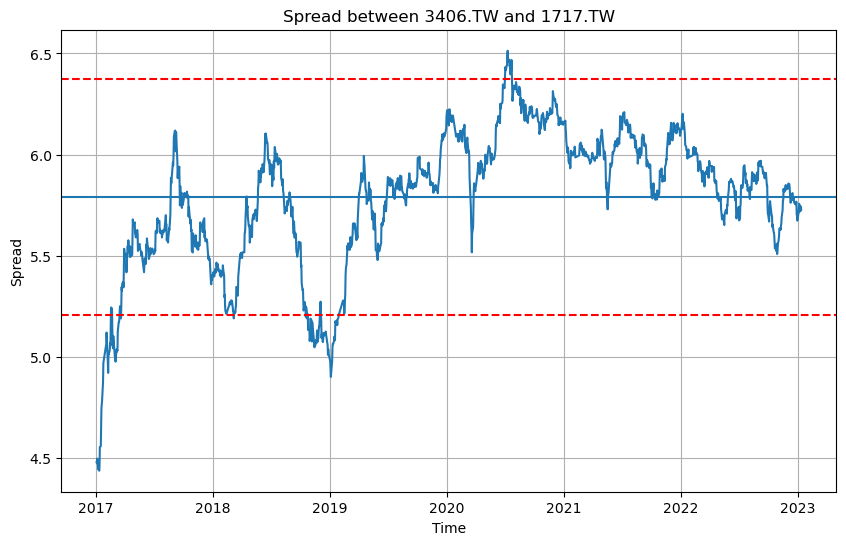

Statistics for the spread between 3406.TW and 0050.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

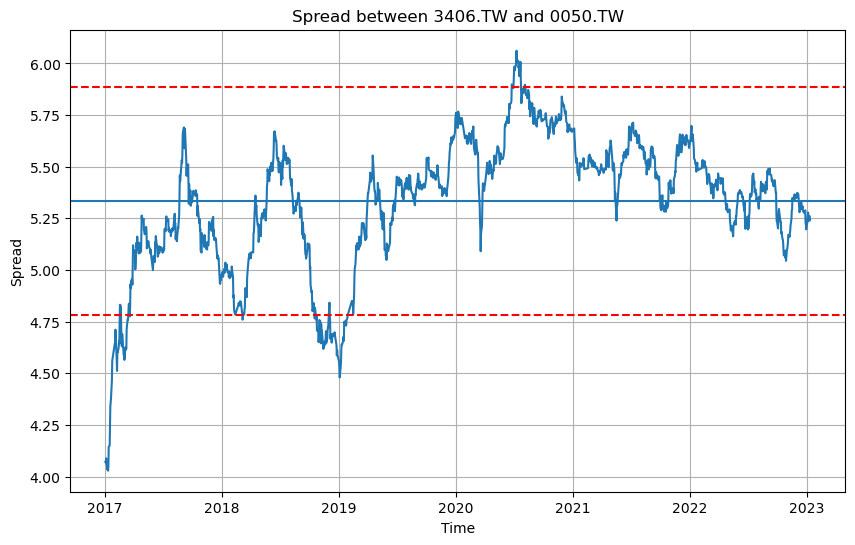

Statistics for the spread between 2337.TW and 2308.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

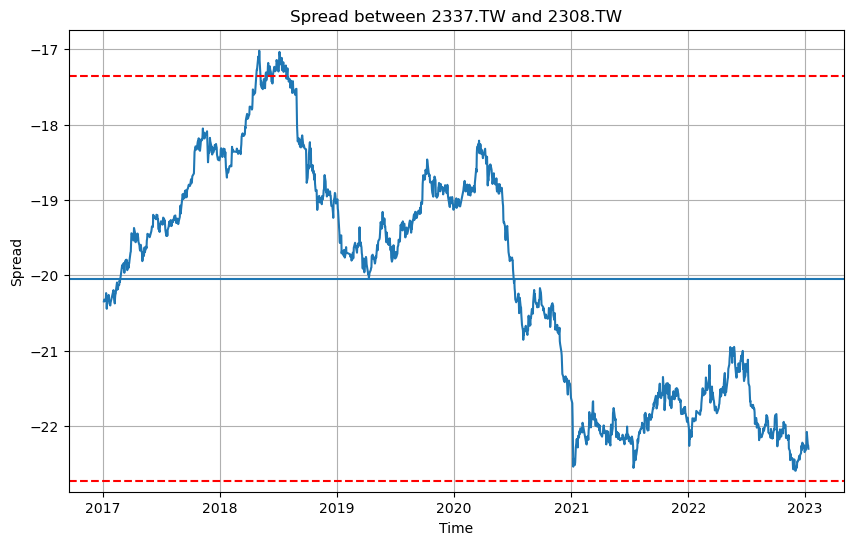

Statistics for the spread between 2882.TW and 2337.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

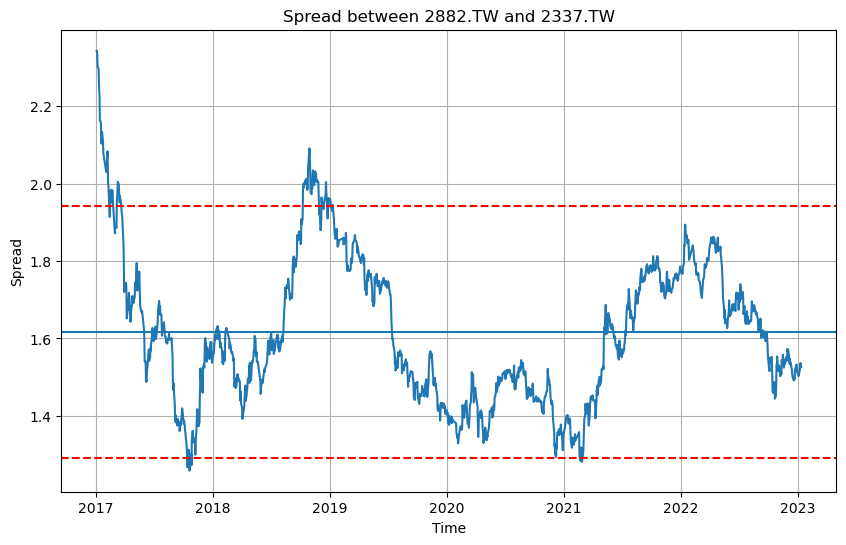

Statistics for the spread between 2337.TW and 9914.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

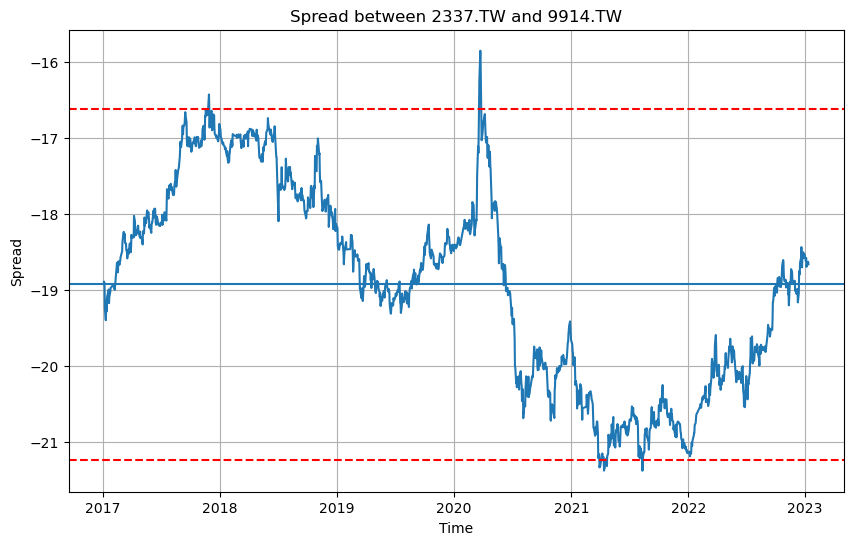

Statistics for the spread between 2337.TW and 2883.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

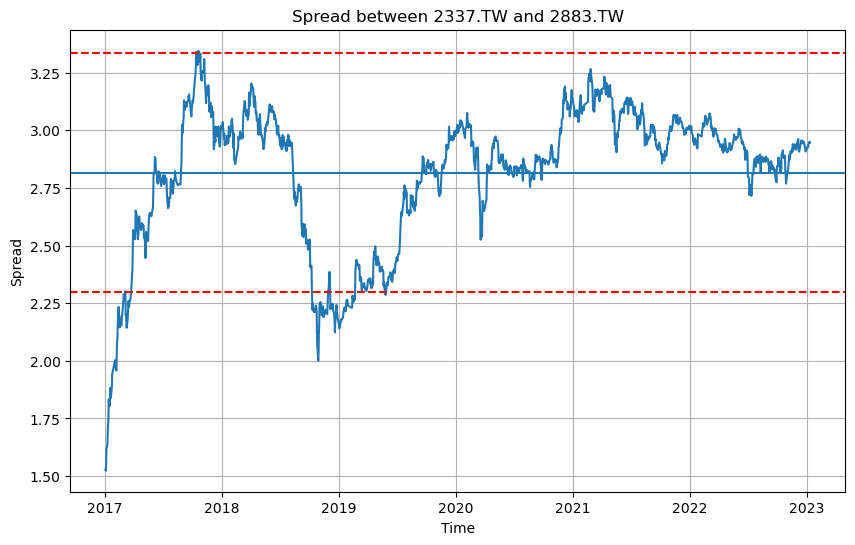

Statistics for the spread between 2888.TW and 2337.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

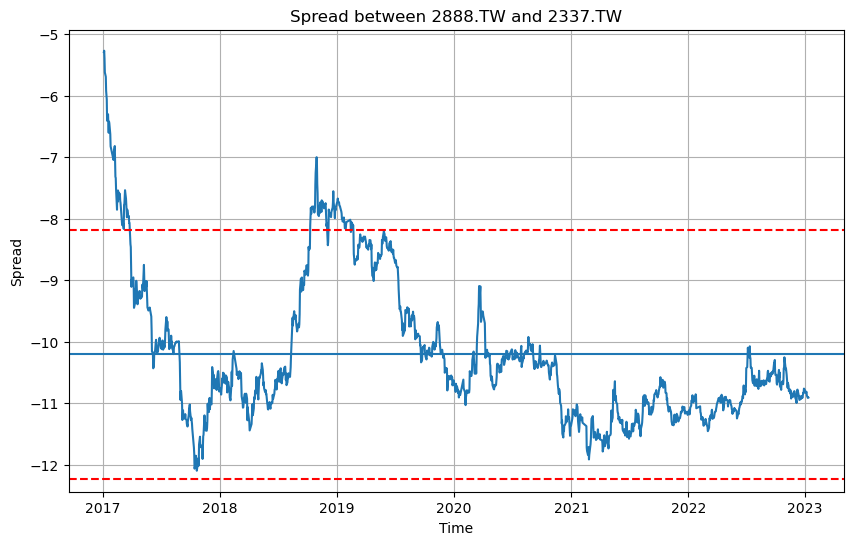

Statistics for the spread between 2337.TW and 2332.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0   2324.TW  3702.TW    0.231960  -4.516901        -4.110970        -4.922831   
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
2   1440.TW  2606.TW    0.443129  -4.972227        -4.196752        -5.747702   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
5   2312.TW  2542.TW    0.202891  -3.794896        -3.439838        -4.149954   
6   2312.TW  3005.TW    0.451604  -8.202356        -7.412049        -8.992663   
7   2605.TW  2328.TW    0.173945  -0.321805        -0.017400        -0.626209   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
9   2408.TW  2337.TW    0.136537   2.410253         2.649192         2.171314   
10  3406.TW  6269.TW    0.322775   5.441590         6

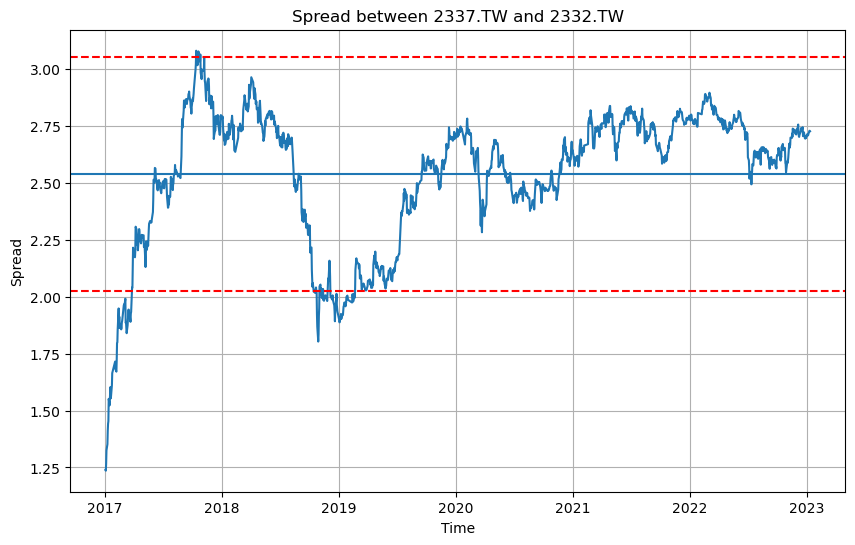

Statistics for the spread between 2801.TW and 3406.TW: 
   Ticker 1 Ticker 2  Volatility        Mean  90th Percentile  \
0   2324.TW  3702.TW    0.231960   -4.516901        -4.110970   
1   2881.TW  2606.TW    0.102180    0.285722         0.464537   
2   1440.TW  2606.TW    0.443129   -4.972227        -4.196752   
3   6271.TW  8150.TW    0.218731    4.221345         4.604123   
4   3231.TW  3380.TW    0.116567   -0.165654         0.038338   
5   2312.TW  2542.TW    0.202891   -3.794896        -3.439838   
6   2312.TW  3005.TW    0.451604   -8.202356        -7.412049   
7   2605.TW  2328.TW    0.173945   -0.321805        -0.017400   
8   3376.TW  3406.TW    1.465211  -23.933240       -21.369121   
9   2408.TW  2337.TW    0.136537    2.410253         2.649192   
10  3406.TW  6269.TW    0.322775    5.441590         6.006447   
11  8039.TW  3406.TW    4.939935  -85.278350       -76.633464   
12  3044.TW  3406.TW    1.359594  -22.353685       -19.974395   
13  2337.TW  8039.TW    0.259588  

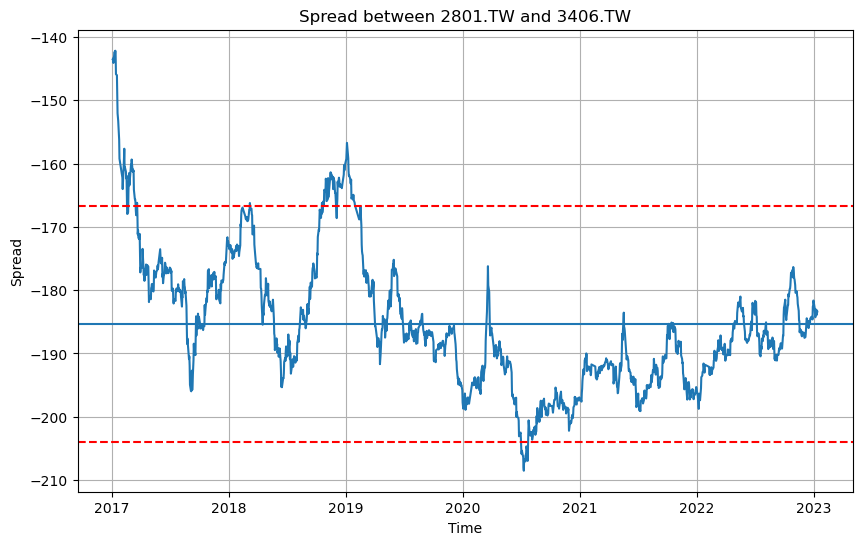

Statistics for the spread between 2337.TW and 2301.TW: 
   Ticker 1 Ticker 2  Volatility        Mean  90th Percentile  \
0   2324.TW  3702.TW    0.231960   -4.516901        -4.110970   
1   2881.TW  2606.TW    0.102180    0.285722         0.464537   
2   1440.TW  2606.TW    0.443129   -4.972227        -4.196752   
3   6271.TW  8150.TW    0.218731    4.221345         4.604123   
4   3231.TW  3380.TW    0.116567   -0.165654         0.038338   
5   2312.TW  2542.TW    0.202891   -3.794896        -3.439838   
6   2312.TW  3005.TW    0.451604   -8.202356        -7.412049   
7   2605.TW  2328.TW    0.173945   -0.321805        -0.017400   
8   3376.TW  3406.TW    1.465211  -23.933240       -21.369121   
9   2408.TW  2337.TW    0.136537    2.410253         2.649192   
10  3406.TW  6269.TW    0.322775    5.441590         6.006447   
11  8039.TW  3406.TW    4.939935  -85.278350       -76.633464   
12  3044.TW  3406.TW    1.359594  -22.353685       -19.974395   
13  2337.TW  8039.TW    0.259588  

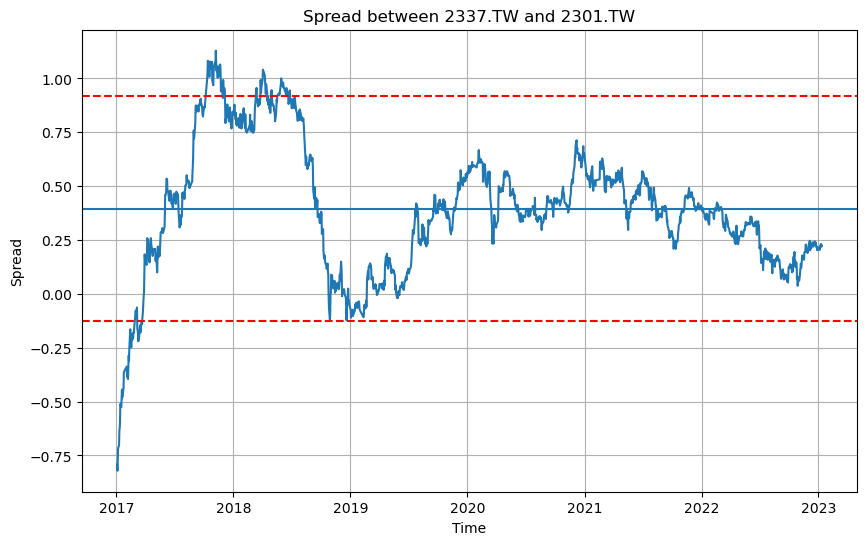

Statistics for the spread between 2337.TW and 2913.TW: 
   Ticker 1 Ticker 2  Volatility        Mean  90th Percentile  \
0   2324.TW  3702.TW    0.231960   -4.516901        -4.110970   
1   2881.TW  2606.TW    0.102180    0.285722         0.464537   
2   1440.TW  2606.TW    0.443129   -4.972227        -4.196752   
3   6271.TW  8150.TW    0.218731    4.221345         4.604123   
4   3231.TW  3380.TW    0.116567   -0.165654         0.038338   
5   2312.TW  2542.TW    0.202891   -3.794896        -3.439838   
6   2312.TW  3005.TW    0.451604   -8.202356        -7.412049   
7   2605.TW  2328.TW    0.173945   -0.321805        -0.017400   
8   3376.TW  3406.TW    1.465211  -23.933240       -21.369121   
9   2408.TW  2337.TW    0.136537    2.410253         2.649192   
10  3406.TW  6269.TW    0.322775    5.441590         6.006447   
11  8039.TW  3406.TW    4.939935  -85.278350       -76.633464   
12  3044.TW  3406.TW    1.359594  -22.353685       -19.974395   
13  2337.TW  8039.TW    0.259588  

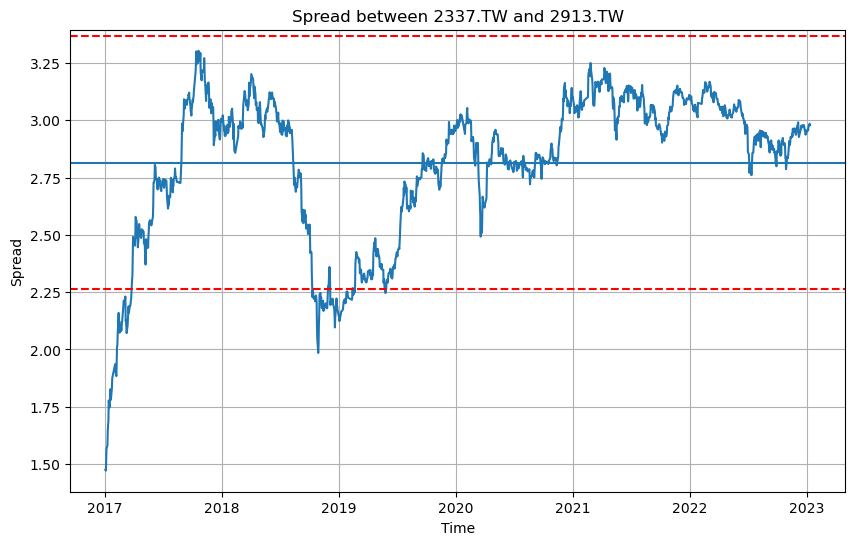

In [217]:
spread_calculator = Spread(merged_df)
Pairs = spread_calculator.calculate_spread_and_volatility(Pair)

In [218]:
Pairs

Ticker 1 Ticker 2  Volatility        Mean  90th Percentile  \
0   2324.TW  3702.TW    0.231960   -4.516901        -4.110970   
1   2881.TW  2606.TW    0.102180    0.285722         0.464537   
2   1440.TW  2606.TW    0.443129   -4.972227        -4.196752   
3   6271.TW  8150.TW    0.218731    4.221345         4.604123   
4   3231.TW  3380.TW    0.116567   -0.165654         0.038338   
5   2312.TW  2542.TW    0.202891   -3.794896        -3.439838   
6   2312.TW  3005.TW    0.451604   -8.202356        -7.412049   
7   2605.TW  2328.TW    0.173945   -0.321805        -0.017400   
8   3376.TW  3406.TW    1.465211  -23.933240       -21.369121   
9   2408.TW  2337.TW    0.136537    2.410253         2.649192   
10  3406.TW  6269.TW    0.322775    5.441590         6.006447   
11  8039.TW  3406.TW    4.939935  -85.278350       -76.633464   
12  3044.TW  3406.TW    1.359594  -22.353685       -19.974395   
13  2337.TW  8039.TW    0.259588    1.310591         1.764870   
14  2337.TW  2441.TW    0.240178   -1.199164        -0.778853   
15  2337.TW  2392.TW    0.262459    1.509425         1.968728   
16  2337.TW  2449.TW    0.235805    1.142587         1.555246   
17  6239.TW  3406.TW    2.220681  -36.665288       -32.779096   
18  3231.TW  3406.TW    5.698742  -99.398016       -89.425217   
19  2337.TW  6116.TW    0.254996    2.514102         2.960345   
20  3406.TW  4958.TW    0.308618    5.267940         5.808022   
21  2337.TW  0050.TW    0.468402   -6.615857        -5.796154   
22  2337.TW  3380.TW    0.256622    1.831654         2.280743   
23  2337.TW  2393.TW    0.260649    1.135747         1.591882   
24  2385.TW  3406.TW    2.179165  -36.310707       -32.497168   
25  3406.TW  3706.TW    0.332345    5.800523         6.382128   
26  2324.TW  2337.TW    0.397434   -2.219599        -1.524090   
27  2337.TW  8150.TW    0.255172    1.099332         1.545882   
28  2337.TW  6271.TW    0.686205  -11.939614       -10.738755   
29  2337.TW  6269.TW    0.235818   -1.985469        -1.572787   
30  2337.TW  4938.TW    0.272683    0.740043         1.217239   
31  2337.TW  3706.TW    0.285248    2.188519         2.687703   
32  2317.TW  2337.TW    0.168600    3.432035         3.727084   
33  2337.TW  2347.TW    0.269464   -0.054087         0.417474   
34  3406.TW  9914.TW    0.283681    4.214208         4.710649   
35  3406.TW  3005.TW    0.331293    5.745713         6.325476   
36  2392.TW  3406.TW    3.968999  -68.162153       -61.216405   
37  2337.TW  2331.TW    0.284997    2.278601         2.777347   
38  2337.TW  6282.TW    0.281344    2.027001         2.519353   
39  2337.TW  3231.TW    0.286125    2.222006         2.722725   
40  2337.TW  2328.TW    0.281681    1.368878         1.861819   
41  2337.TW  1802.TW    0.276785    1.955904         2.440278   
42  2337.TW  3481.TW    0.291384    2.506199         3.016121   
43  2337.TW  1440.TW    0.285957    2.364629         2.865054   
44  1303.TW  2337.TW    0.149848    2.470744         2.732978   
45  2337.TW  9939.TW    0.268459   -0.228567         0.241236   
46  1504.TW  3406.TW    5.074803  -87.562914       -78.682010   
47  3406.TW  1717.TW    0.333002    5.789768         6.372522   
48  3406.TW  0050.TW    0.316255    5.334294         5.887741   
49  2337.TW  2308.TW    1.535194  -20.044406       -17.357817   
50  2882.TW  2337.TW    0.186031    1.616601         1.942155   
51  2337.TW  9914.TW    1.321669  -18.923031       -16.610111   
52  2337.TW  2883.TW    0.296925    2.816506         3.336125   
53  2888.TW  2337.TW    1.160261  -10.208864        -8.178407   
54  2337.TW  2332.TW    0.294860    2.539479         3.055484   
55  2801.TW  3406.TW   10.673624 -185.347664      -166.668822   
56  2337.TW  2301.TW    0.298951    0.395958         0.919122   
57  2337.TW  2913.TW    0.315671    2.815128         3.367553   

    10th Percentile  Revert Time  
0         -4.922831    79.357143  
1          0.106908    49.214286  
2         -5.747702    78.344828  
3          3.838566    47.5

### Selection based on number of days holding trade

#### Another criteria I added in is that I want to hold this long-short pair and realize profit as quick as possible ideally. Hence, I would set a threshold of 60 days at most. 

In [221]:
Filtered_Pairs = Pairs[Pairs['Revert Time'] <60]

In [222]:
Filtered_Pairs

Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
1   2881.TW  2606.TW    0.102180   0.285722         0.464537         0.106908   
3   6271.TW  8150.TW    0.218731   4.221345         4.604123         3.838566   
4   3231.TW  3380.TW    0.116567  -0.165654         0.038338        -0.369646   
8   3376.TW  3406.TW    1.465211 -23.933240       -21.369121       -26.497358   
14  2337.TW  2441.TW    0.240178  -1.199164        -0.778853        -1.619476   
15  2337.TW  2392.TW    0.262459   1.509425         1.968728         1.050121   
27  2337.TW  8150.TW    0.255172   1.099332         1.545882         0.652782   
29  2337.TW  6269.TW    0.235818  -1.985469        -1.572787        -2.398151   
30  2337.TW  4938.TW    0.272683   0.740043         1.217239         0.262847   
33  2337.TW  2347.TW    0.269464  -0.054087         0.417474        -0.525649   
39  2337.TW  3231.TW    0.286125   2.222006         2.722725         1.721287   
40  2337.TW  2328.TW    0.281681   1.368878         1.861819         0.875936   
41  2337.TW  1802.TW    0.276785   1.955904         2.440278         1.471530   
43  2337.TW  1440.TW    0.285957   2.364629         2.865054         1.864204   

    Revert Time  
1     49.214286  
3     47.574468  
4     42.309091  
8     58.483871  
14    42.411765  
15    50.868421  
27    57.000000  
29    57.333333  
30    53.085714  
33    54.888889  
39    56.636364  
40    58.814815  
41    56.482759  
43    49.666667

### Calculate hedging ratio 

In [224]:
FPairs= Filtered_Pairs[['Ticker 1', 'Ticker 2']].apply(pd.Series)

In [225]:
FPairs=FPairs[['Ticker 1', 'Ticker 2']]

In [226]:
FPairs

Ticker 1 Ticker 2
1   2881.TW  2606.TW
3   6271.TW  8150.TW
4   3231.TW  3380.TW
8   3376.TW  3406.TW
14  2337.TW  2441.TW
15  2337.TW  2392.TW
27  2337.TW  8150.TW
29  2337.TW  6269.TW
30  2337.TW  4938.TW
33  2337.TW  2347.TW
39  2337.TW  3231.TW
40  2337.TW  2328.TW
41  2337.TW  1802.TW
43  2337.TW  1440.TW

In [227]:
import Hedge


# Now you can use the reloaded Hedge_ratio class
hedge_ratio_instance = Hedge.Hedge_ratio(FPairs, merged_df)
HR = hedge_ratio_instance.hedge(FPairs, merged_df)

In [228]:
HR

ticker1  ticker2       rsq  hedge ratio
1   2881.TW  2606.TW  0.893934          1.0
3   6271.TW  8150.TW  0.833033          1.0
4   3231.TW  3380.TW  0.809979          1.0
8   3376.TW  3406.TW  0.546856          1.0
14  2337.TW  2441.TW  0.553279          1.0
15  2337.TW  2392.TW  0.502226          1.0
27  2337.TW  8150.TW  0.389054          1.0
29  2337.TW  6269.TW  0.480002          1.0
30  2337.TW  4938.TW  0.389162          1.0
33  2337.TW  2347.TW  0.394700          1.0
39  2337.TW  3231.TW  0.361836          1.0
40  2337.TW  2328.TW  0.264340          1.0
41  2337.TW  1802.TW  0.280973          1.0
43  2337.TW  1440.TW  0.258433          1.0

### Backtest with signal 

#### Our signal will be when it hit the standard deviation then we will take position and unwind when it reaches the mean.

#### Assumption
1. Our price will be closing price
2. Not considering transaction cost
3. No borrowing cost consider might use SSF in TW to carry out this trade, assuming SSF same price and closing price 

In [231]:
from Backtest import Backtest

2881.TW    Spread Signal    2606.TW  2881.TW's trade  \
Date                                                                 
2017-01-03  28.938147  0.617221   Sell  17.336966        -144201.0   
2017-01-04  28.769245  0.615213   Sell  17.267893        -144777.0   
2017-01-05  28.938147  0.628803   Sell  17.129751        -145945.0   
2017-01-06  29.050747  0.617275   Sell  17.406036        -143628.0   
2017-01-09  29.107050  0.624962   Sell  17.302427        -144488.0   
...               ...       ...    ...        ...              ...   
2023-01-05  50.319481  0.314469    NaN  42.161247              0.0   
2023-01-06  50.319481  0.324815    NaN  41.710808              0.0   
2023-01-09  51.265656  0.308711    NaN  43.242306              0.0   
2023-01-10  50.921593  0.318166    NaN  42.521603              0.0   
2023-01-11  49.975418  0.288251    NaN  43.017086              0.0   

            2606.TW's trade  2881.TW's position  2606.TW's position  \
Date                                                                  
2017-01-03         144201.0           -144201.0            144201.0   
2017-01-04         144777.0           -288978.0            288978.0   
2017-01-05         145945.0           -434923.0            434923.0   
2017-01-06         143628.0           -578551.0            578551.0   
2017-01-09         144488.0           -723039.0            723039.0   
...                     ...                 ...                 ...   
2023-01-05              0.0          -1573381.0           1573381.0   
2023-01-06              0.0          -1573381.0           1573381.0   
2023-01-09              0.0          -1573381.0           1573381.0   
2023-01-10              0.0          -1573381.0           1573381.0   
2023-01-11              0.0          -1573381.0           1573381.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  6.672902e+06 -1.672902e+06     5.000000e+06  
2017-01-04  8.338033e+06 -3.323638e+06     5.014395e+06  
2017-01-05  1.006141e+07 -5.135743e+06     4.925667e+06  
2017-01-06  1.173392e+07 -6.737059e+06     4.996857e+06  
2017-01-09  1.343954e+07 -8.535203e+06     4.904340e+06  
...                  ...           ...              ...  
2023-01-05  8.076409e+07 -1.283601e+07     6.792808e+07  
2023-01-06  8.076409e+07 -1.354472e+07     6.721937e+07  
2023-01-09  8.076409e+07 -1.262379e+07     6.814031e+07  
2023-01-10  8.076409e+07 -1.321638e+07     6.754771e+07  
2023-01-11  8.076409e+07 -1.094811e+07     6.981599e+07  

[1472 rows x 11 columns]

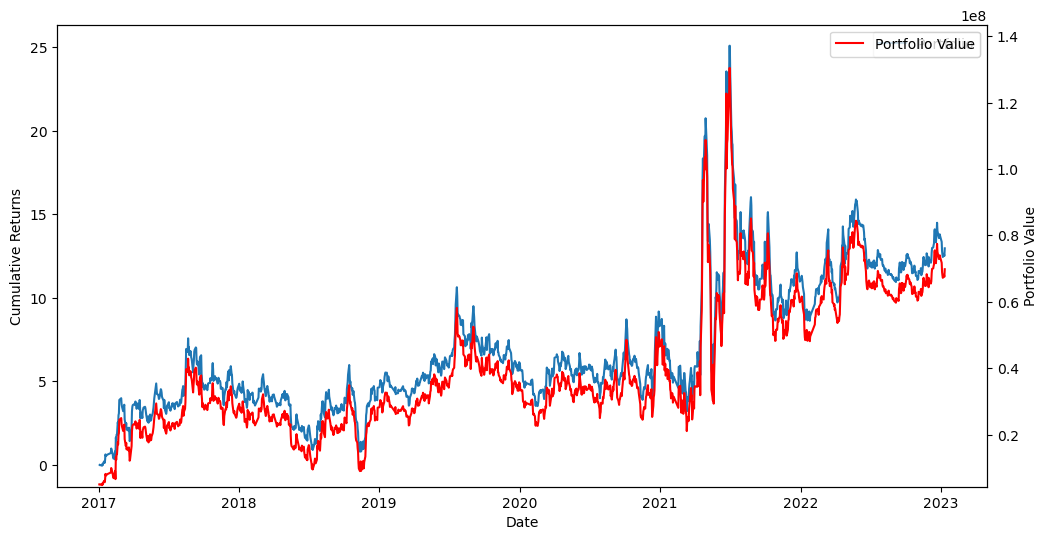

Sharpe Ratio: 0.928
CAGR: 54.90%
max drawdown: -1612.84%


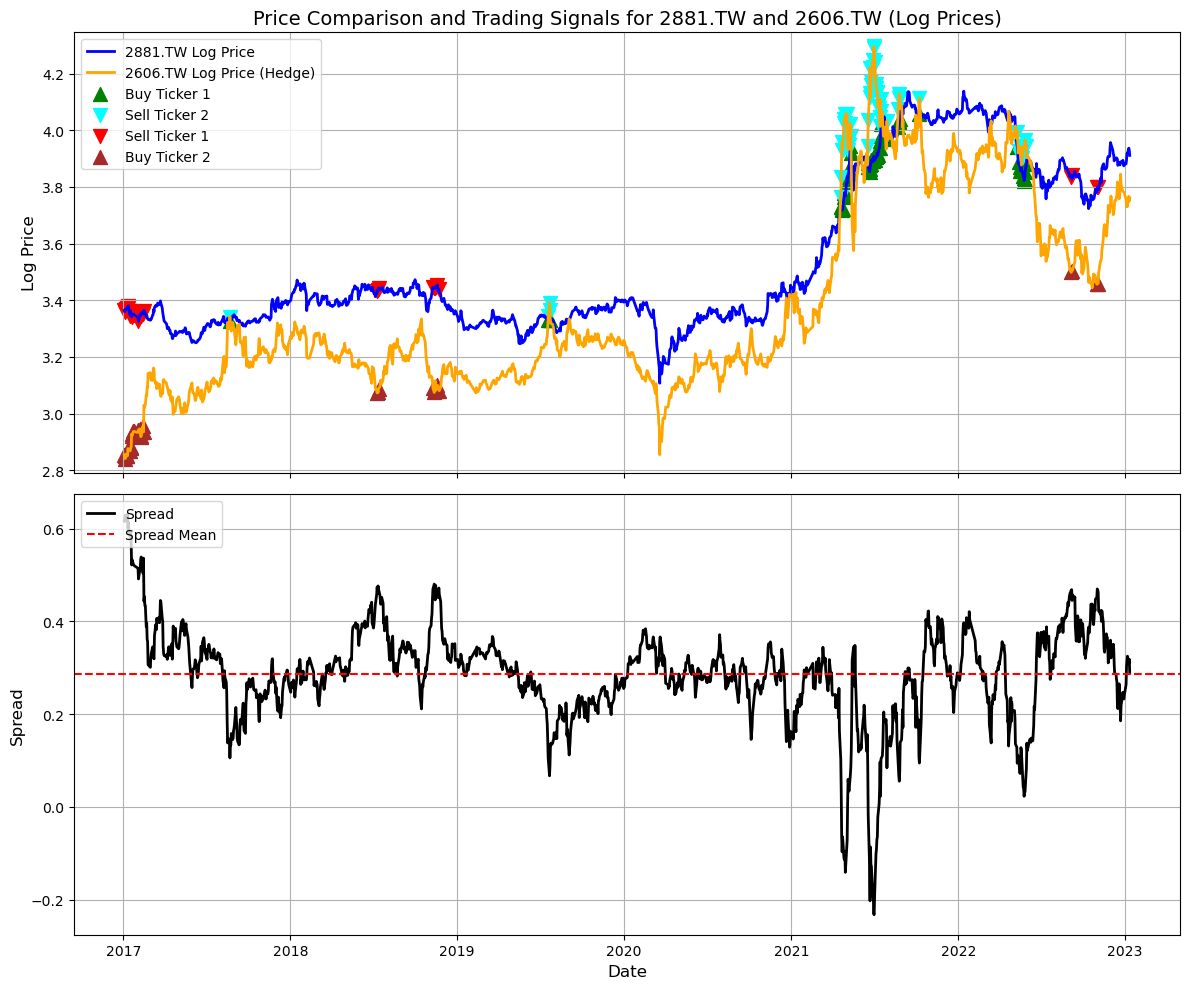

6271.TW    Spread Signal    8150.TW  6271.TW's trade  \
Date                                                                  
2017-01-03   89.559746  3.924254    NaN  18.956898              0.0   
2017-01-04   92.036057  3.954695    NaN  18.649900              0.0   
2017-01-05   90.385185  3.929926    NaN  19.302263              0.0   
2017-01-06   90.385185  3.922364    NaN  20.069752              0.0   
2017-01-09   88.321594  3.901881    NaN  19.801132              0.0   
...                ...       ...    ...        ...              ...   
2023-01-05  146.515701  4.327806    NaN  29.944792              0.0   
2023-01-06  148.691681  4.341381    NaN  30.125452              0.0   
2023-01-09  149.417007  4.344223    NaN  30.441612              0.0   
2023-01-10  151.592987  4.358106    NaN  30.531940              0.0   
2023-01-11  151.230316  4.355711    NaN  30.531940              0.0   

            8150.TW's trade  6271.TW's position  8150.TW's position  \
Date                                                                  
2017-01-03              0.0                 0.0                 0.0   
2017-01-04              0.0                 0.0                 0.0   
2017-01-05              0.0                 0.0                 0.0   
2017-01-06              0.0                 0.0                 0.0   
2017-01-09              0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
2023-01-05              0.0          -4525992.0           4525992.0   
2023-01-06              0.0          -4525992.0           4525992.0   
2023-01-09              0.0          -4525992.0           4525992.0   
2023-01-10              0.0          -4525992.0           4525992.0   
2023-01-11              0.0          -4525992.0           4525992.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  5.000000e+06  0.000000e+00     5.000000e+06  
2017-01-04  5.000000e+06  0.000000e+00     5.000000e+06  
2017-01-05  5.000000e+06  0.000000e+00     5.000000e+06  
2017-01-06  5.000000e+06  0.000000e+00     5.000000e+06  
2017-01-09  5.000000e+06  0.000000e+00     5.000000e+06  
...                  ...           ...              ...  
2023-01-05  9.683381e+08 -5.275990e+08     4.407390e+08  
2023-01-06  9.683381e+08 -5.366298e+08     4.317082e+08  
2023-01-09  9.683381e+08 -5.384817e+08     4.298564e+08  
2023-01-10  9.683381e+08 -5.479213e+08     4.204167e+08  
2023-01-11  9.683381e+08 -5.462799e+08     4.220582e+08  

[1472 rows x 11 columns]

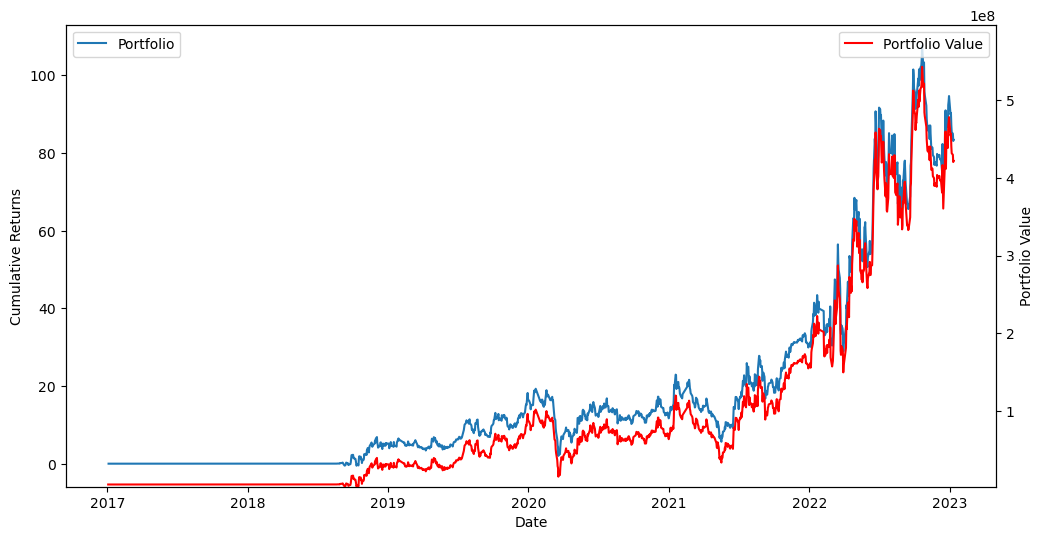

Sharpe Ratio: 1.065
CAGR: 108.81%
max drawdown: nan%


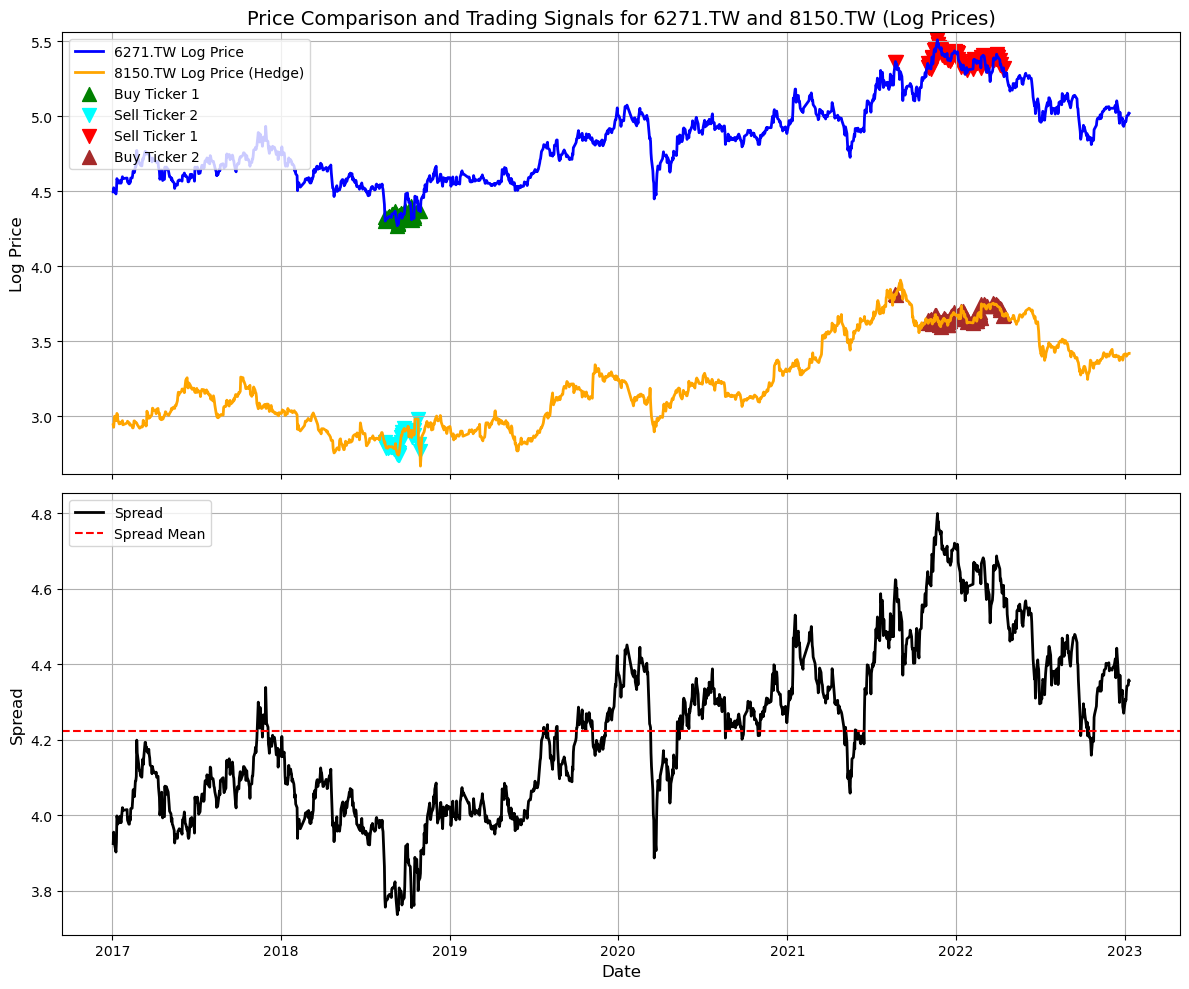

3231.TW    Spread Signal    3380.TW  3231.TW's trade  \
Date                                                                 
2017-01-03  15.547925 -0.093836    NaN  14.974224              0.0   
2017-01-04  15.392447 -0.114320    NaN  15.123965              0.0   
2017-01-05  15.205870 -0.147076    NaN  15.423450              0.0   
2017-01-06  15.610118 -0.115735    NaN  15.348577              0.0   
2017-01-09  15.547925 -0.091211    NaN  14.936788              0.0   
...               ...       ...    ...        ...              ...   
2023-01-05  28.090117 -0.149541    NaN  27.758734              0.0   
2023-01-06  27.899673 -0.152795    NaN  27.664953              0.0   
2023-01-09  28.566219 -0.139795    NaN  27.946291              0.0   
2023-01-10  28.709051 -0.143567    NaN  28.180740              0.0   
2023-01-11  28.851881 -0.138604    NaN  28.180740              0.0   

            3380.TW's trade  3231.TW's position  3380.TW's position  \
Date                                                                  
2017-01-03              0.0                 0.0                 0.0   
2017-01-04              0.0                 0.0                 0.0   
2017-01-05              0.0                 0.0                 0.0   
2017-01-06              0.0                 0.0                 0.0   
2017-01-09              0.0                 0.0                 0.0   
...                     ...                 ...                 ...   
2023-01-05              0.0           2374297.0          -2374297.0   
2023-01-06              0.0           2374297.0          -2374297.0   
2023-01-09              0.0           2374297.0          -2374297.0   
2023-01-10              0.0           2374297.0          -2374297.0   
2023-01-11              0.0           2374297.0          -2374297.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  5.000000e+06  0.000000e+00     5.000000e+06  
2017-01-04  5.000000e+06  0.000000e+00     5.000000e+06  
2017-01-05  5.000000e+06  0.000000e+00     5.000000e+06  
2017-01-06  5.000000e+06  0.000000e+00     5.000000e+06  
2017-01-09  5.000000e+06  0.000000e+00     5.000000e+06  
...                  ...           ...              ...  
2023-01-05  6.569765e+07  7.868011e+05     6.648445e+07  
2023-01-06  6.569765e+07  5.572955e+05     6.625494e+07  
2023-01-09  6.569765e+07  1.471894e+06     6.716954e+07  
2023-01-10  6.569765e+07  1.254367e+06     6.695202e+07  
2023-01-11  6.569765e+07  1.593487e+06     6.729114e+07  

[1472 rows x 11 columns]

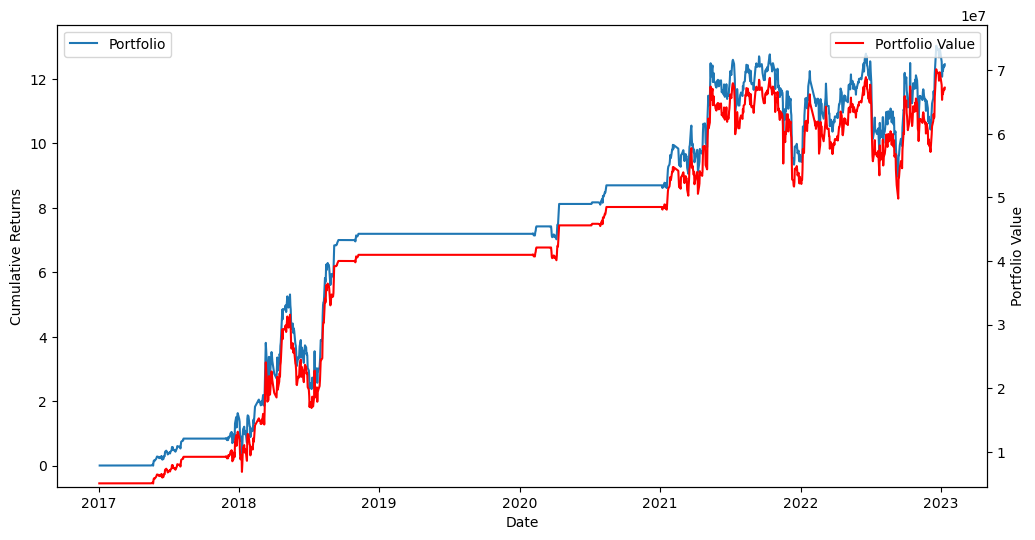

Sharpe Ratio: 1.057
CAGR: 53.96%
max drawdown: nan%


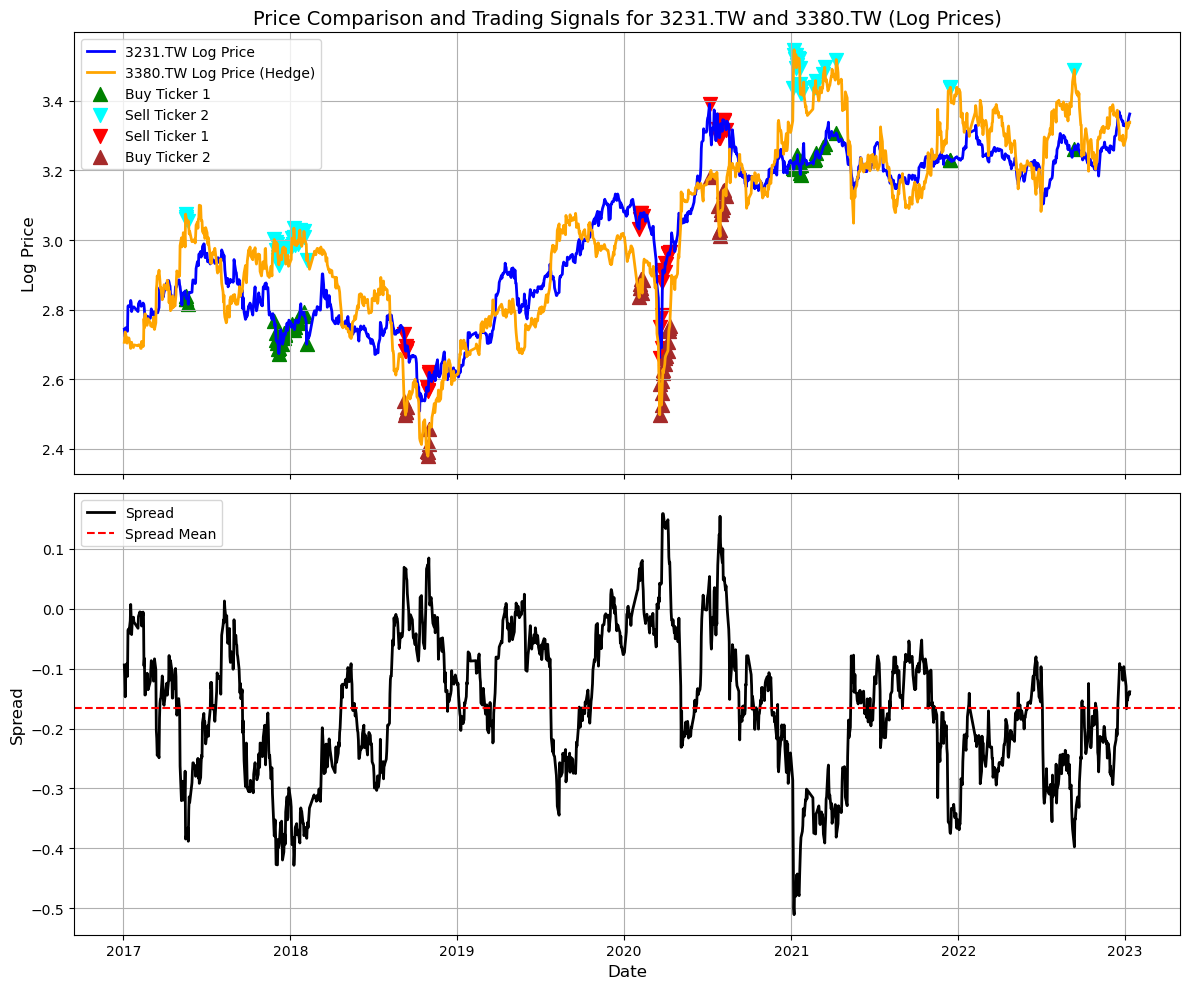

3376.TW     Spread Signal     3406.TW  3376.TW's trade  \
Date                                                                   
2017-01-03  60.442791 -17.887219   Sell   95.898933         -26069.0   
2017-01-04  60.442791 -17.865164   Sell   95.461021         -26189.0   
2017-01-05  61.686764 -17.954064   Sell   97.650513         -25602.0   
2017-01-06  61.467243 -17.848357   Sell   95.461021         -26189.0   
2017-01-09  60.955021 -17.699460   Sell   92.395760         -27058.0   
...               ...        ...    ...         ...              ...   
2023-01-05  75.158844 -23.858129    NaN  346.416473              0.0   
2023-01-06  75.158844 -23.669402    NaN  333.111023              0.0   
2023-01-09  76.076530 -23.792821    NaN  342.614899              0.0   
2023-01-10  75.525917 -23.691948    NaN  335.011810              0.0   
2023-01-11  75.158844 -23.724082    NaN  336.912567              0.0   

            3406.TW's trade  3376.TW's position  3406.TW's position  \
Date                                                                  
2017-01-03          26069.0            -26069.0             26069.0   
2017-01-04          26189.0            -52258.0             52258.0   
2017-01-05          25602.0            -77860.0             77860.0   
2017-01-06          26189.0           -104049.0            104049.0   
2017-01-09          27058.0           -131107.0            131107.0   
...                     ...                 ...                 ...   
2023-01-05              0.0          -1549265.0           1549265.0   
2023-01-06              0.0          -1549265.0           1549265.0   
2023-01-09              0.0          -1549265.0           1549265.0   
2023-01-10              0.0          -1549265.0           1549265.0   
2023-01-11              0.0          -1549265.0           1549265.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  4.075694e+06  9.243062e+05     5.000000e+06  
2017-01-04  3.158601e+06  1.829983e+06     4.988584e+06  
2017-01-05  2.237857e+06  2.800137e+06     5.037995e+06  
2017-01-06  1.347594e+06  3.537019e+06     4.884613e+06  
2017-01-09  4.968709e+05  4.122101e+06     4.618972e+06  
...                  ...           ...              ...  
2023-01-05 -2.693989e+07  4.202500e+08     3.933101e+08  
2023-01-06 -2.693989e+07  3.996363e+08     3.726964e+08  
2023-01-09 -2.693989e+07  4.129386e+08     3.859987e+08  
2023-01-10 -2.693989e+07  4.020124e+08     3.750725e+08  
2023-01-11 -2.693989e+07  4.055259e+08     3.785860e+08  

[1472 rows x 11 columns]

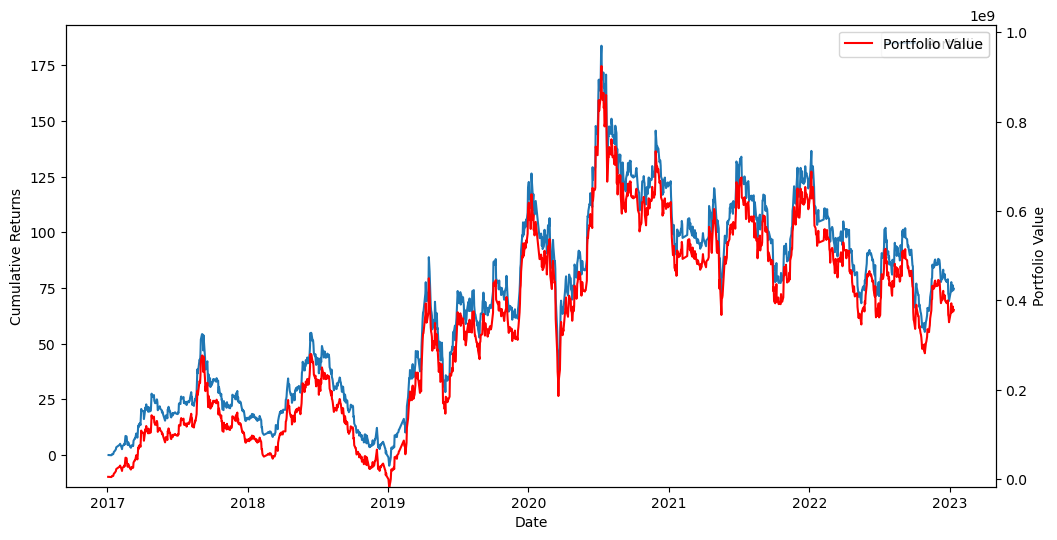

Sharpe Ratio: -0.284
CAGR: 105.08%
max drawdown: -1412.01%


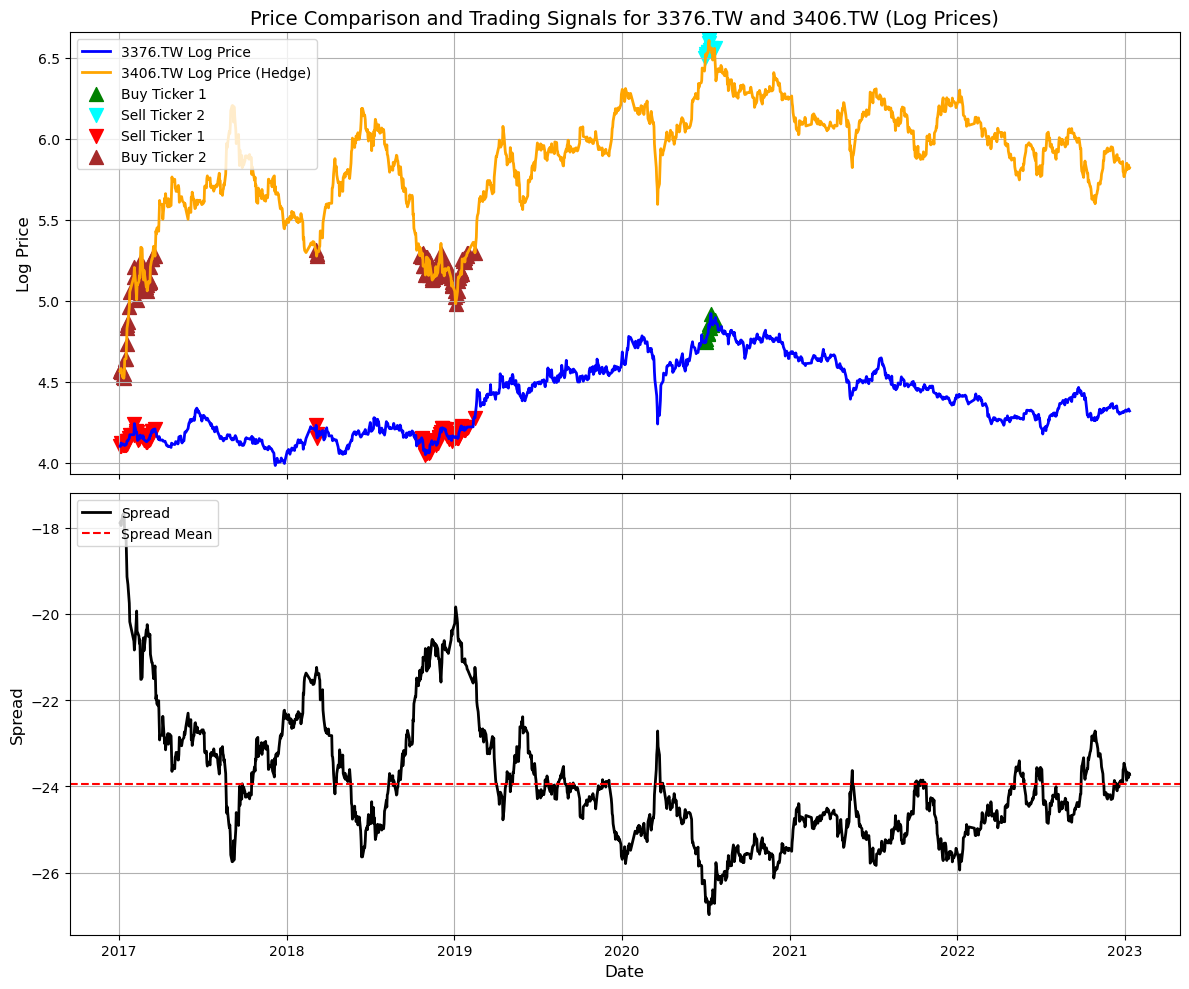

2337.TW    Spread Signal    2441.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662626 -2.004877    Buy  24.955185         375227.0   
2017-01-04   6.633657 -2.002967    Buy  24.826551         376866.0   
2017-01-05   6.879884 -1.975910    Buy  25.019506         363378.0   
2017-01-06   7.299920 -1.913527    Buy  24.955185         342470.0   
2017-01-09   7.415792 -1.916388    Buy  25.341091         337118.0   
...               ...       ...    ...        ...              ...   
2023-01-05  31.845282 -1.101573    NaN  43.043026              0.0   
2023-01-06  32.357414 -1.100746    NaN  43.583317              0.0   
2023-01-09  32.776432 -1.094128    NaN  43.808437              0.0   
2023-01-10  32.776432 -1.102821    NaN  44.123604              0.0   
2023-01-11  32.590202 -1.115921    NaN  44.393745              0.0   

            2441.TW's trade  2337.TW's position  2441.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2023-01-05              0.0           4876167.0          -4876167.0   
2023-01-06              0.0           4876167.0          -4876167.0   
2023-01-09              0.0           4876167.0          -4876167.0   
2023-01-10              0.0           4876167.0          -4876167.0   
2023-01-11              0.0           4876167.0          -4876167.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  1.186386e+07 -6.863862e+06     5.000000e+06  
2017-01-04  1.872015e+07 -1.368275e+07     5.037397e+06  
2017-01-05  2.531168e+07 -2.023422e+07     5.077462e+06  
2017-01-06  3.135808e+07 -2.574033e+07     5.617749e+06  
2017-01-09  3.740102e+07 -3.217697e+07     5.224056e+06  
...                  ...           ...              ...  
2023-01-05  2.280670e+08 -5.460207e+07     1.734649e+08  
2023-01-06  2.280670e+08 -5.473938e+07     1.733276e+08  
2023-01-09  2.280670e+08 -5.379390e+07     1.742731e+08  
2023-01-10  2.280670e+08 -5.533070e+07     1.727363e+08  
2023-01-11  2.280670e+08 -5.755605e+07     1.705109e+08  

[1472 rows x 11 columns]

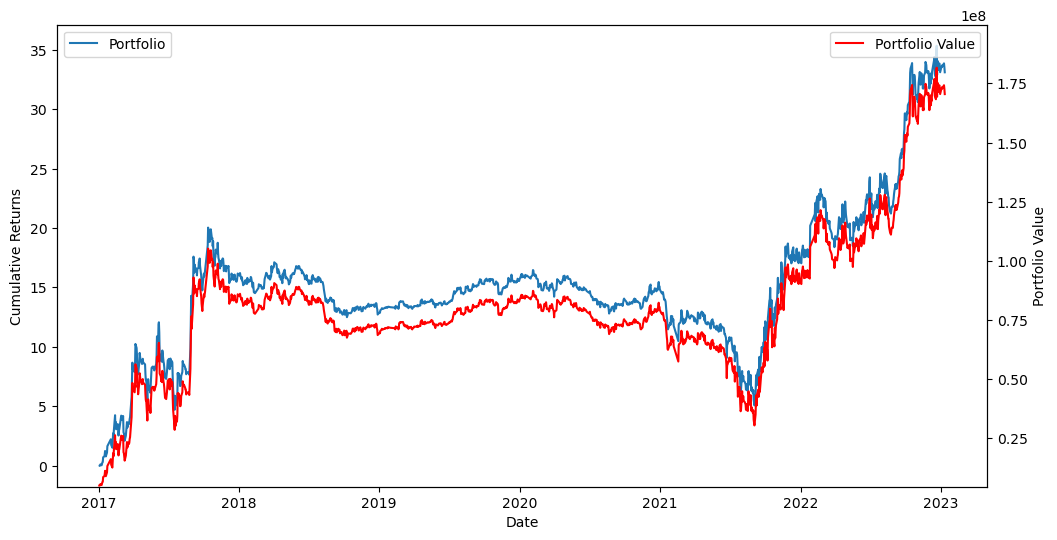

Sharpe Ratio: 1.186
CAGR: 79.65%
max drawdown: -74.63%


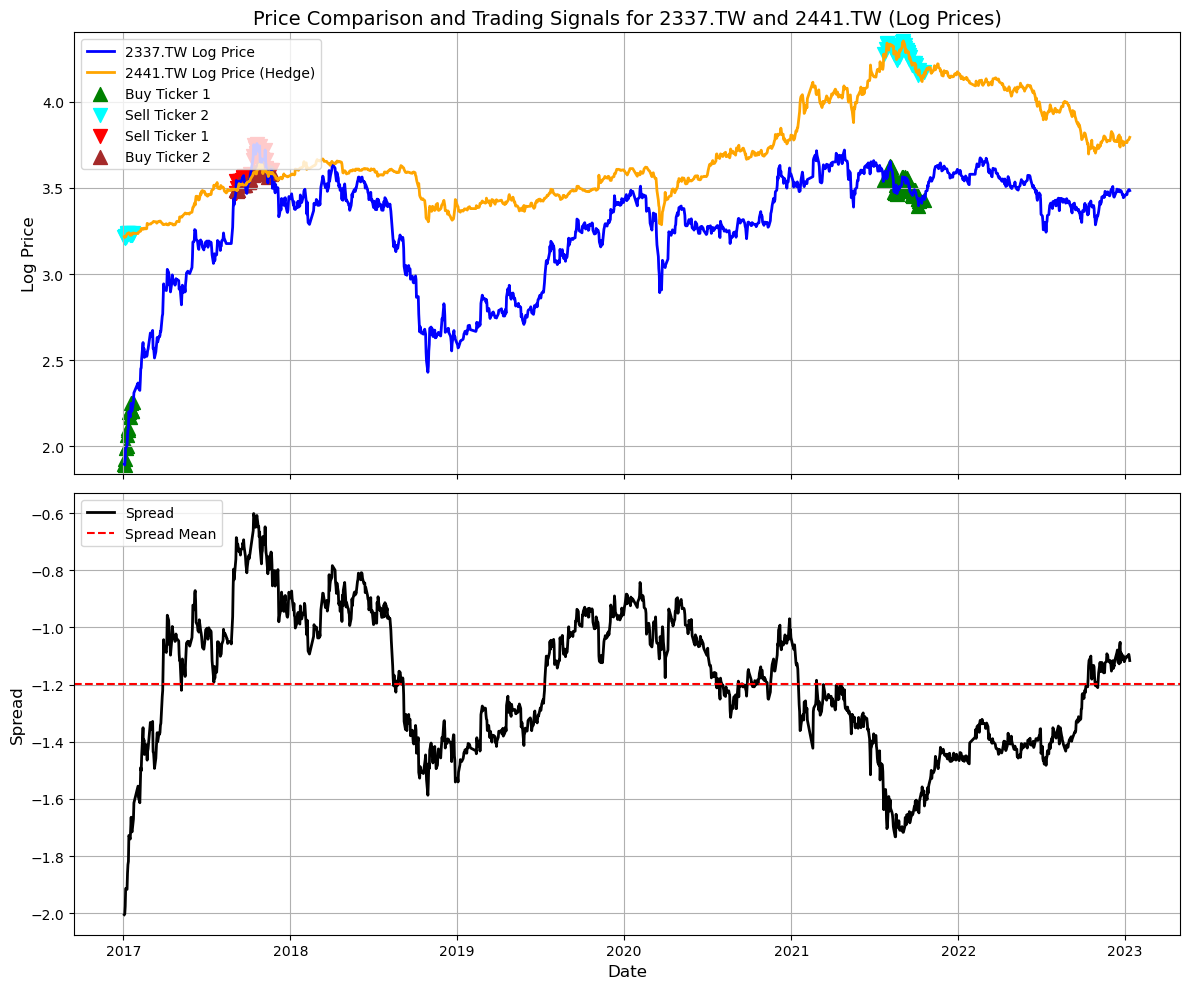

2337.TW    Spread Signal    2392.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662626  0.213434    Buy  25.158491         375227.0   
2017-01-04   6.633657  0.207662    Buy  25.226768         376866.0   
2017-01-05   6.879884  0.241993    Buy  25.329172         363378.0   
2017-01-06   7.299920  0.304076    Buy  25.192629         342470.0   
2017-01-09   7.415792  0.320532    Buy  25.158491         337118.0   
...               ...       ...    ...        ...              ...   
2023-01-05  31.845282  1.614255    NaN  34.418873              0.0   
2023-01-06  32.357414  1.630912    NaN  34.372547              0.0   
2023-01-09  32.776432  1.640973    NaN  34.557842              0.0   
2023-01-10  32.776432  1.638182    NaN  34.743141              0.0   
2023-01-11  32.590202  1.632484    NaN  34.743141              0.0   

            2392.TW's trade  2337.TW's position  2392.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2023-01-05              0.0          16753687.0         -16753687.0   
2023-01-06              0.0          16753687.0         -16753687.0   
2023-01-09              0.0          16753687.0         -16753687.0   
2023-01-10              0.0          16753687.0         -16753687.0   
2023-01-11              0.0          16753687.0         -16753687.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  1.194015e+07 -6.940148e+06     5.000000e+06  
2017-01-04  1.894726e+07 -1.398375e+07     4.963511e+06  
2017-01-05  2.565132e+07 -2.057965e+07     5.071679e+06  
2017-01-06  3.177904e+07 -2.608651e+07     5.692527e+06  
2017-01-09  3.776042e+07 -3.184919e+07     5.911233e+06  
...                  ...           ...              ...  
2023-01-05  2.449799e+08 -4.311714e+07     2.018627e+08  
2023-01-06  2.449799e+08 -3.376091e+07     2.112190e+08  
2023-01-09  2.449799e+08 -2.984519e+07     2.151347e+08  
2023-01-10  2.449799e+08 -3.294963e+07     2.120302e+08  
2023-01-11  2.449799e+08 -3.606966e+07     2.089102e+08  

[1472 rows x 11 columns]

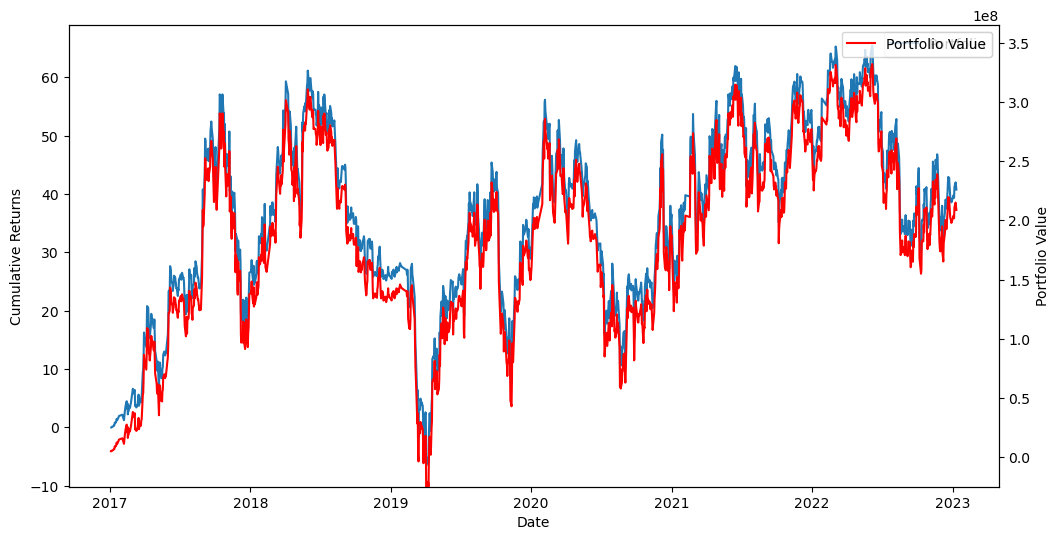

Sharpe Ratio: -0.217
CAGR: 85.81%
max drawdown: -110.72%


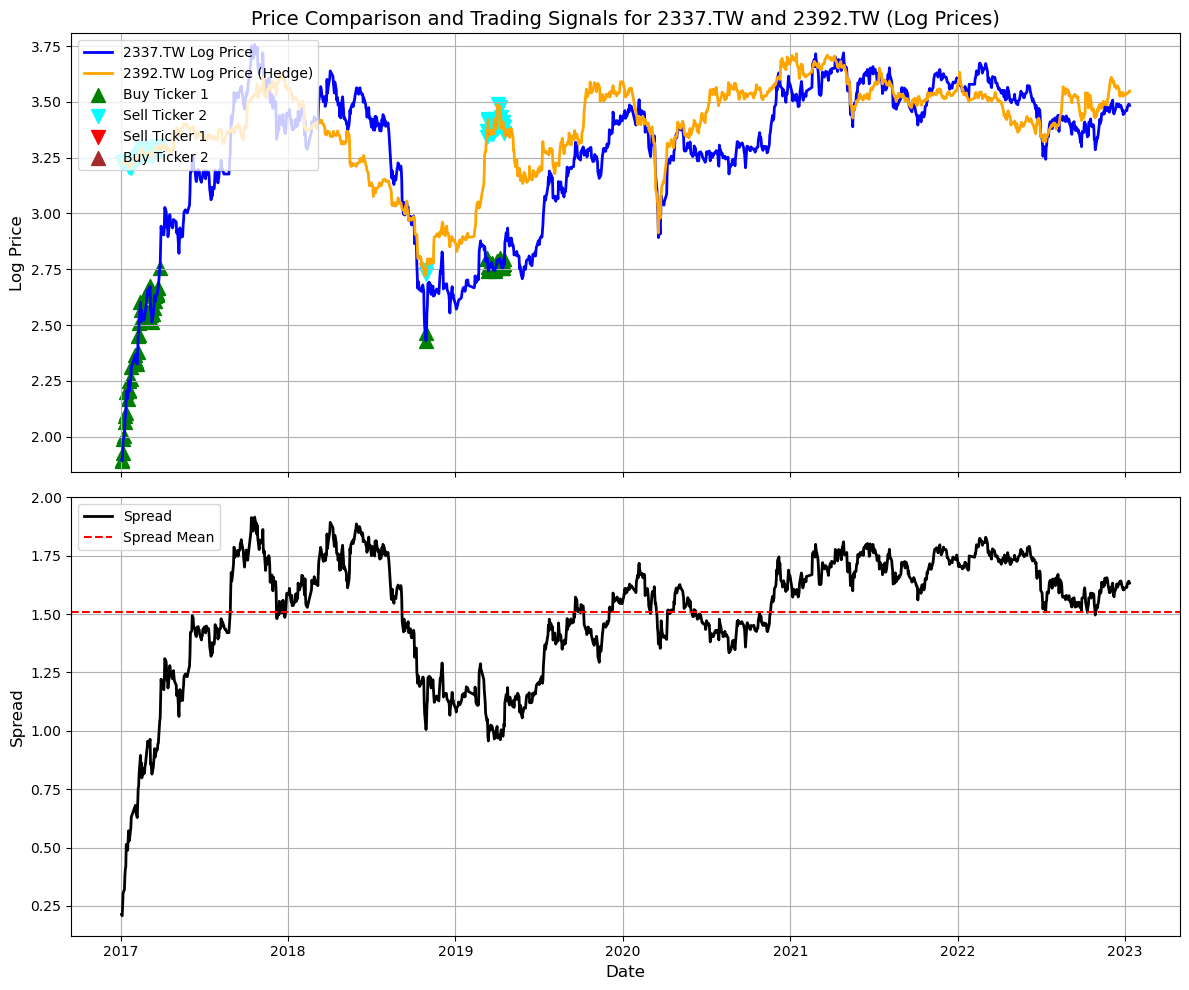

2337.TW    Spread Signal    8150.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662626 -0.098515    Buy  18.956898         375227.0   
2017-01-04   6.633657 -0.091802    Buy  18.649900         376866.0   
2017-01-05   6.879884 -0.078670    Buy  19.302263         363378.0   
2017-01-06   7.299920 -0.045848    Buy  20.069752         342470.0   
2017-01-09   7.415792 -0.020962    Buy  19.801132         337118.0   
...               ...       ...    ...        ...              ...   
2023-01-05  31.845282  1.155850    NaN  29.944792              0.0   
2023-01-06  32.357414  1.167725    NaN  30.125452              0.0   
2023-01-09  32.776432  1.173512    NaN  30.441612              0.0   
2023-01-10  32.776432  1.171503    NaN  30.531940              0.0   
2023-01-11  32.590202  1.165805    NaN  30.531940              0.0   

            8150.TW's trade  2337.TW's position  8150.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2023-01-05              0.0           7930117.0          -7930117.0   
2023-01-06              0.0           7930117.0          -7930117.0   
2023-01-09              0.0           7930117.0          -7930117.0   
2023-01-10              0.0           7930117.0          -7930117.0   
2023-01-11              0.0           7930117.0          -7930117.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  9.613143e+06 -4.613143e+06     5.000000e+06  
2017-01-04  1.414166e+07 -9.037332e+06     5.104324e+06  
2017-01-05  1.865568e+07 -1.385680e+07     4.798872e+06  
2017-01-06  2.302896e+07 -1.861766e+07     4.411299e+06  
2017-01-09  2.720428e+07 -2.223242e+07     4.971865e+06  
...                  ...           ...              ...  
2023-01-05  2.476136e+08  1.507111e+07     2.626847e+08  
2023-01-06  2.476136e+08  1.769972e+07     2.653133e+08  
2023-01-09  2.476136e+08  1.851539e+07     2.661290e+08  
2023-01-10  2.476136e+08  1.779908e+07     2.654127e+08  
2023-01-11  2.476136e+08  1.632226e+07     2.639358e+08  

[1472 rows x 11 columns]

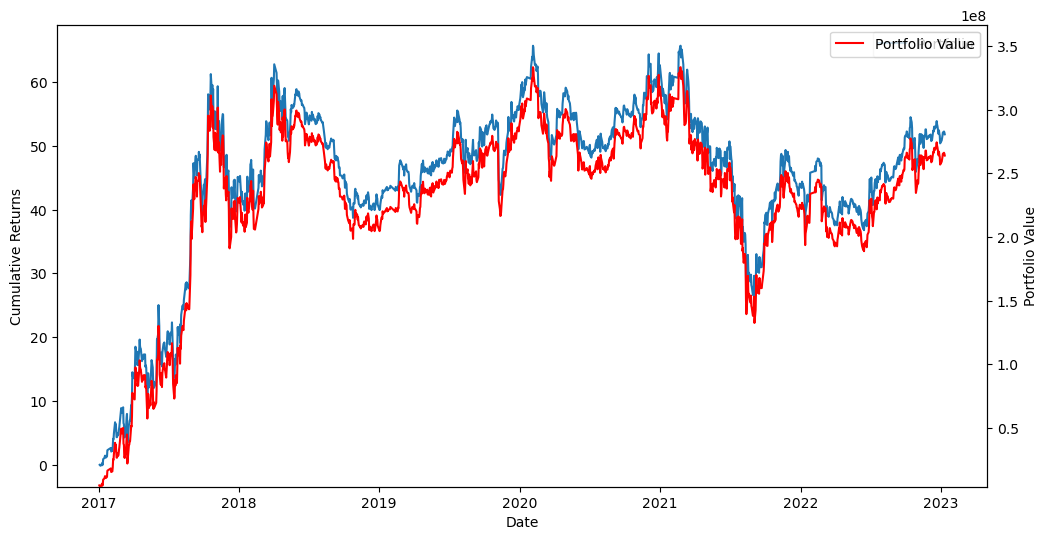

Sharpe Ratio: 1.192
CAGR: 93.16%
max drawdown: -664.30%


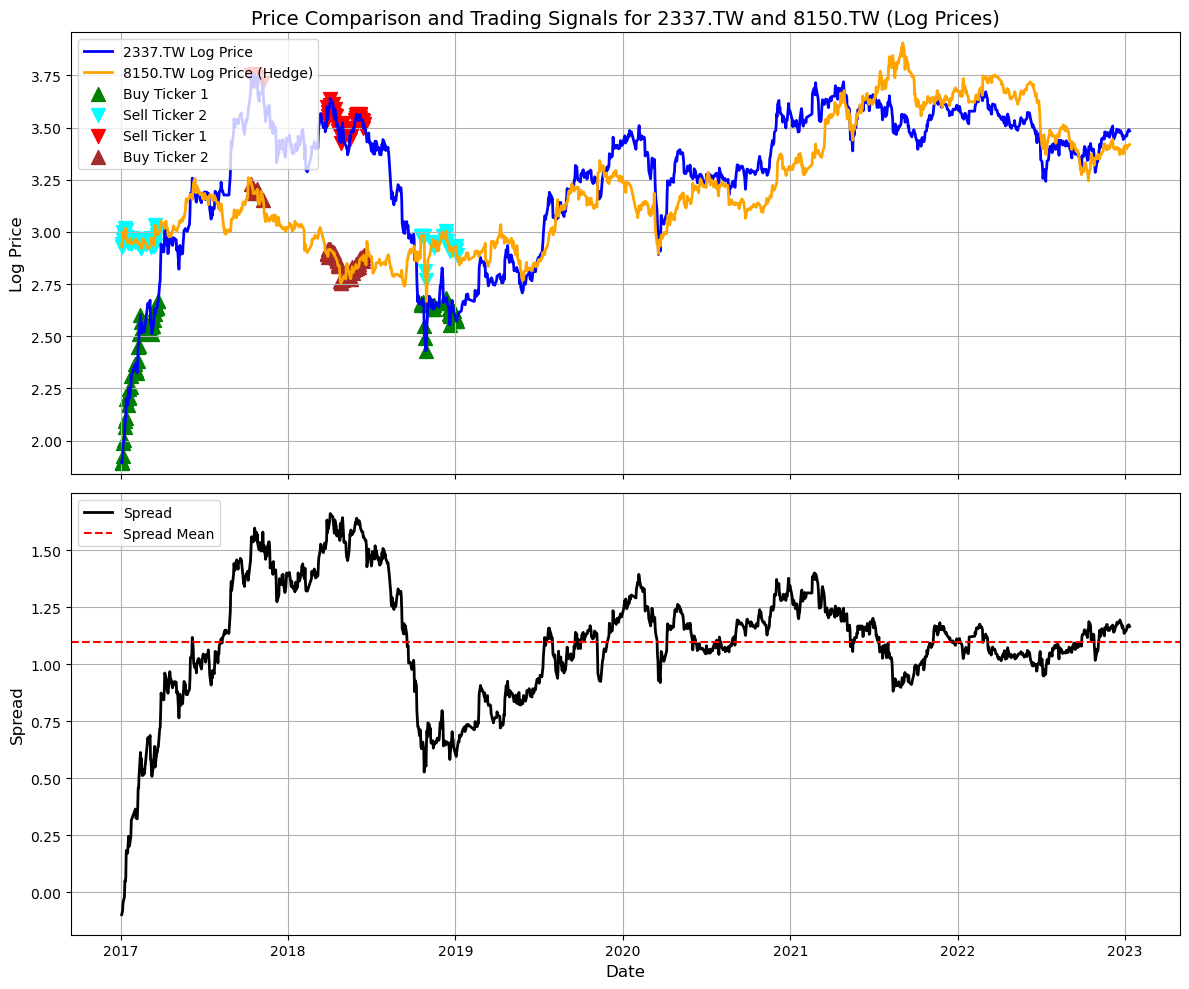

2337.TW    Spread Signal    6269.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662626 -2.954811    Buy  57.503407         375227.0   
2017-01-04   6.633657 -2.966150    Buy  57.839691         376866.0   
2017-01-05   6.879884 -2.931096    Buy  57.906944         363378.0   
2017-01-06   7.299920 -2.884285    Buy  58.512238         342470.0   
2017-01-09   7.415792 -2.879496    Buy  59.050282         337118.0   
...               ...       ...    ...        ...              ...   
2023-01-05  31.845282 -1.881144    NaN  86.633377              0.0   
2023-01-06  32.357414 -1.868918    NaN  86.903557              0.0   
2023-01-09  32.776432 -1.904680    NaN  90.505775              0.0   
2023-01-10  32.776432 -1.916535    NaN  91.406326              0.0   
2023-01-11  32.590202 -1.900809    NaN  89.785324              0.0   

            6269.TW's trade  2337.TW's position  6269.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2023-01-05              0.0          10381703.0         -10381703.0   
2023-01-06              0.0          10381703.0         -10381703.0   
2023-01-09              0.0          10381703.0         -10381703.0   
2023-01-10              0.0          10381703.0         -10381703.0   
2023-01-11              0.0          10381703.0         -10381703.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  2.407683e+07 -1.907683e+07     5.000000e+06  
2017-01-04  4.337465e+07 -3.851170e+07     4.862947e+06  
2017-01-05  6.191676e+07 -5.691921e+07     4.997552e+06  
2017-01-06  7.945544e+07 -7.466454e+07     4.790903e+06  
2017-01-09  9.686236e+07 -9.268695e+07     4.175402e+06  
...                  ...           ...              ...  
2023-01-05  6.350698e+08 -5.687937e+08     6.627603e+07  
2023-01-06  6.350698e+08 -5.662819e+08     6.878791e+07  
2023-01-09  6.350698e+08 -5.993289e+08     3.574087e+07  
2023-01-10  6.350698e+08 -6.086781e+08     2.639161e+07  
2023-01-11  6.350698e+08 -5.937828e+08     4.128700e+07  

[1472 rows x 11 columns]

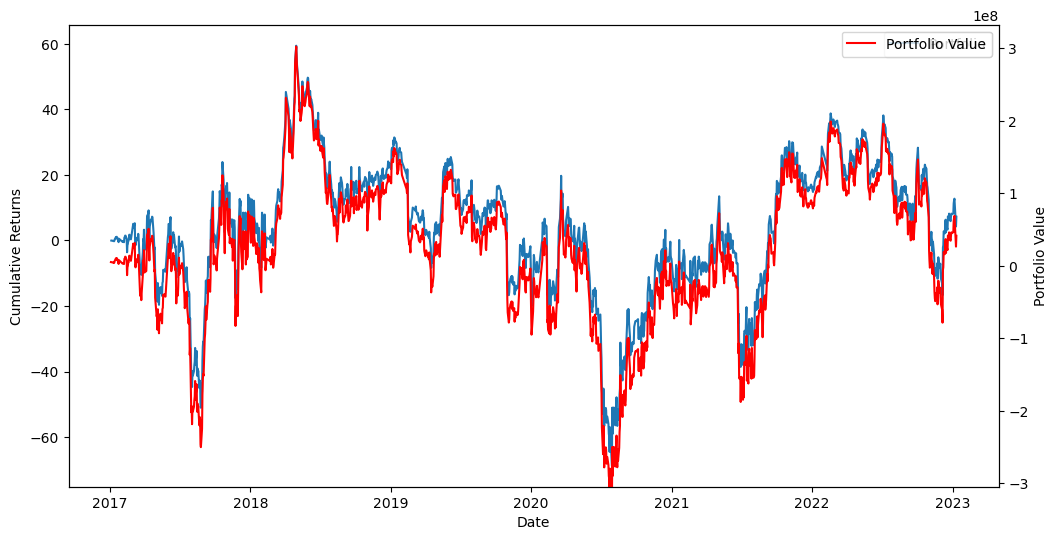

Sharpe Ratio: 0.486
CAGR: 41.97%
max drawdown: -655.73%


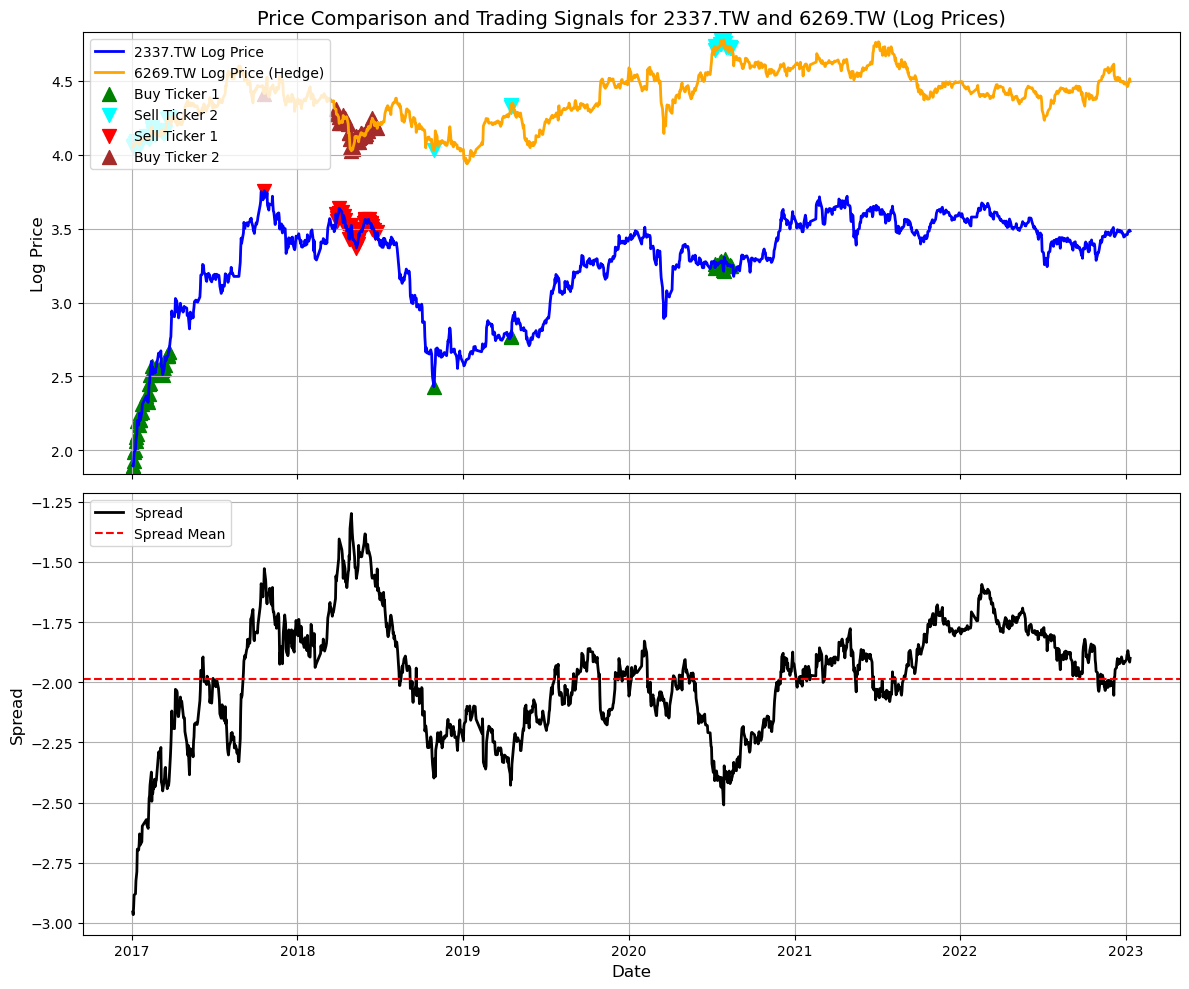

2337.TW    Spread Signal    4938.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662626 -0.631654    Buy  48.883125         375227.0   
2017-01-04   6.633657 -0.642611    Buy  49.381927         376866.0   
2017-01-05   6.879884 -0.596241    Buy  48.633717         363378.0   
2017-01-06   7.299920 -0.536980    Buy  48.633717         342470.0   
2017-01-09   7.415792 -0.520397    Buy  48.571362         337118.0   
...               ...       ...    ...        ...              ...   
2023-01-05  31.845282  0.817902    NaN  58.327515              0.0   
2023-01-06  32.357414  0.831822    NaN  58.510357              0.0   
2023-01-09  32.776432  0.836614    NaN  59.241741              0.0   
2023-01-10  32.776432  0.839630    NaN  58.967472              0.0   
2023-01-11  32.590202  0.833932    NaN  58.967472              0.0   

            4938.TW's trade  2337.TW's position  4938.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2023-01-05              0.0          14266218.0         -14266218.0   
2023-01-06              0.0          14266218.0         -14266218.0   
2023-01-09              0.0          14266218.0         -14266218.0   
2023-01-10              0.0          14266218.0         -14266218.0   
2023-01-11              0.0          14266218.0         -14266218.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  2.084227e+07 -1.584227e+07     5.000000e+06  
2017-01-04  3.695264e+07 -3.215067e+07     4.801966e+06  
2017-01-05  5.212506e+07 -4.657519e+07     5.549876e+06  
2017-01-06  6.628065e+07 -6.026224e+07     6.018414e+06  
2017-01-09  8.015493e+07 -7.387667e+07     6.278259e+06  
...                  ...           ...              ...  
2023-01-05  5.343526e+08 -3.778013e+08     1.565513e+08  
2023-01-06  5.343526e+08 -3.731036e+08     1.612490e+08  
2023-01-09  5.343526e+08 -3.775599e+08     1.567927e+08  
2023-01-10  5.343526e+08 -3.736471e+08     1.607055e+08  
2023-01-11  5.343526e+08 -3.763039e+08     1.580487e+08  

[1472 rows x 11 columns]

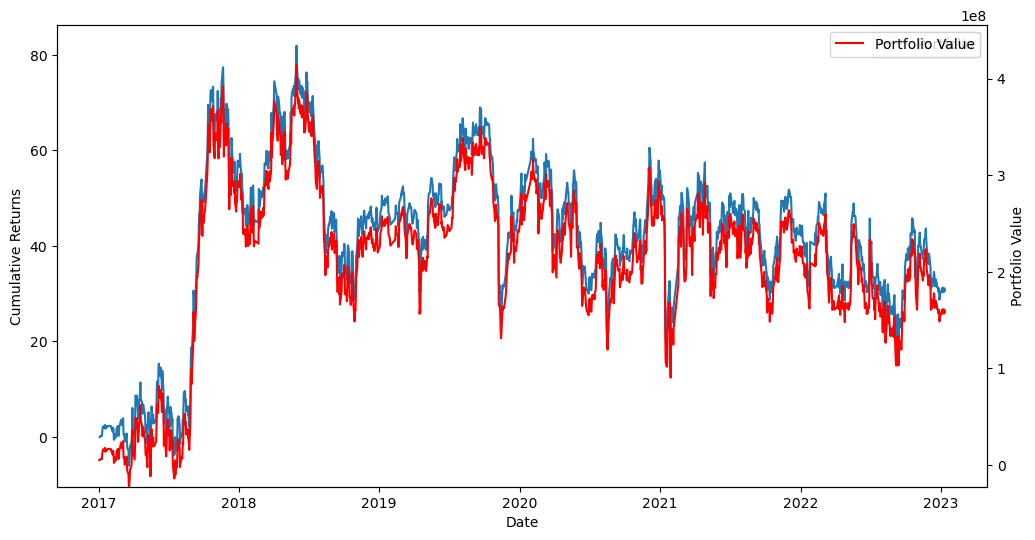

Sharpe Ratio: 0.583
CAGR: 77.40%
max drawdown: -252.59%


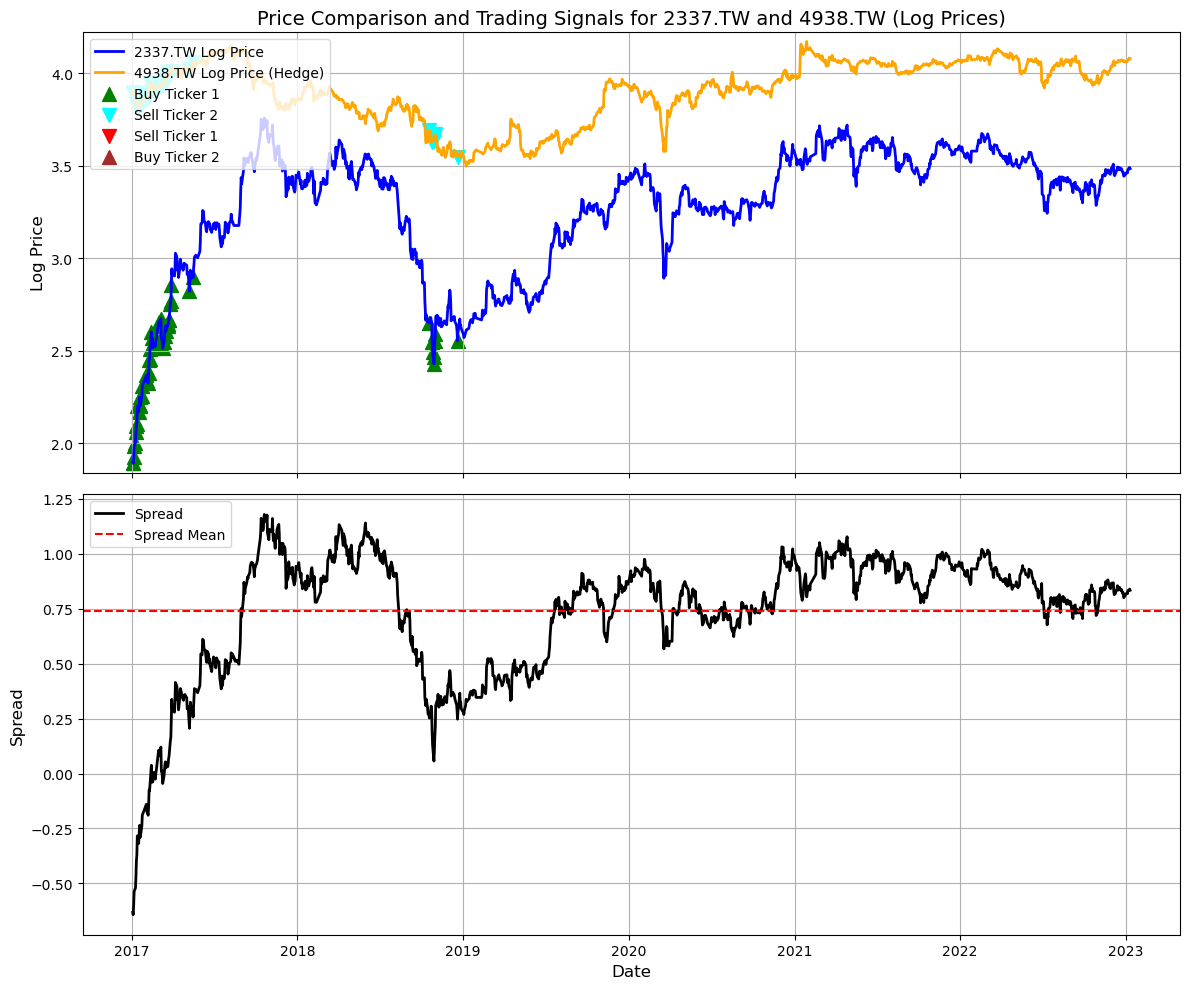

2337.TW    Spread Signal    2347.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662626 -1.007299    Buy  21.310986         375227.0   
2017-01-04   6.633657 -1.004292    Buy  21.146294         376866.0   
2017-01-05   6.879884 -0.970799    Buy  21.212168         363378.0   
2017-01-06   7.299920 -0.917415    Buy  21.343922         342470.0   
2017-01-09   7.415792 -0.898732    Buy  21.278046         337118.0   
...               ...       ...    ...        ...              ...   
2023-01-05  31.845282 -0.314752    NaN  53.394699              0.0   
2023-01-06  32.357414 -0.300417    NaN  53.485817              0.0   
2023-01-09  32.776432 -0.306759    NaN  54.579227              0.0   
2023-01-10  32.776432 -0.309923    NaN  54.761459              0.0   
2023-01-11  32.590202 -0.309282    NaN  54.396988              0.0   

            2347.TW's trade  2337.TW's position  2347.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2023-01-05              0.0                 0.0                 0.0   
2023-01-06              0.0                 0.0                 0.0   
2023-01-09              0.0                 0.0                 0.0   
2023-01-10              0.0                 0.0                 0.0   
2023-01-11              0.0                 0.0                 0.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  1.049646e+07 -5.496460e+06     5.000000e+06  
2017-01-04  1.596578e+07 -1.091485e+07     5.050927e+06  
2017-01-05  2.117382e+07 -1.598725e+07     5.186569e+06  
2017-01-06  2.598346e+07 -2.047533e+07     5.508139e+06  
2017-01-09  3.065668e+07 -2.488356e+07     5.773118e+06  
...                  ...           ...              ...  
2023-01-05  1.721003e+08  0.000000e+00     1.721003e+08  
2023-01-06  1.721003e+08  0.000000e+00     1.721003e+08  
2023-01-09  1.721003e+08  0.000000e+00     1.721003e+08  
2023-01-10  1.721003e+08  0.000000e+00     1.721003e+08  
2023-01-11  1.721003e+08  0.000000e+00     1.721003e+08  

[1472 rows x 11 columns]

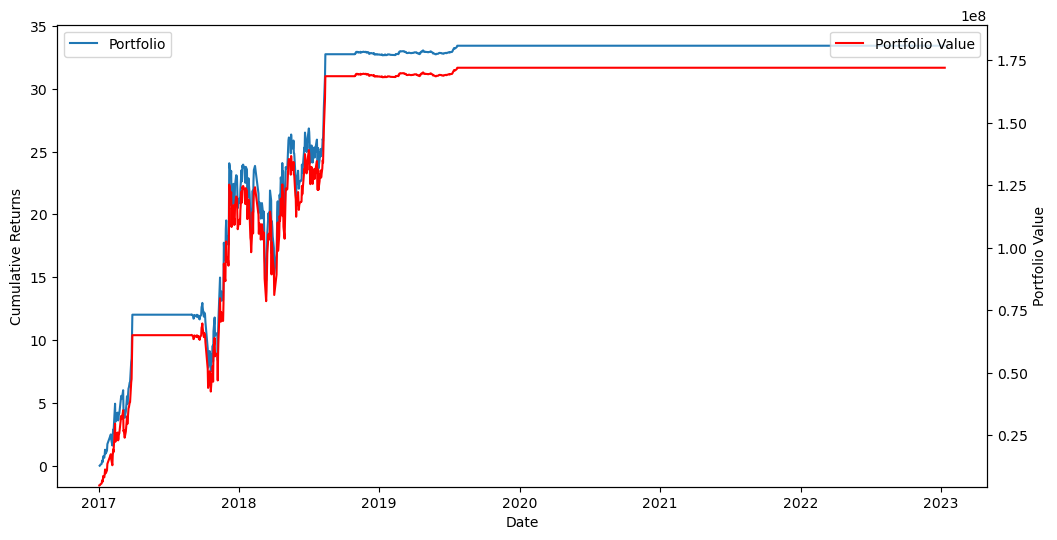

Sharpe Ratio: 1.288
CAGR: 79.92%
max drawdown: -42.03%


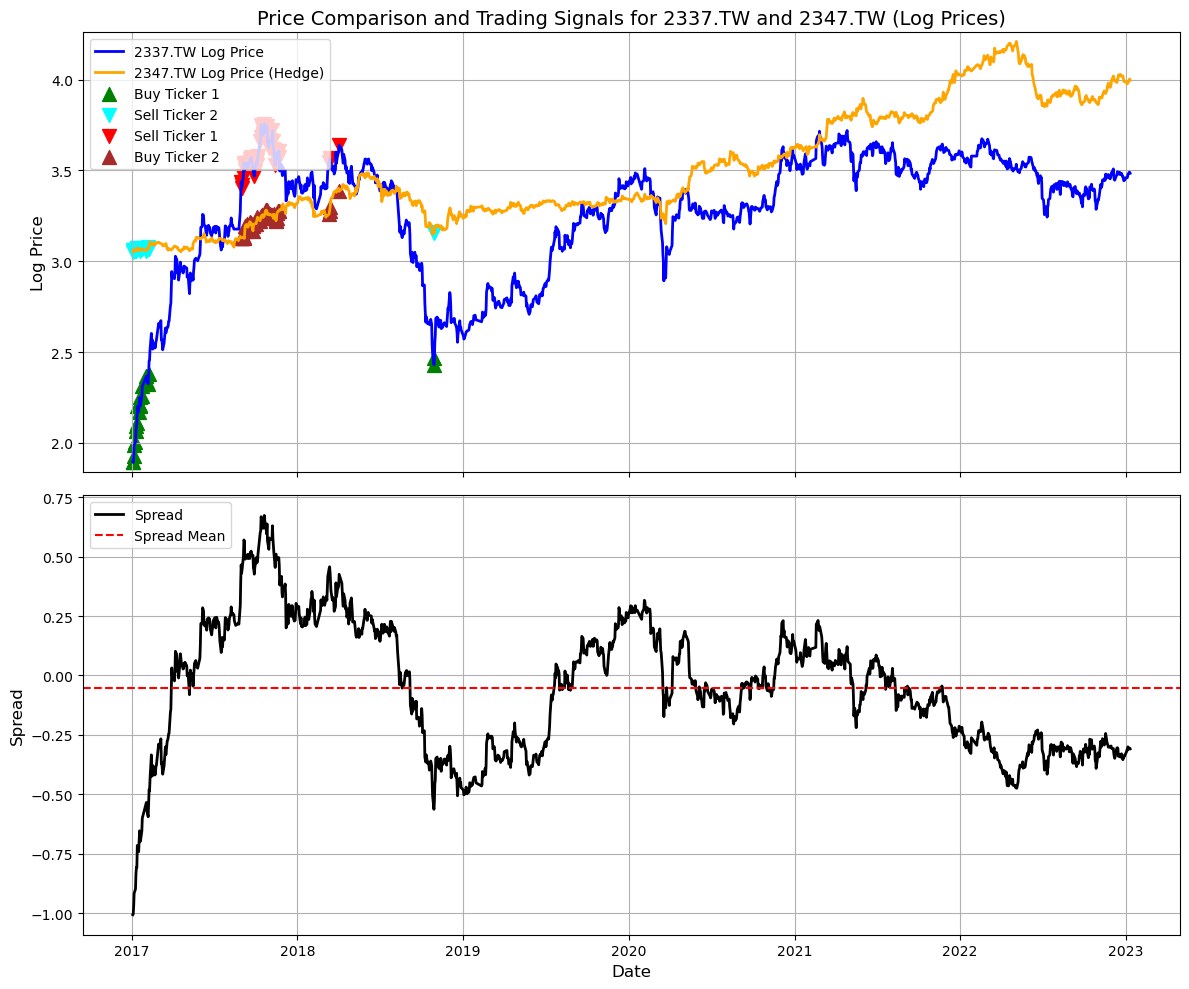

2337.TW    Spread Signal    3231.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662626  0.933458    Buy  15.547925         375227.0   
2017-01-04   6.633657  0.932628    Buy  15.392447         376866.0   
2017-01-05   6.879884  0.973354    Buy  15.205870         363378.0   
2017-01-06   7.299920  1.023406    Buy  15.610118         342470.0   
2017-01-09   7.415792  1.040556    Buy  15.547925         337118.0   
...               ...       ...    ...        ...              ...   
2023-01-05  31.845282  2.290234    NaN  28.090117              0.0   
2023-01-06  32.357414  2.308575    NaN  27.899673              0.0   
2023-01-09  32.776432  2.313155    NaN  28.566219              0.0   
2023-01-10  32.776432  2.311405    NaN  28.709051              0.0   
2023-01-11  32.590202  2.303965    NaN  28.851881              0.0   

            3231.TW's trade  2337.TW's position  3231.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2023-01-05              0.0          16809983.0         -16809983.0   
2023-01-06              0.0          16809983.0         -16809983.0   
2023-01-09              0.0          16809983.0         -16809983.0   
2023-01-10              0.0          16809983.0         -16809983.0   
2023-01-11              0.0          16809983.0         -16809983.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  8.334004e+06 -3.334004e+06     5.000000e+06  
2017-01-04  1.163489e+07 -6.587425e+06     5.047470e+06  
2017-01-05  1.466037e+07 -9.287395e+06     5.372979e+06  
2017-01-06  1.750637e+07 -1.211578e+07     5.390590e+06  
2017-01-09  2.024786e+07 -1.459766e+07     5.650198e+06  
...                  ...           ...              ...  
2023-01-05  9.867549e+07  6.312426e+07     1.617998e+08  
2023-01-06  9.867549e+07  7.493455e+07     1.736100e+08  
2023-01-09  9.867549e+07  7.077360e+07     1.694491e+08  
2023-01-10  9.867549e+07  6.837260e+07     1.670481e+08  
2023-01-11  9.867549e+07  6.284112e+07     1.615166e+08  

[1472 rows x 11 columns]

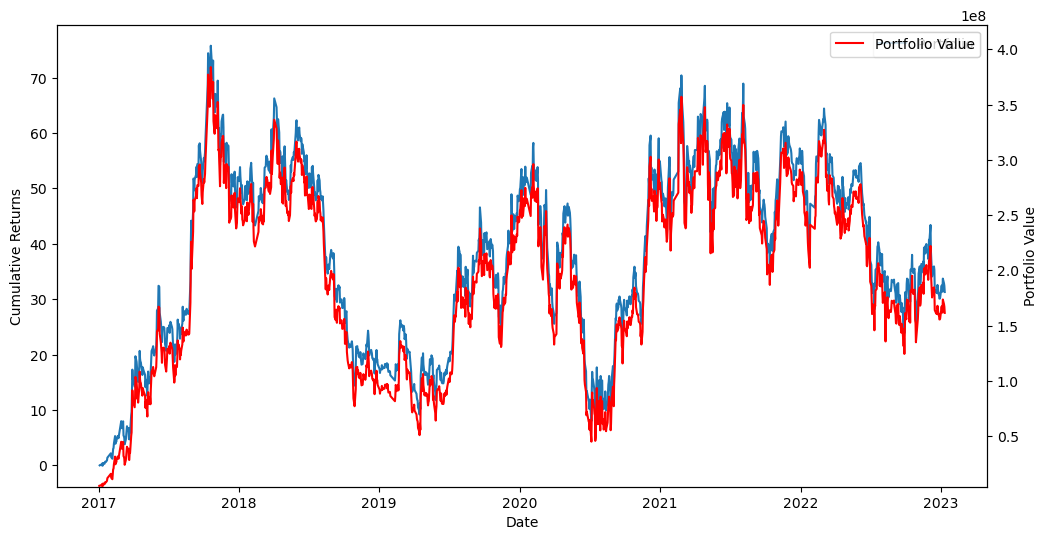

Sharpe Ratio: 1.054
CAGR: 78.04%
max drawdown: -117.65%


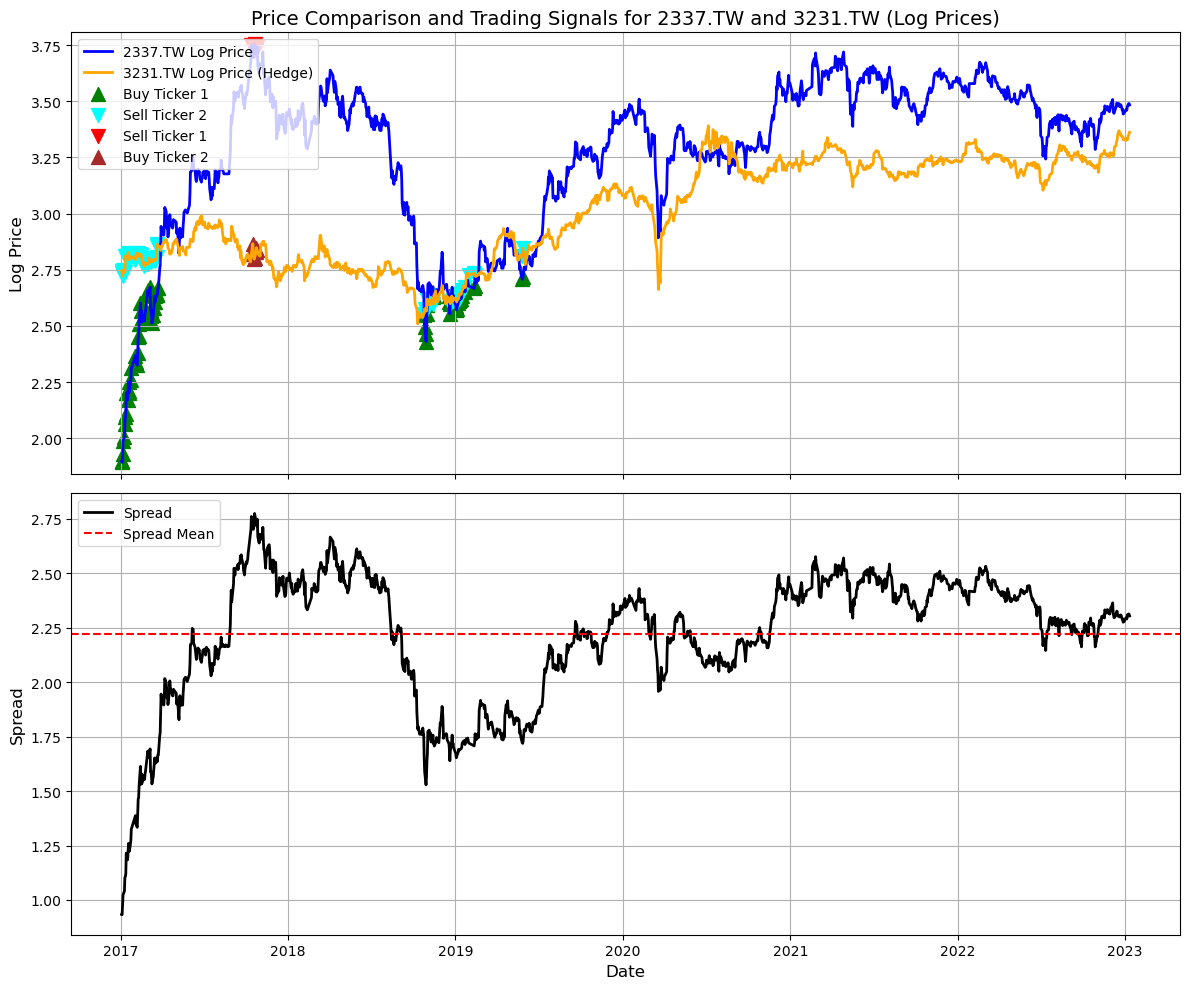

2337.TW    Spread Signal    2328.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662626  0.088996    Buy  18.913231         375227.0   
2017-01-04   6.633657  0.073713    Buy  19.252312         376866.0   
2017-01-05   6.879884  0.119860    Buy  18.950905         363378.0   
2017-01-06   7.299920  0.185264    Buy  18.762527         342470.0   
2017-01-09   7.415792  0.199779    Buy  18.800205         337118.0   
...               ...       ...    ...        ...              ...   
2023-01-05  31.845282  1.268516    NaN  35.368263              0.0   
2023-01-06  32.357414  1.272469    NaN  36.065403              0.0   
2023-01-09  32.776432  1.307108    NaN  34.810555              0.0   
2023-01-10  32.776432  1.310401    NaN  34.624645              0.0   
2023-01-11  32.590202  1.306356    NaN  34.531693              0.0   

            2328.TW's trade  2337.TW's position  2328.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2023-01-05              0.0          10716039.0         -10716039.0   
2023-01-06              0.0          10716039.0         -10716039.0   
2023-01-09              0.0          10716039.0         -10716039.0   
2023-01-10              0.0          10716039.0         -10716039.0   
2023-01-11              0.0          10716039.0         -10716039.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  9.596758e+06 -4.596758e+06     5.000000e+06  
2017-01-04  1.435230e+07 -9.490402e+06     4.861898e+06  
2017-01-05  1.873864e+07 -1.346487e+07     5.273769e+06  
2017-01-06  2.266424e+07 -1.671181e+07     5.952437e+06  
2017-01-09  2.650213e+07 -2.043569e+07     6.066440e+06  
...                  ...           ...              ...  
2023-01-05  1.711985e+08 -3.775241e+07     1.334461e+08  
2023-01-06  1.711985e+08 -3.973495e+07     1.314636e+08  
2023-01-09  1.711985e+08 -2.179774e+07     1.494008e+08  
2023-01-10  1.711985e+08 -1.980552e+07     1.513930e+08  
2023-01-11  1.711985e+08 -2.080508e+07     1.503934e+08  

[1472 rows x 11 columns]

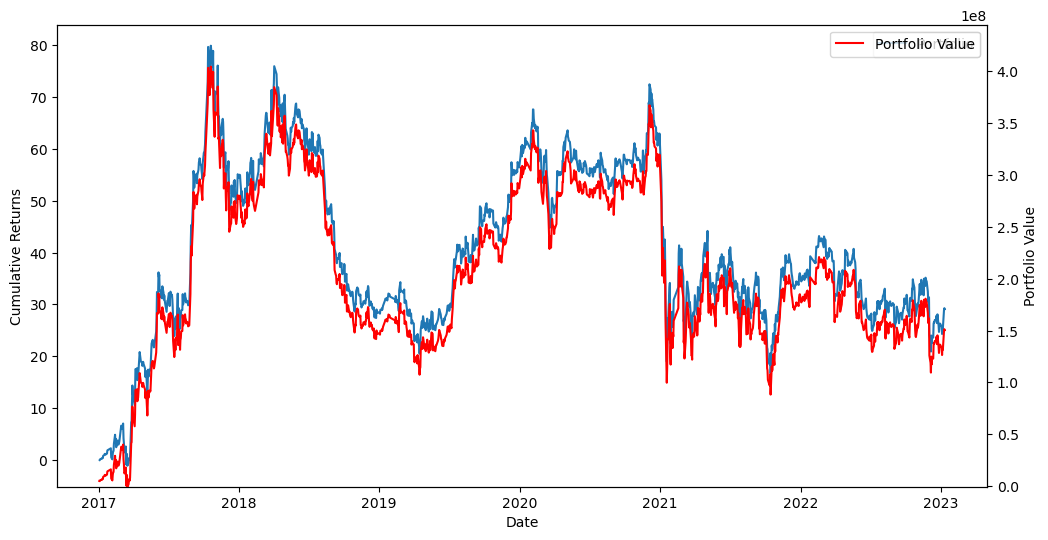

Sharpe Ratio: 0.656
CAGR: 75.94%
max drawdown: -115.94%


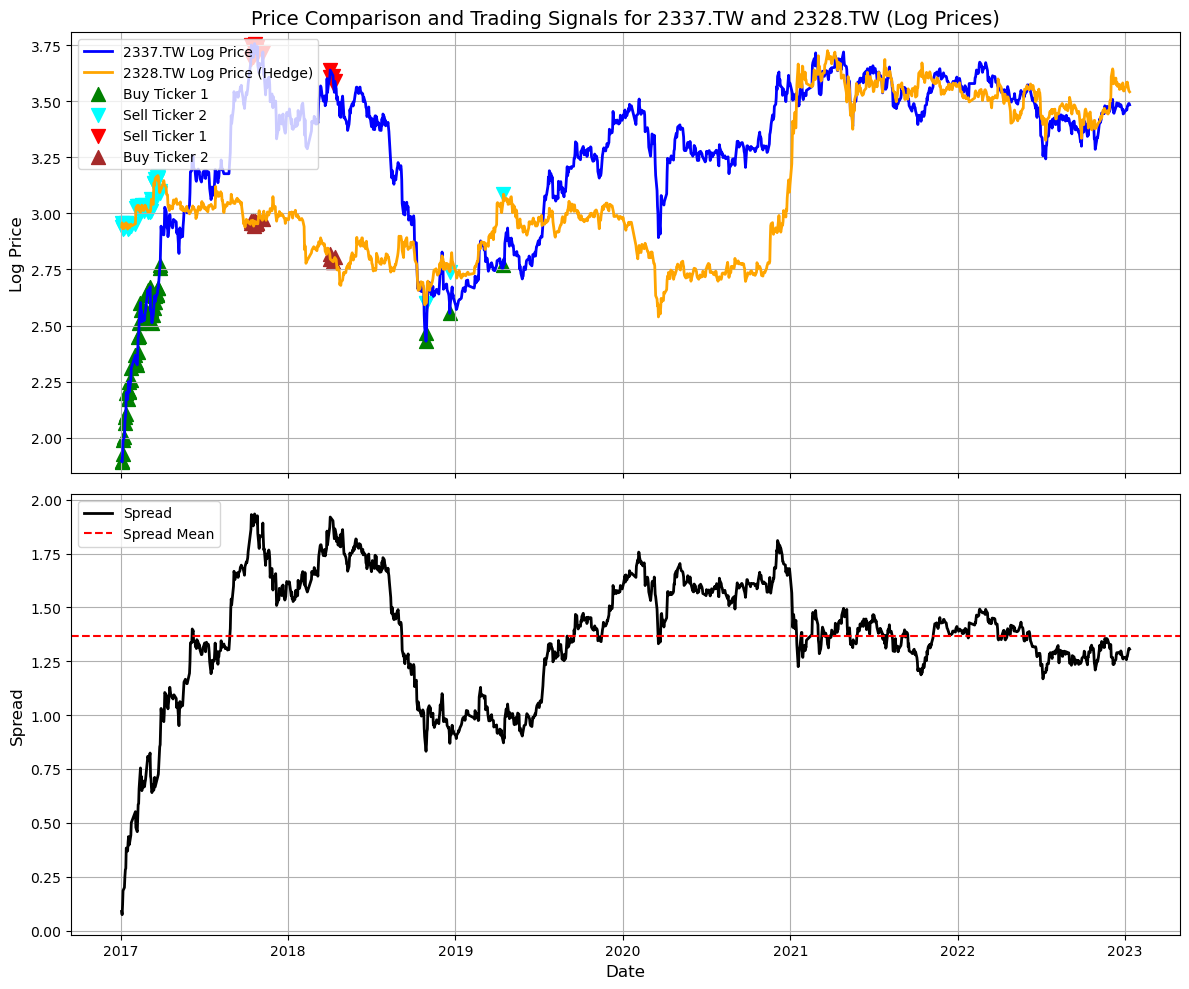

2337.TW    Spread Signal    1802.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662626  0.706235    Buy  11.342632         375227.0   
2017-01-04   6.633657  0.703731    Buy  11.299829         376866.0   
2017-01-05   6.879884  0.736477    Buy  11.385434         363378.0   
2017-01-06   7.299920  0.801298    Buy  11.257027         342470.0   
2017-01-09   7.415792  0.820788    Buy  11.171423         337118.0   
...               ...       ...    ...        ...              ...   
2023-01-05  31.845282  1.958331    NaN  21.450001              0.0   
2023-01-06  32.357414  1.958545    NaN  22.150000              0.0   
2023-01-09  32.776432  1.967006    NaN  22.350000              0.0   
2023-01-10  32.776432  1.968104    NaN  22.299999              0.0   
2023-01-11  32.590202  1.960213    NaN  22.400000              0.0   

            1802.TW's trade  2337.TW's position  1802.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2023-01-05              0.0          22281030.0         -22281030.0   
2023-01-06              0.0          22281030.0         -22281030.0   
2023-01-09              0.0          22281030.0         -22281030.0   
2023-01-10              0.0          22281030.0         -22281030.0   
2023-01-11              0.0          22281030.0         -22281030.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  6.756065e+06 -1.756065e+06     5.000000e+06  
2017-01-04  8.514586e+06 -3.509395e+06     5.005191e+06  
2017-01-05  1.015180e+07 -5.025810e+06     5.125994e+06  
2017-01-06  1.150699e+07 -5.769228e+06     5.737766e+06  
2017-01-09  1.277309e+07 -6.741578e+06     6.031507e+06  
...                  ...           ...              ...  
2023-01-05  3.891288e+07  2.316176e+08     2.705304e+08  
2023-01-06  3.891288e+07  2.274317e+08     2.663446e+08  
2023-01-09  3.891288e+07  2.323116e+08     2.712245e+08  
2023-01-10  3.891288e+07  2.334257e+08     2.723386e+08  
2023-01-11  3.891288e+07  2.270482e+08     2.659611e+08  

[1472 rows x 11 columns]

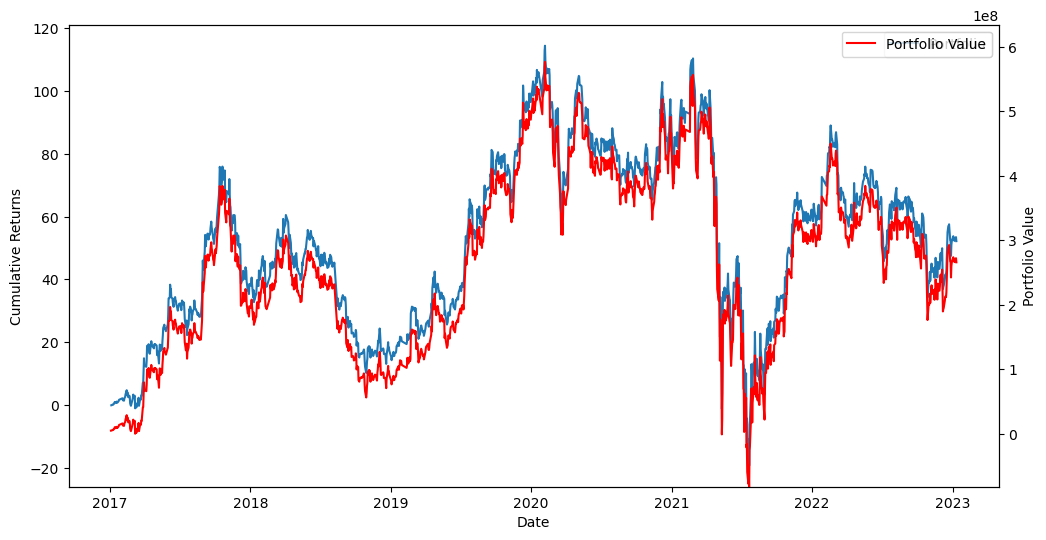

Sharpe Ratio: 0.247
CAGR: 93.40%
max drawdown: -119.81%


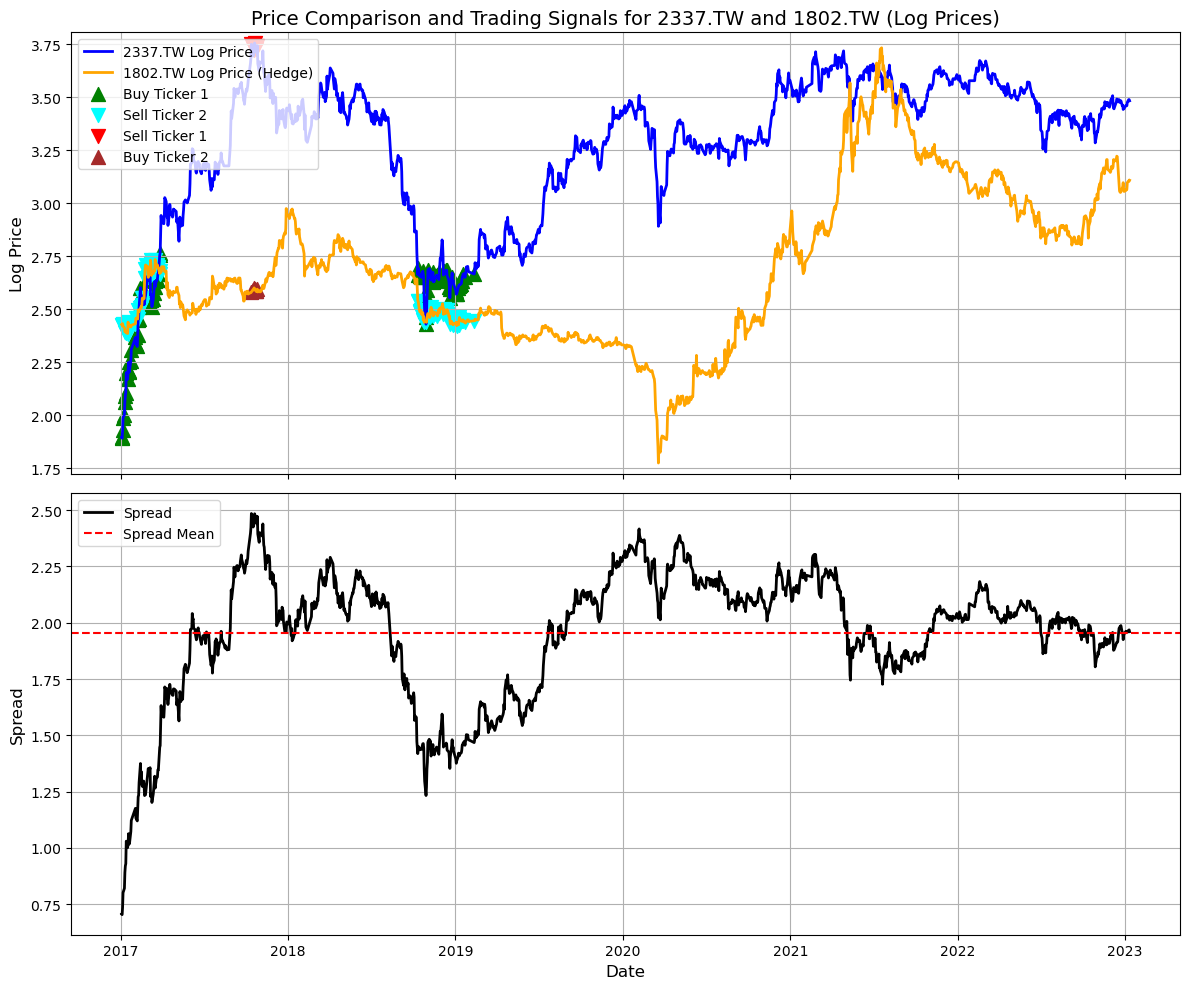

2337.TW    Spread Signal    1440.TW  2337.TW's trade  \
Date                                                                 
2017-01-03   6.662626  1.073640    Buy   9.961992         375227.0   
2017-01-04   6.633657  1.072217    Buy   9.880671         376866.0   
2017-01-05   6.879884  1.104270    Buy  10.002653         363378.0   
2017-01-06   7.299920  1.152076    Buy  10.327944         342470.0   
2017-01-09   7.415792  1.166418    Buy  10.368606         337118.0   
...               ...       ...    ...        ...              ...   
2023-01-05  31.845282  2.467699    NaN  16.031797              0.0   
2023-01-06  32.357414  2.482586    NaN  16.079655              0.0   
2023-01-09  32.776432  2.493328    NaN  16.175365              0.0   
2023-01-10  32.776432  2.495452    NaN  16.079655              0.0   
2023-01-11  32.590202  2.489754    NaN  16.079655              0.0   

            1440.TW's trade  2337.TW's position  1440.TW's position  \
Date                                                                  
2017-01-03        -375227.0            375227.0           -375227.0   
2017-01-04        -376866.0            752093.0           -752093.0   
2017-01-05        -363378.0           1115471.0          -1115471.0   
2017-01-06        -342470.0           1457941.0          -1457941.0   
2017-01-09        -337118.0           1795059.0          -1795059.0   
...                     ...                 ...                 ...   
2023-01-05              0.0          25345694.0         -25345694.0   
2023-01-06              0.0          25345694.0         -25345694.0   
2023-01-09              0.0          25345694.0         -25345694.0   
2023-01-10              0.0          25345694.0         -25345694.0   
2023-01-11              0.0          25345694.0         -25345694.0   

                    Cash  Position MTM  Portfolio Value  
Date                                                     
2017-01-03  6.238011e+06 -1.238011e+06     5.000000e+06  
2017-01-04  7.461700e+06 -2.442056e+06     5.019644e+06  
2017-01-05  8.596446e+06 -3.483358e+06     5.113088e+06  
2017-01-06  9.633453e+06 -4.414680e+06     5.218773e+06  
2017-01-09  1.062890e+07 -5.300474e+06     5.328426e+06  
...                  ...           ...              ...  
2023-01-05 -2.267897e+07  4.008037e+08     3.781248e+08  
2023-01-06 -2.267897e+07  4.125711e+08     3.898921e+08  
2023-01-09 -2.267897e+07  4.207656e+08     3.980866e+08  
2023-01-10 -2.267897e+07  4.231914e+08     4.005124e+08  
2023-01-11 -2.267897e+07  4.184713e+08     3.957923e+08  

[1472 rows x 11 columns]

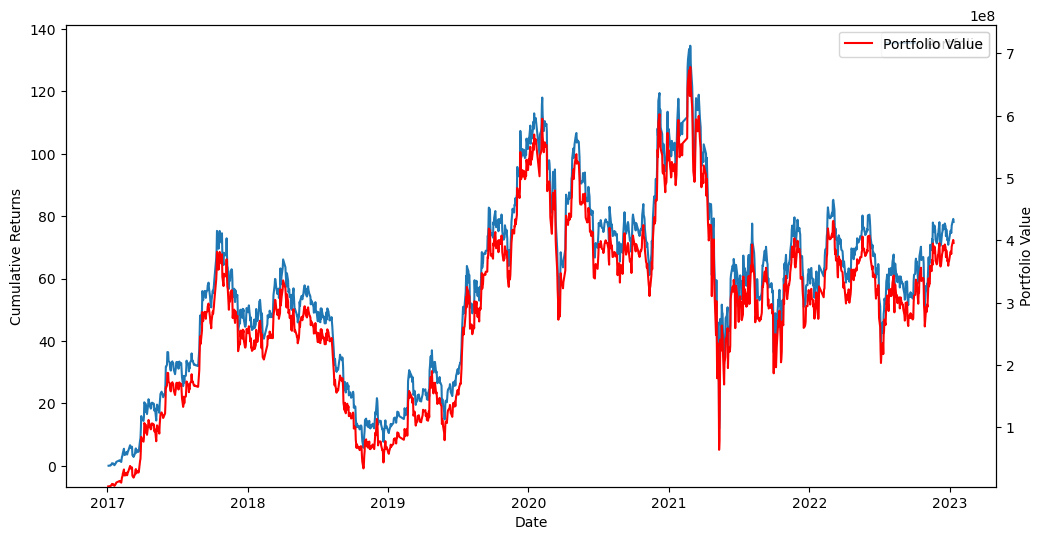

Sharpe Ratio: 1.194
CAGR: 106.60%
max drawdown: -92.32%


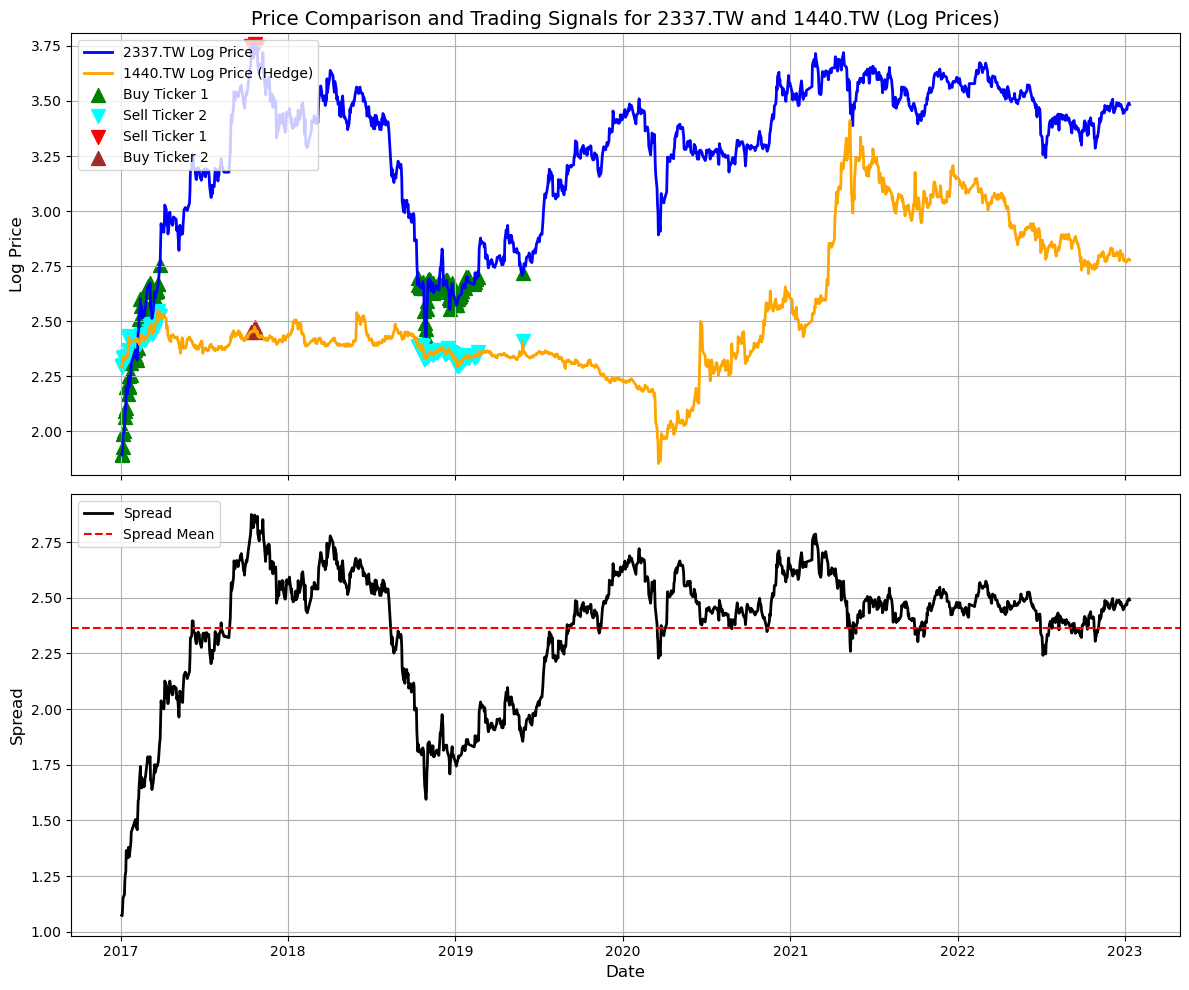

In [232]:
Backtest = Backtest(FPairs,merged_df,HR)
signal = Backtest.position()